In [1]:
import os
import logging, timeit
#from btEngine2.DataLoader import DataLoader
from btEngine2.MarketData import MarketData
from btEngine2.TradingRule import TradingRule

import polars as pl
import numpy as np  


import platform
import pandas as pd


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.display.float_format = lambda x: f'{x:,.0f}' if abs(x) >= 1000 else (f'{x:.2f}' if abs(x) < 10 else f'{x:.1f}')
pd.set_option('future.no_silent_downcasting', True)

pd.set_option('display.max_rows', 40)

# Detect operating system
if platform.system() == "Windows":
    ticker_csv_path = r'G:\Projects\BackTesting1.0\Data\Inputs\TickerList-Futs.csv'
    save_directory = r"G:\Projects\BackTesting1.0\Data\Bloomberg\Futures"
    helper_directory = r'G:\Projects\BackTesting1.0\Data\Bloomberg\HelperFiles'
    bt_folder = r'BackTests\seasn_research'
    av_folder = r'G:\Projects\BackTesting1.0\Data\Inputs\AssetSizing-Futs.csv'
else:  # Assume macOS for other cases
    ticker_csv_path = r'Data/Inputs/TickerList-Futs.csv'
    save_directory = r"Data/Bloomberg/Futures"
    helper_directory = r'Data/Bloomberg/HelperFiles'
    bt_folder = r'BackTests/seasn_research'
    av_folder = r'Data/Inputs/AssetSizing-Futs.csv'


# Define paths to auxiliary data for MarketData
tick_values_path = os.path.join(helper_directory, 'fut_val_pt.parquet')
fx_rates_path = os.path.join(helper_directory, 'fxHist.parquet')

# Initialize the MarketData
market_data = MarketData(
    base_directory=save_directory,
    tick_values_path=tick_values_path,
    fx_rates_path=fx_rates_path,
    instrument_type="Futures",
    n_threads=8,  # Number of threads for parallel data loading
    log_level=logging.ERROR  # Set to DEBUG for more detailed logs
)


In [2]:
tick = 'IK1 Comdty'
# Access data for a specific ticker
try:
    test_df = market_data.get_ticker_data(tick)
    print(test_df)
except ValueError as e:
    print(e)

# Access all preprocessed data
all_data = market_data.get_data()
print(f"Total tickers loaded: {len(all_data)}")

# Access FX rates
fx_rates = market_data.get_fx_rates()
# Access tick values
tick_values = market_data.get_tick_values()
# Access asset classes
asset_classes = market_data.get_asset_classes()

#market_data = market_data.date_filter(start_date='01012010')

shape: (3_887, 14)
┌────────────┬────────┬────────┬────────┬───┬─────────┬─────────┬─────────────────┬────────────────┐
│ Date       ┆ Open   ┆ High   ┆ Low    ┆ … ┆ BadOHLC ┆ FX_Rate ┆ Tick_Value_Base ┆ Tick_Value_USD │
│ ---        ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---     ┆ ---     ┆ ---             ┆ ---            │
│ date       ┆ f64    ┆ f64    ┆ f64    ┆   ┆ bool    ┆ f64     ┆ f64             ┆ f64            │
╞════════════╪════════╪════════╪════════╪═══╪═════════╪═════════╪═════════════════╪════════════════╡
│ 2009-09-14 ┆ null   ┆ null   ┆ null   ┆ … ┆ false   ┆ 1.4618  ┆ 1000.0          ┆ 1461.8         │
│ 2009-09-15 ┆ 43.51  ┆ 43.74  ┆ 43.33  ┆ … ┆ false   ┆ 1.4658  ┆ 1000.0          ┆ 1465.8         │
│ 2009-09-16 ┆ 43.48  ┆ 43.72  ┆ 43.31  ┆ … ┆ false   ┆ 1.4709  ┆ 1000.0          ┆ 1470.9         │
│ 2009-09-17 ┆ 43.23  ┆ 43.4   ┆ 43.14  ┆ … ┆ false   ┆ 1.4741  ┆ 1000.0          ┆ 1474.1         │
│ 2009-09-18 ┆ 43.48  ┆ 43.61  ┆ 43.17  ┆ … ┆ false   ┆ 1.4712  ┆ 1000.0

In [3]:

def generate_seasonal_features(df, X_years=5, ewma_span=10, ret_type='abs', rm_outliers=0, min_lb=0, lag_day=0):
    """
    Generates seasonal features for each ISO week over the last X_years.

    Parameters:
    - df: DataFrame with columns ['Date', 'Open', 'High', 'Low', 'Close'].
    - X_years: Lookback period in years.
    - ewma_span: EWMA smoothing period.
    - ret_type: 'abs' for absolute returns or 'pct' for percentage returns.
    - rm_outliers: Threshold for z-scores to remove outliers (e.g., rm_outliers=5 removes z-scores > 5).
    - min_lb: Minimum lookback period for rolling calculations.

    Returns:
    - Dictionary with keys as ISO weeks ('w1', 'w2', ...) and values as feature DataFrames.
    """
    # Ensure min_lb is valid
    rolling_window = 52 * X_years  # Weekly data, so 52 weeks per year
    if min_lb == 0 or min_lb > rolling_window:
        min_lb = X_years

    # Ensure df is a Pandas DataFrame
    if isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Assuming 'df' is your DataFrame with 'Date' as the DateTimeIndex
    # Get the last date in the DataFrame
    last_date = df.index[-1]

    # Calculate the next business day
    next_business_day = last_date + pd.tseries.offsets.BDay()

    # Store the original index name (optional if index name is preserved)
    original_index_name = df.index.name

    # Create a new index that includes the next business day using union()
    new_index = df.index.union([next_business_day])

    # Reindex the DataFrame to include the new index
    df = df.reindex(new_index)

    # Forward-fill the data
    df = df.ffill().infer_objects(copy=False)

    # The index name should be preserved, but you can restore it just in case
    df.index.name = original_index_name


    # Add ISO week and ISO year columns
    df['ISO_Week'] = df.index.isocalendar().week
    df['ISO_Year'] = df.index.isocalendar().year

    if lag_day:
        df['ISO_Week'] = df['ISO_Week'].shift(lag_day)
        df['ISO_Year'] = df['ISO_Year'].shift(lag_day)
        
    # Calculate weekly returns
    if ret_type == 'abs':
        df['Daily_Return'] = df['Close'] - df['Close'].shift(1)
        df['Weekly_Return'] = df.groupby(['ISO_Year', 'ISO_Week'])['Daily_Return'].transform('sum')
    else:
        df['Daily_Return'] = (df['Close'] / df['Close'].shift(1)) - 1
        df['Weekly_Return'] = df.groupby(['ISO_Year', 'ISO_Week'])['Daily_Return'].transform(lambda x: (1 + x).prod() - 1)

    '''
    # Aggregate weekly data
    weekly_data = df.groupby(['ISO_Year', 'ISO_Week']).agg({
        'Weekly_Return': 'first',
        'ISO_Week': 'first',
        'ISO_Year': 'first'
    })

    # Ensure weekly data keeps the first date of the week as the index
    weekly_data['Date'] = df.groupby(['ISO_Year', 'ISO_Week']).apply(lambda x: x.index[0]).values
    weekly_data.set_index('Date', inplace=True)
    '''

    # Aggregate weekly data
    weekly_data = df.groupby(['ISO_Year', 'ISO_Week']).agg({
        'Weekly_Return': 'first',
        'ISO_Week': 'first',
        'ISO_Year': 'first'
    })

    # Ensure weekly data keeps the first date of the week as the index
    # Ensure weekly data keeps the first date of the week as the index
    weekly_data['Date'] = (
        df.groupby(['ISO_Year', 'ISO_Week'], group_keys=False)
        .apply(lambda x: x.index[0] if len(x) > 0 else pd.NaT)  # Explicitly work on the group's index
        .reset_index(drop=True)  # Drop grouping columns
        .values
    )
    weekly_data.set_index('Date', inplace=True)

    # Dictionary to hold features for each week
    features_dict = {}

    for week in range(1, 53):
        week_key = f'w{week}'
        df_week = weekly_data[weekly_data['ISO_Week'] == week].copy()

        if df_week.empty:
            continue

        if rm_outliers != 0:
            rolling_mean = df_week['Weekly_Return'].rolling(window=rolling_window, min_periods=min_lb).mean()
            rolling_std = df_week['Weekly_Return'].rolling(window=rolling_window, min_periods=min_lb).std()
            z_scores = (df_week['Weekly_Return'] - rolling_mean) / rolling_std
            outlier_mask = np.abs(z_scores) > rm_outliers
            df_week.loc[outlier_mask, 'Weekly_Return'] = np.nan

        df_week['Rolling_Mean_Return'] = df_week['Weekly_Return'].rolling(window=rolling_window, min_periods=min_lb).mean()
        df_week['Rolling_Hit_Rate'] = df_week['Weekly_Return'].rolling(window=rolling_window, min_periods=min_lb).apply(lambda x: np.mean(x > 0), raw=True)
        df_week['Rolling_Skew'] = df_week['Weekly_Return'].rolling(window=rolling_window, min_periods=min_lb).skew()

        df_week['All_Weeks_Mean_Return'] = weekly_data['Weekly_Return'].rolling(window=rolling_window, min_periods=min_lb).mean().reindex(df_week.index)
        df_week['All_Weeks_Hit_Rate'] = weekly_data['Weekly_Return'].rolling(window=rolling_window, min_periods=min_lb).apply(lambda x: np.mean(x > 0), raw=True).reindex(df_week.index)
        df_week['All_Weeks_Skew'] = weekly_data['Weekly_Return'].rolling(window=rolling_window, min_periods=min_lb).skew().reindex(df_week.index)

        for col in ['Rolling_Mean_Return', 'Rolling_Hit_Rate', 'Rolling_Skew',
                    'All_Weeks_Mean_Return', 'All_Weeks_Hit_Rate', 'All_Weeks_Skew']:
            df_week[f'{col}_EWMA'] = df_week[col].ewm(span=ewma_span, adjust=False).mean()

        rolling_std_ret = df_week['All_Weeks_Mean_Return'].rolling(window=rolling_window, min_periods=min_lb).std()
        rolling_std_hr = df_week['All_Weeks_Hit_Rate'].rolling(window=rolling_window, min_periods=min_lb).std()

        df_week['ret_zs'] = (df_week['Rolling_Mean_Return'] - df_week['All_Weeks_Mean_Return']) / rolling_std_ret
        df_week['hr_zs'] = (df_week['Rolling_Hit_Rate'] - df_week['All_Weeks_Hit_Rate']) / rolling_std_hr

        df_week['ret_zs'] = df_week['ret_zs'].replace([np.inf, -np.inf], np.nan)
        df_week['hr_zs'] = df_week['hr_zs'].replace([np.inf, -np.inf], np.nan)

        for col in ['ret_zs', 'hr_zs']:
            df_week[f'{col}_ewma'] = df_week[col].ewm(span=ewma_span, adjust=False).mean()

        features_dict[week_key] = df_week[
            [
                'ISO_Year', 'ISO_Week', 'Rolling_Mean_Return', 'Rolling_Hit_Rate', 'Rolling_Skew',
                'All_Weeks_Mean_Return', 'All_Weeks_Hit_Rate', 'All_Weeks_Skew',
                'Rolling_Mean_Return_EWMA', 'Rolling_Hit_Rate_EWMA', 'Rolling_Skew_EWMA',
                'All_Weeks_Mean_Return_EWMA', 'All_Weeks_Hit_Rate_EWMA', 'All_Weeks_Skew_EWMA',
                'ret_zs', 'hr_zs', 'ret_zs_ewma', 'hr_zs_ewma'
            ]
        ]

    return features_dict, weekly_data, df


def generate_seasonal_features_old(df, X_years=5, ewma_span=10, ret_type='abs', rm_outliers=0, min_lb=0):
    """
    Generates seasonal features for each ISO week over the last X_years.

    Parameters:
    - df: DataFrame with columns ['Date', 'Open', 'High', 'Low', 'Close'].
    - X_years: Rolling window in years.
    - ewma_span: Span for EWMA smoothing.
    - ret_type: 'abs' for absolute returns or 'pct' for percentage returns.
    - rm_outliers: Threshold for z-scores to remove outliers (e.g., rm_outliers=5 removes z-scores > 5).
    - min_lb: Minimum lookback period for rolling calculations.

    Returns:
    - Dictionary with keys as ISO weeks ('w1', 'w2', ...) and values as feature DataFrames.
    """
    if isinstance(df, pl.DataFrame):
        df = df.to_pandas()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Add ISO week and ISO year columns
    df['ISO_Week'] = df.index.isocalendar().week
    df['ISO_Year'] = df.index.isocalendar().year

    if ret_type == 'abs':
        # Calculate daily returns
        df['Daily_Return'] = df['Close'] - df['Close'].shift(1)
        df['Weekly_Return'] = (
            df.groupby(['ISO_Year', 'ISO_Week'])['Daily_Return']
            .transform(lambda x: x.sum())
        )
    else:
        # Calculate daily percentage returns
        df['Daily_Return'] = ((df['Close'] / df['Close'].shift(1)) - 1)

        # Calculate weekly cumulative returns
        df['Weekly_Return'] = (
            df.groupby(['ISO_Year', 'ISO_Week'])['Daily_Return']
            .transform(lambda x: (1 + x).prod() - 1)
        )

        df['Weekly_Return'] = df['Weekly_Return'] * 100
        df['Daily_Return'] = df['Daily_Return'] * 100

    # Aggregate weekly data
    weekly_data = df.groupby(['ISO_Year', 'ISO_Week']).agg({
        'Weekly_Return': 'first',  # Weekly return for the week
        'ISO_Week': 'first',
        'ISO_Year': 'first'
    })

    # Ensure weekly data keeps the first date of the week as the index
    weekly_data['Date'] = df.groupby(['ISO_Year', 'ISO_Week']).apply(lambda x: x.index[0]).values
    weekly_data.set_index('Date', inplace=True)

    # Set minimum lookback if not specified
    if min_lb == 0:
        min_lb = X_years

    # Dictionary to hold features for each week
    features_dict = {}

    for week in range(1, 53):
        week_key = f'w{week}'

        # Filter rows for the current week
        df_week = weekly_data[weekly_data['ISO_Week'] == week].copy()

        if rm_outliers != 0:
            # Remove outliers in a rolling manner (no lookahead bias)
            def rolling_outlier_mask(series):
                rolling_mean = series.rolling(window=52 * X_years, min_periods=min_lb).mean()
                rolling_std = series.rolling(window=52 * X_years, min_periods=min_lb).std()
                z_scores = (series - rolling_mean) / rolling_std
                return np.abs(z_scores) > rm_outliers

            outlier_mask = rolling_outlier_mask(df_week['Weekly_Return'])
            df_week.loc[outlier_mask, 'Weekly_Return'] = np.nan

        # Calculate rolling statistics for the current week
        rolling_window = 52 * X_years
        df_week['Rolling_Mean_Return'] = (
            df_week['Weekly_Return']
            .rolling(window=rolling_window, min_periods=min_lb)
            .mean()
        )
        df_week['Rolling_Hit_Rate'] = (
            df_week['Weekly_Return']
            .rolling(window=rolling_window, min_periods=min_lb)
            .apply(lambda x: np.mean(x > 0), raw=True)
        )
        df_week['Rolling_Skew'] = (
            df_week['Weekly_Return']
            .rolling(window=rolling_window, min_periods=min_lb)
            .skew()
        )

        # Calculate rolling statistics for all weeks up to that date
        df_week['All_Weeks_Mean_Return'] = (
            weekly_data['Weekly_Return']
            .rolling(window=rolling_window, min_periods=min_lb)
            .mean()
        )
        df_week['All_Weeks_Hit_Rate'] = (
            weekly_data['Weekly_Return']
            .rolling(window=rolling_window, min_periods=min_lb)
            .apply(lambda x: np.mean(x > 0), raw=True)
        )
        df_week['All_Weeks_Skew'] = (
            weekly_data['Weekly_Return']
            .rolling(window=rolling_window, min_periods=min_lb)
            .skew()
        )

        # Apply EWMA smoothing to features
        for col in ['Rolling_Mean_Return', 'Rolling_Hit_Rate', 'Rolling_Skew',
                    'All_Weeks_Mean_Return', 'All_Weeks_Hit_Rate', 'All_Weeks_Skew']:
            df_week[f'{col}_EWMA'] = df_week[col].ewm(span=ewma_span).mean()

        # Remove duplicate ISO years within the same ISO week
        df_week = df_week[~df_week['ISO_Year'].duplicated(keep='first')]

        # Add z-scores and EWMA for selected features
        df_week['ret_zs'] = (df_week['Rolling_Mean_Return'] - df_week['All_Weeks_Mean_Return']) / df_week['All_Weeks_Mean_Return'].std()
        df_week['hr_zs'] = (df_week['Rolling_Hit_Rate'] - df_week['All_Weeks_Hit_Rate']) / df_week['All_Weeks_Hit_Rate'].std()

        for col in ['ret_zs', 'hr_zs']:
            df_week[f'{col}_ewma'] = df_week[col].ewm(span=ewma_span).mean()

        # Store the weekly features
        features_dict[week_key] = df_week[
            [
                'ISO_Year', 'ISO_Week', 'Rolling_Mean_Return', 'Rolling_Hit_Rate', 'Rolling_Skew',
                'All_Weeks_Mean_Return', 'All_Weeks_Hit_Rate', 'All_Weeks_Skew',
                'Rolling_Mean_Return_EWMA', 'Rolling_Hit_Rate_EWMA', 'Rolling_Skew_EWMA',
                'All_Weeks_Mean_Return_EWMA', 'All_Weeks_Hit_Rate_EWMA', 'All_Weeks_Skew_EWMA',
                'ret_zs', 'hr_zs', 'ret_zs_ewma', 'hr_zs_ewma'
            ]
        ]

    return features_dict, weekly_data, df

In [4]:
df = test_df.to_pandas()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

Open  High   Low  Close  Volume        Name              Descr  \
Date                                                                         
2009-09-14   NaN   NaN   NaN    NaN   8,090  IK1 Comdty  Euro-BTP Future     
2009-09-15  43.5  43.7  43.3   43.5   6,065  IK1 Comdty  Euro-BTP Future     
2009-09-16  43.5  43.7  43.3   43.5   4,090  IK1 Comdty  Euro-BTP Future     
2009-09-17  43.2  43.4  43.1   43.3   4,662  IK1 Comdty  Euro-BTP Future     
2009-09-18  43.5  43.6  43.2   43.4   3,916  IK1 Comdty  Euro-BTP Future     
...          ...   ...   ...    ...     ...         ...                ...   
2024-11-25 120.5 120.7 120.0  120.7   2,604  IK1 Comdty  Euro-BTP Future     
2024-11-26 120.5 120.9 120.4  120.7   7,555  IK1 Comdty  Euro-BTP Future     
2024-11-27 120.8 121.2 120.6  121.1  14,389  IK1 Comdty  Euro-BTP Future     
2024-11-28 121.2 121.8 121.1  121.7  31,474  IK1 Comdty  Euro-BTP Future     
2024-11-29 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     

            Carry_Close  Carry  BadOHLC  FX_Rate  Tick_Value_Base  \
Date                                                                
2009-09-14          NaN    NaN    False     1.46            1,000   
2009-09-15         84.5    NaN    False     1.47            1,000   
2009-09-16         84.4    NaN    False     1.47            1,000   
2009-09-17         84.3    NaN    False     1.47            1,000   
2009-09-18         84.4    NaN    False     1.47            1,000   
...                 ...    ...      ...      ...              ...   
2024-11-25        120.5   1.05    False     1.05            1,000   
2024-11-26        120.5   1.03    False     1.05            1,000   
2024-11-27        120.8   1.01    False     1.06            1,000   
2024-11-28        121.3   1.10    False     1.06            1,000   
2024-11-29        121.3   1.41    False     1.06            1,000   

            Tick_Value_USD  
Date                        
2009-09-14           1,462  
2009-09-15           1,466  
2009-09-16           1,471  
2009-09-17           1,474  
2009-09-18           1,471  
...                    ...  
2024-11-25           1,050  
2024-11-26           1,049  
2024-11-27           1,057  
2024-11-28           1,055  
2024-11-29           1,056  

[3887 rows x 13 columns]

In [5]:
feats, wklyret, df = generate_seasonal_features(test_df, X_years=6, ewma_span=6, ret_type='pct', rm_outliers=4, min_lb = 5, lag_day=-1)

<Axes: title={'center': 'Rolling Hit Rate for Week 52'}, xlabel='Date'>

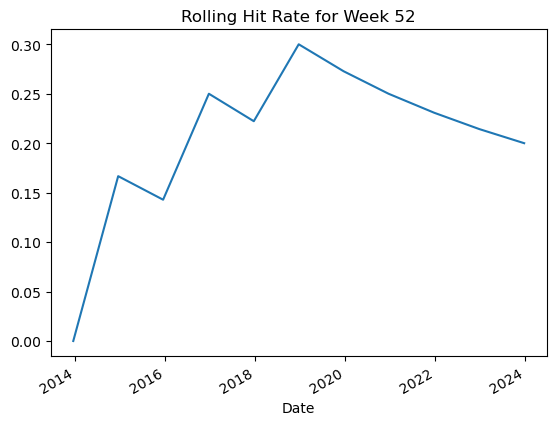

In [6]:
feats['w52']['Rolling_Hit_Rate'].plot(title='Rolling Hit Rate for Week 52')

<Axes: title={'center': 'Rolling Mean Return for Week 52'}, xlabel='Date'>

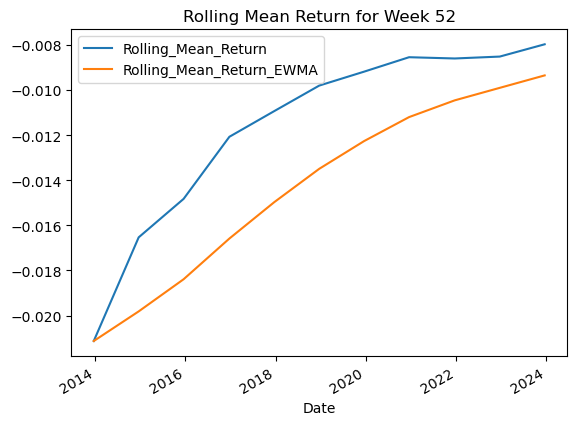

In [7]:
feats['w52'][['Rolling_Mean_Return', 'Rolling_Mean_Return_EWMA']].plot(title='Rolling Mean Return for Week 52')  


In [8]:
feats['w52']

ISO_Year  ISO_Week  Rolling_Mean_Return  Rolling_Hit_Rate  \
Date                                                                    
2009-12-18      2009        52                  NaN               NaN   
2010-12-23      2010        52                  NaN               NaN   
2011-12-23      2011        52                  NaN               NaN   
2012-12-21      2012        52                  NaN               NaN   
2013-12-20      2013        52                -0.02              0.00   
2014-12-19      2014        52                -0.02              0.17   
2015-12-18      2015        52                -0.01              0.14   
2016-12-23      2016        52                -0.01              0.25   
2017-12-22      2017        52                -0.01              0.22   
2018-12-21      2018        52                -0.01              0.30   
2019-12-20      2019        52                -0.01              0.27   
2020-12-18      2020        52                -0.01              0.25   
2021-12-23      2021        52                -0.01              0.23   
2022-12-23      2022        52                -0.01              0.21   
2023-12-22      2023        52                -0.01              0.20   

            Rolling_Skew  All_Weeks_Mean_Return  All_Weeks_Hit_Rate  \
Date                                                                  
2009-12-18           NaN                   0.00                0.60   
2010-12-23           NaN                   0.00                0.53   
2011-12-23           NaN                  -0.00                0.48   
2012-12-21           NaN                   0.00                0.51   
2013-12-20         -0.97                   0.00                0.52   
2014-12-19         -0.15                   0.00                0.57   
2015-12-18         -0.50                   0.00                0.57   
2016-12-23         -0.55                   0.00                0.58   
2017-12-22         -0.76                   0.00                0.60   
2018-12-21         -0.95                   0.00                0.60   
2019-12-20         -1.09                   0.00                0.60   
2020-12-18         -1.23                   0.00                0.57   
2021-12-23         -1.25                   0.00                0.57   
2022-12-23         -1.30                   0.00                0.54   
2023-12-22         -1.41                   0.00                0.55   

            All_Weeks_Skew  Rolling_Mean_Return_EWMA  Rolling_Hit_Rate_EWMA  \
Date                                                                          
2009-12-18           -1.08                       NaN                    NaN   
2010-12-23            0.50                       NaN                    NaN   
2011-12-23            1.88                       NaN                    NaN   
2012-12-21            1.31                       NaN                    NaN   
2013-12-20            1.37                     -0.02                   0.00   
2014-12-19            1.41                     -0.02                   0.05   
2015-12-18            1.47                     -0.02                   0.07   
2016-12-23            1.57                     -0.02                   0.12   
2017-12-22            0.96                     -0.01                   0.15   
2018-12-21           -0.51                     -0.01                   0.19   
2019-12-20           -0.54                     -0.01                   0.22   
2020-12-18           -0.47                     -0.01                   0.23   
2021-12-23           -0.45                     -0.01                   0.23   
2022-12-23           -0.08                     -0.01                   0.22   
2023-12-22           -0.05                     -0.01                   0.22   

            Rolling_Skew_EWMA  All_Weeks_Mean_Return_EWMA  \
Date                                                        
2009-12-18                NaN                        0.00   
2010-12-23                NaN      

In [9]:
df

Open  High   Low  Close  Volume        Name              Descr  \
Date                                                                         
2009-09-14   NaN   NaN   NaN    NaN   8,090  IK1 Comdty  Euro-BTP Future     
2009-09-15  43.5  43.7  43.3   43.5   6,065  IK1 Comdty  Euro-BTP Future     
2009-09-16  43.5  43.7  43.3   43.5   4,090  IK1 Comdty  Euro-BTP Future     
2009-09-17  43.2  43.4  43.1   43.3   4,662  IK1 Comdty  Euro-BTP Future     
2009-09-18  43.5  43.6  43.2   43.4   3,916  IK1 Comdty  Euro-BTP Future     
...          ...   ...   ...    ...     ...         ...                ...   
2024-11-26 120.5 120.9 120.4  120.7   7,555  IK1 Comdty  Euro-BTP Future     
2024-11-27 120.8 121.2 120.6  121.1  14,389  IK1 Comdty  Euro-BTP Future     
2024-11-28 121.2 121.8 121.1  121.7  31,474  IK1 Comdty  Euro-BTP Future     
2024-11-29 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     
2024-12-02 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     

            Carry_Close  Carry  BadOHLC  FX_Rate  Tick_Value_Base  \
Date                                                                
2009-09-14          NaN    NaN    False     1.46            1,000   
2009-09-15         84.5    NaN    False     1.47            1,000   
2009-09-16         84.4    NaN    False     1.47            1,000   
2009-09-17         84.3    NaN    False     1.47            1,000   
2009-09-18         84.4    NaN    False     1.47            1,000   
...                 ...    ...      ...      ...              ...   
2024-11-26        120.5   1.03    False     1.05            1,000   
2024-11-27        120.8   1.01    False     1.06            1,000   
2024-11-28        121.3   1.10    False     1.06            1,000   
2024-11-29        121.3   1.41    False     1.06            1,000   
2024-12-02        121.3   1.41    False     1.06            1,000   

            Tick_Value_USD  ISO_Week  ISO_Year  Daily_Return  Weekly_Return  
Date                                                                         
2009-09-14           1,462        38      2009           NaN          -0.00  
2009-09-15           1,466        38      2009           NaN          -0.00  
2009-09-16           1,471        38      2009         -0.00          -0.00  
2009-09-17           1,474        38      2009         -0.00          -0.00  
2009-09-18           1,471        39      2009          0.00           0.01  
...                    ...       ...       ...           ...            ...  
2024-11-26           1,049        48      2024          0.00           0.02  
2024-11-27           1,057        48      2024          0.00           0.02  
2024-11-28           1,055        48      2024          0.01           0.02  
2024-11-29           1,056        49      2024          0.00           0.00  
2024-12-02           1,056      <NA>      <NA>          0.00            NaN  

[3888 rows x 17 columns]

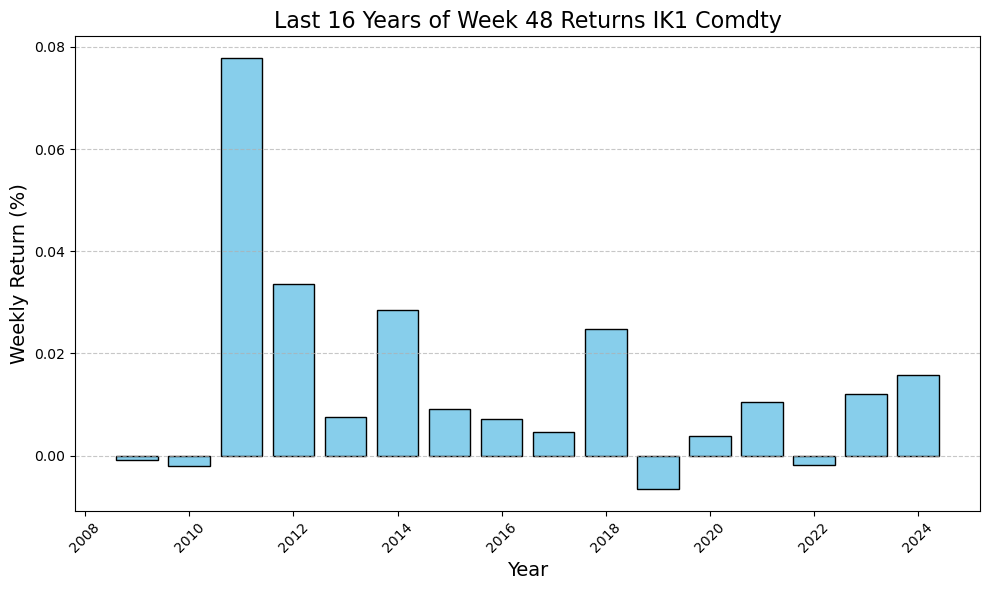

In [10]:
import matplotlib.pyplot as plt

def plot_weekly_returns(weekly_data, iso_week, num_years=10, asst=''):
    """
    Plots the returns for a specific ISO week over the last num_years.

    Parameters:
    - weekly_data: DataFrame containing 'Weekly_Return', 'ISO_Week', and 'ISO_Year'.
    - iso_week: The ISO week number to filter (e.g., 52 for week 52).
    - num_years: Number of years to look back.

    Returns:
    - A bar plot of the last num_years of ISO week returns.
    """
    # Filter the data for the specified ISO week
    week_data = weekly_data[weekly_data['ISO_Week'] == iso_week].copy()
    
    # Sort by ISO year and take the last num_years
    recent_week_data = week_data.sort_values('ISO_Year').tail(num_years)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(
        recent_week_data['ISO_Year'], 
        recent_week_data['Weekly_Return'], 
        color='skyblue', 
        edgecolor='black'
    )

    num_years = np.min([num_years, len(recent_week_data)])
    plt.title(f"Last {num_years} Years of Week {iso_week} Returns {asst}", fontsize=16)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Weekly Return (%)", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example Usage:
# Plot the last 10 years of week 52 returns
plot_weekly_returns(wklyret, iso_week=48, num_years=20, asst=tick)

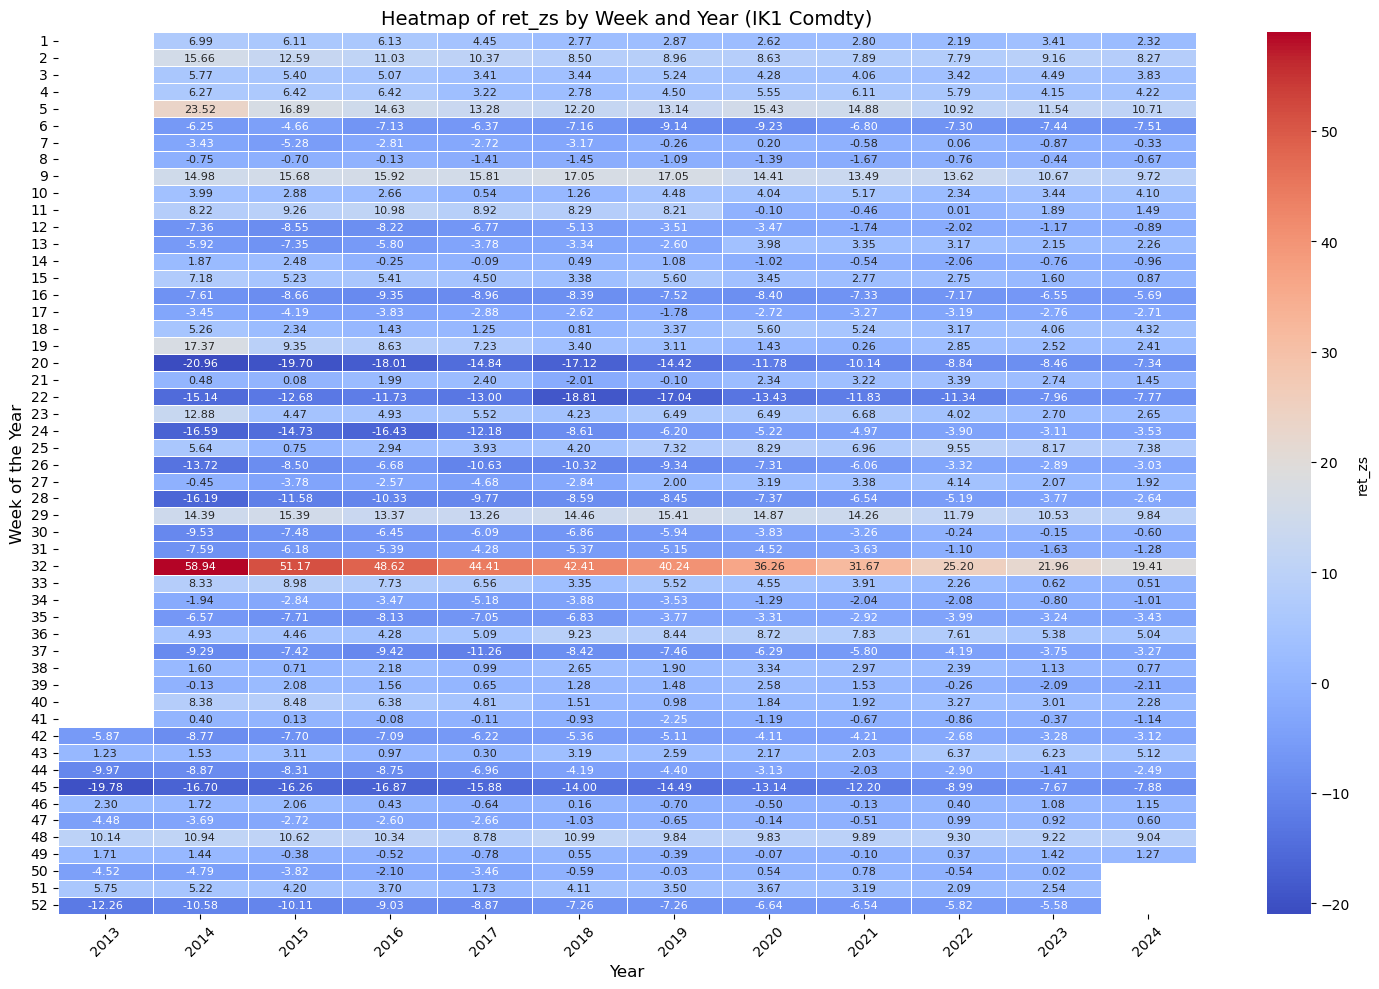

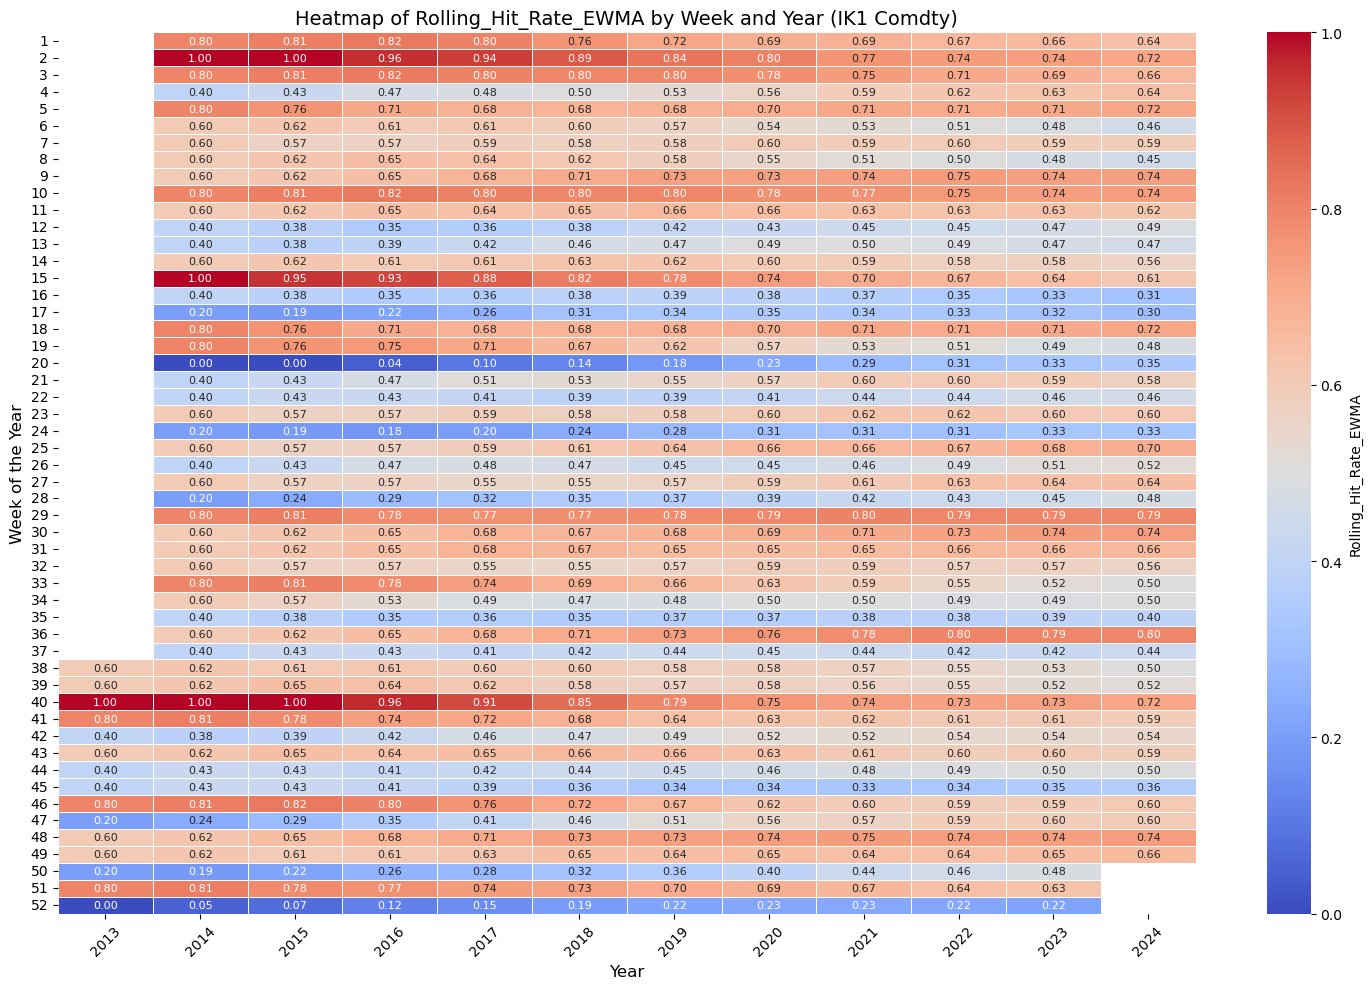

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_heatmap(feats, column_name, asst=''):
    """
    Plots a heatmap of a selected column from the feats dictionary.

    Parameters:
    - feats: Dictionary containing DataFrames for each week (e.g., feats['w1'], feats['w2'], ...).
    - column_name: The column name to use for heatmap values (e.g., 'Rolling_Mean_Return_EWMA').

    Returns:
    - Heatmap plot showing weeks as rows, years as columns, and values from the selected column.
    """
    # Initialize a DataFrame to hold the heatmap data
    heatmap_data = pd.DataFrame()

    # Populate the heatmap data
    for week_key, df in feats.items():
        week_number = int(week_key[1:])  # Extract the week number from the key (e.g., 'w1' -> 1)
        if column_name in df.columns:
            # Add the week column to the DataFrame
            df['Week'] = week_number
            # Append to the heatmap_data DataFrame
            heatmap_data = pd.concat([heatmap_data, df[['Week', 'ISO_Year', column_name]]], axis=0)

    # Pivot the DataFrame to get weeks as rows and years as columns
    heatmap_pivot = heatmap_data.pivot(index='Week', columns='ISO_Year', values=column_name)

    # Drop columns that are entirely NaN
    heatmap_pivot.dropna(axis=1, how='all', inplace=True)

    # Plot the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        heatmap_pivot,
        cmap="coolwarm",
        annot=True,  # Display values in cells
        fmt=".2f",  # Format for annotation
        cbar_kws={'label': column_name},
        linewidths=0.5,
        annot_kws={"size": 8},  # Set font size for annotations
    )
    plt.title(f"Heatmap of {column_name} by Week and Year ({asst})", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Week of the Year", fontsize=12)
    plt.yticks(rotation=0, fontsize=10)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

# Example Usage:
# Assuming feats is your dictionary of DataFrames and you want to plot 'Rolling_Mean_Return_EWMA'
plot_feature_heatmap(feats, column_name='ret_zs', asst=tick)
plot_feature_heatmap(feats, column_name='Rolling_Hit_Rate_EWMA', asst=tick)

In [12]:
# Generate a date range with business days
date_range = pd.date_range(start='2024-10-15', end='2025-01-01', freq='B')

# Create a DataFrame with the date range
business_days_df = pd.DataFrame(date_range, columns=['Date'])

# Add ISO week and ISO year columns
business_days_df['ISO_Week'] = business_days_df['Date'].dt.isocalendar().week
business_days_df['ISO_Year'] = business_days_df['Date'].dt.isocalendar().year
business_days_df.tail(20)

Date  ISO_Week  ISO_Year
37 2024-12-05        49      2024
38 2024-12-06        49      2024
39 2024-12-09        50      2024
40 2024-12-10        50      2024
41 2024-12-11        50      2024
42 2024-12-12        50      2024
43 2024-12-13        50      2024
44 2024-12-16        51      2024
45 2024-12-17        51      2024
46 2024-12-18        51      2024
47 2024-12-19        51      2024
48 2024-12-20        51      2024
49 2024-12-23        52      2024
50 2024-12-24        52      2024
51 2024-12-25        52      2024
52 2024-12-26        52      2024
53 2024-12-27        52      2024
54 2024-12-30         1      2025
55 2024-12-31         1      2025
56 2025-01-01         1      2025

In [13]:
def wkly_seasn_simple(
    df: pl.DataFrame,
    X_years: int = 5,
    ewma_span: int = 10,
    ret_type: str = 'pct',
    rm_outliers: float = 4.5,
    min_lb: int = 0,
    hr_threshold_long: list = [],
    hr_threshold_short: list = [],
    ret_threshold: list = [],
    risk_scale: list = [],
    wks_to_trade: list = [],
    vol_filter: float = (0,0,0),
    trend_filter: tuple = ('', 0),
    lag_day: int = 0,
    mthly_scale: list = [],
    trade_direction: str = 'both'
) -> pl.DataFrame:
    """
    Implements a trading rule based on weekly seasonality.

    Parameters:
    - df: Polars DataFrame with 'Date', 'Open', 'High', 'Low', 'Close' columns.
    - X_years: Lookback period for seasonality.
    - ewma_span: EWMA smoothing period.
    - ret_type: 'abs' for absolute returns, 'pct' for percentage returns.
    - rm_outliers: Threshold for outlier removal.
    - min_lb: Minimum lookback period for rolling calculations.
    - hr_threshold_long: Threshold for hit rate z-score to go long.
    - hr_threshold_short: Threshold for hit rate z-score to go short.
    - ret_threshold: Threshold for return z-score to validate the signal.

    Returns:
    - Polars DataFrame with columns: 'Signal', 'TradeEntry', 'TradeExit', 'InTrade'.
    """

    if len(hr_threshold_long) != len(hr_threshold_short) != len(ret_threshold):
        raise ValueError("hr_threshold_long, hr_threshold_short, and ret_threshold must be the same length.")

    if len(risk_scale) != len(ret_threshold) or len(risk_scale) == 0:
        risk_scale = [1] * len(ret_threshold)

    if len(mthly_scale) != 12:
        mthly_scale = [1] * 12
    
    # Generate seasonal features
    feats, wklyret, df = generate_seasonal_features(
        df, 
        X_years=X_years, 
        ewma_span=ewma_span, 
        ret_type=ret_type, 
        rm_outliers=rm_outliers, 
        min_lb=min_lb,
        lag_day=lag_day
    )
    

    if wks_to_trade == []:
        wks_to_trade = list(feats.keys())
    else:
        wks_to_trade = [f'w{w}' for w in wks_to_trade] 


    if vol_filter != (0,0,0):
        df['Volatility'] = df['Close'].pct_change().rolling(window=vol_filter[0]).std() * np.sqrt(252)
        df['Vol ZScore'] = (df['Volatility'] - df['Volatility'].rolling(window=vol_filter[1]).mean()) / df['Volatility'].rolling(window=vol_filter[1]).std()
        df['Vol Filter'] = df['Vol ZScore'] < vol_filter[2]
    else:
        df['Vol Filter'] = True


    if trend_filter[0] != '':
        if trend_filter[0] == 'MA':
            df['MA'] = df['Close'].rolling(window=trend_filter[1]).mean()
            df['tf_long'] = (df['Close'].shift(1) > df['MA']).shift(2)
            df['tf_short'] = df['Close'].shift(1) < df['MA'].shift(2)

        elif trend_filter[0] == 'EMA':
            df['MA'] = df['Close'].ewm(span=trend_filter[1]).mean()
            df['tf_short'] = df['Close'].shift(1) < df['MA'].shift(2)
            df['tf_long'] = df['Close'].shift(1) > df['MA'].shift(2)
    else:
        df['tf_long'] = True
        df['tf_short'] = True

    # Initialize columns for trading rule
    df['Signal'] = 0
    df['TradeEntry'] = None
    df['TradeExit'] = None
    df['InTrade'] = 0

    in_trade = False
    trade_start_date = None
    trade_end_date = None

    # Get a list of all dates for indexing
    all_dates = df.index

    for date in all_dates:
        row = df.loc[date]
        prev_row = df.loc[df.index[df.index.get_loc(date) - 1]]
        current_week = row['ISO_Week']
        current_year = row['ISO_Year']
        current_month = date.month
        
        week_key = f'w{current_week}'
        # Skip if the current week has no seasonal data
        if week_key not in feats:
            continue

        if week_key not in wks_to_trade:
            continue

        # Get the seasonal data for the current week up to the previous year
        seasonal_data = feats[week_key]
        seasonal_data = seasonal_data[seasonal_data['ISO_Year'] < current_year]

        # Skip if insufficient historical data
        if seasonal_data.empty:
            continue

        # Calculate current z-scores
        '''
        try:
            hr_zs = seasonal_data['Rolling_Hit_Rate_EWMA'].iloc[-2]
            ret_zs = seasonal_data['ret_zs'].iloc[-2]
        except:
            hr_zs = seasonal_data['Rolling_Hit_Rate_EWMA'].iloc[-1]
            ret_zs = seasonal_data['ret_zs'].iloc[-1]         
        '''   
        hr_zs = seasonal_data['Rolling_Hit_Rate_EWMA'].iloc[-1]
        ret_zs = seasonal_data['ret_zs'].iloc[-1]       
        # Determine trade direction (long or short)
        signal = 0

        if trade_direction in ['long', 'both']:
            for i in range(len(hr_threshold_long)):
                if hr_zs > hr_threshold_long[i] and ret_zs > ret_threshold[i] and row['Vol Filter'] and row['tf_long']:
                    signal = risk_scale[i]
        if trade_direction in ['short', 'both']:
            for i in range(len(hr_threshold_short)):
                if hr_zs < hr_threshold_short[i] and ret_zs < -ret_threshold[i] and row['Vol Filter'] and row['tf_short']:
                    signal = -risk_scale[i]

        if trade_direction not in ['long', 'short', 'both']:
            raise ValueError("Invalid trade_direction. Must be 'long', 'short', or 'both'.")

        # Only update signal if not already in a trade
        if not in_trade and signal != 0:
            # Enter trade at the close of the first trading day of the current week
            current_week_data = df[(df['ISO_Week'] == current_week) & (df['ISO_Year'] == current_year)]

            if not current_week_data.empty and len(current_week_data) > 1:
                trade_entry_date = current_week_data.index[0]  # First trading day of current week
                previous_date = df.index[df.index.get_loc(trade_entry_date) - 1]
                df.loc[trade_entry_date, 'TradeEntry'] = df.loc[previous_date, 'Close']
                df.loc[trade_entry_date, 'Signal'] = signal
                in_trade = True
                trade_start_date = trade_entry_date

                # Determine trade exit date (last trading day of the current week)
                trade_exit_date = current_week_data.index[-1]
                trade_end_date = trade_exit_date
                df.loc[trade_exit_date, 'TradeExit'] = df.loc[trade_exit_date, 'Close']
    
                # Set InTrade for the duration of the trade
                df.loc[trade_start_date:trade_end_date, 'InTrade'] = signal * mthly_scale[current_month - 1]
                df.loc[trade_end_date,'Signal'] = - signal


        # Reset in_trade status after trade ends
        if in_trade and date == trade_end_date:
            in_trade = False
            trade_start_date = None
            trade_end_date = None
            df.loc[trade_end_date,'Signal'] = - signal


    df.drop(['Daily_Return','Weekly_Return'], axis=1, errors='ignore', inplace=True)

    # Convert back to Polars DataFrame
    return pl.from_pandas(df.reset_index())

In [14]:
# Assuming `gold_prices` is a Polars DataFrame with required columns
result = wkly_seasn_simple(
    test_df, 
    X_years=6, 
    ewma_span=6, 
    hr_threshold_long=[1.9], 
    hr_threshold_short=[-1.9], 
    ret_threshold=[1.0],
    lag_day=0
)

# Display the resulting DataFrame
print(result)

shape: (3_888, 23)
┌─────────────────────┬────────┬────────┬────────┬───┬────────┬────────────┬───────────┬─────────┐
│ Date                ┆ Open   ┆ High   ┆ Low    ┆ … ┆ Signal ┆ TradeEntry ┆ TradeExit ┆ InTrade │
│ ---                 ┆ ---    ┆ ---    ┆ ---    ┆   ┆ ---    ┆ ---        ┆ ---       ┆ ---     │
│ datetime[ns]        ┆ f64    ┆ f64    ┆ f64    ┆   ┆ i64    ┆ str        ┆ str       ┆ i64     │
╞═════════════════════╪════════╪════════╪════════╪═══╪════════╪════════════╪═══════════╪═════════╡
│ 2009-09-14 00:00:00 ┆ null   ┆ null   ┆ null   ┆ … ┆ 0      ┆ null       ┆ null      ┆ 0       │
│ 2009-09-15 00:00:00 ┆ 43.51  ┆ 43.74  ┆ 43.33  ┆ … ┆ 0      ┆ null       ┆ null      ┆ 0       │
│ 2009-09-16 00:00:00 ┆ 43.48  ┆ 43.72  ┆ 43.31  ┆ … ┆ 0      ┆ null       ┆ null      ┆ 0       │
│ 2009-09-17 00:00:00 ┆ 43.23  ┆ 43.4   ┆ 43.14  ┆ … ┆ 0      ┆ null       ┆ null      ┆ 0       │
│ 2009-09-18 00:00:00 ┆ 43.48  ┆ 43.61  ┆ 43.17  ┆ … ┆ 0      ┆ null       ┆ null      ┆ 0

In [15]:
result.to_pandas().to_clipboard()

pSizeParamsUse = {
    'AssetVol': 1000000,  # Target asset volatility in USD
    'VolLookBack': 30,
    'VolMethod': 'ewm'  # Lookback period for volatility calculation
}

In [16]:

hr_t_long = [0.55, 0.72]
hr_t_short = [0.45, 0.28]
ret_t = [1.5, 1.25]
risk_scale = [1, 2]

#hr_t_long = [0.55]
#hr_t_short = [0.45]
#ret_t = [1.74]

params_b ={
    'X_years': 6,
    'ewma_span': 5,
    'hr_threshold_long': hr_t_long,
    'hr_threshold_short': hr_t_short,
    'ret_threshold': ret_t,
    'min_lb': 5,
    'wks_to_trade': [], # [2,3,6,9,10,11,15,16,22,27,32,34,36, 37,40, 41,42,44,45,46,47,48,52],
    'vol_filter': (21, 42, 0.7),
    'trend_filter': ('EMA',21),
    'trade_direction': 'both',
    'risk_scale': risk_scale
}

params_b_nors = {
    'X_years': 6,
    'ewma_span': 5,
    'hr_threshold_long': hr_t_long,
    'hr_threshold_short': hr_t_short,
    'ret_threshold': ret_t,
    'min_lb': 5,
    'wks_to_trade': [], # [2,3,6,9,10,11,15,16,22,27,32,34,36, 37,40, 41,42,44,45,46,47,48,52],
    'vol_filter': (21, 42, 0.7),
    'trend_filter': ('EMA',21),
    'trade_direction': 'both'
}

params_l ={
    'X_years': 6,
    'ewma_span': 5,
    'hr_threshold_long': hr_t_long,
    'hr_threshold_short': hr_t_short,
    'ret_threshold': ret_t,
    'min_lb': 5,
    'wks_to_trade': [], # [2,3,6,9,10,11,15,16,22,27,32,34,36, 37,40, 41,42,44,45,46,47,48,52],
    'vol_filter': (21, 42, 0.7),
    'trend_filter': ('EMA',21),
    'trade_direction': 'long',
    'risk_scale': risk_scale
}

params_s ={
    'X_years': 6,
    'ewma_span': 5,
    'hr_threshold_long': hr_t_long,
    'hr_threshold_short': hr_t_short,
    'ret_threshold': ret_t,
    'min_lb': 5,
    'wks_to_trade': [], # [2,3,6,9,10,11,15,16,22,27,32,34,36, 37,40, 41,42,44,45,46,47,48,52],
    'vol_filter': (21, 42, 0.7),
    'trend_filter': ('EMA',21),
    'trade_direction': 'short',
    'risk_scale': risk_scale
}

params_b_lowhr = {
    'X_years': 5,
    'ewma_span': 5,
    'hr_threshold_long': [hr_t_long[0]],
    'hr_threshold_short': [hr_t_short[0]],
    'ret_threshold': [ret_t[0]],
    'min_lb': 5,
    'wks_to_trade': [], # [2,3,6,9,10,11,15,16,22,27,32,34,36, 37,40, 41,42,44,45,46,47,48,52],
    'vol_filter': (21, 42, 0.7),
    'trend_filter': ('EMA',21),
    'trade_direction': 'both',
    'risk_scale': [risk_scale[0]]
}


params_b_hihr = {
    'X_years': 5,
    'ewma_span': 5,
    'hr_threshold_long': [hr_t_long[1]],
    'hr_threshold_short': [hr_t_short[1]],
    'ret_threshold': [ret_t[1]],
    'min_lb': 5,
    'wks_to_trade': [], # [2,3,6,9,10,11,15,16,22,27,32,34,36, 37,40, 41,42,44,45,46,47,48,52],
    'vol_filter': (21, 42, 0.7),
    'trend_filter': ('EMA',21),
    'trade_direction': 'both',
    'risk_scale': [risk_scale[1]]
}

excl_list = ['ES1 Index', 'RTY1 Index', 'UX2 Index'] + asset_classes['comm-soft'] + asset_classes['fx-dm'] + asset_classes['fx-em'],

wklySeasn_b = TradingRule(
    market_data=market_data,
    trading_rule_function=wkly_seasn_simple,
    trading_params=params_b,
    position_sizing_params=pSizeParamsUse,
    cont_rule=False,
    bt_folder=bt_folder,
    excl_assets=['comm-soft'],
    strat_descr='Weekly Seasonality Strategy Long/Short with TF (21 EMA) and Vol Filter (21, 42, 0.7), Hi+Lo HR (1:2)'
    
)

wklySeasn_b_nos = TradingRule(
    market_data=market_data,
    trading_rule_function=wkly_seasn_simple,
    trading_params=params_b_nors,
    position_sizing_params=pSizeParamsUse,
    cont_rule=False,
    bt_folder=bt_folder,
    excl_assets=['comm-soft'],
    strat_descr='Weekly Seasonality Strategy Long/Short with TF (21 EMA) and Vol Filter (21, 42, 0.7), Hi+Lo HR (1:1)'
    
)

wklySeasn_b_low = TradingRule(
    market_data=market_data,
    trading_rule_function=wkly_seasn_simple,
    trading_params=params_b_lowhr,
    position_sizing_params=pSizeParamsUse,
    cont_rule=False,
    bt_folder=bt_folder,
    excl_assets=['comm-soft'],
    strat_descr='Weekly Seasonality Low HR Strategy Long/Short with TF (21 EMA) and Vol Filter (21, 42, 0.7)'
    
)

wklySeasn_b_hi = TradingRule(
    market_data=market_data,
    trading_rule_function=wkly_seasn_simple,
    trading_params=params_b_hihr,
    position_sizing_params=pSizeParamsUse,
    cont_rule=False,
    bt_folder=bt_folder,
    excl_assets=['comm-soft'],
    strat_descr='Weekly Seasonality High HR Strategy Long/Short with TF (21 EMA) and Vol Filter (21, 42, 0.7)'
    
)

wklySeasn_l = TradingRule(
    market_data=market_data,
    trading_rule_function=wkly_seasn_simple,
    trading_params=params_l,
    position_sizing_params=pSizeParamsUse,
    cont_rule=False,
    bt_folder=bt_folder,
    excl_assets=['comm-soft'],
    strat_descr='Weekly Seasonality Strategy Long with TF (21 EMA) and Vol Filter (21, 42, 0.7)'
)


wklySeasn_s = TradingRule(
    market_data=market_data,
    trading_rule_function=wkly_seasn_simple,
    trading_params=params_s,
    position_sizing_params=pSizeParamsUse,
    cont_rule=False,
    bt_folder=bt_folder,
    excl_assets=['comm-soft'],
    strat_descr='Weekly Seasonality Strategy Short with TF (21 EMA) and Vol Filter (21, 42, 0.7)'
)



In [17]:
DoWrules = {}

    
hr_t_long = [0.55, 0.72]
hr_t_short = [0.45, 0.28]
ret_t = [1.5, 1.25]
risk_scale = [1, 2]

daysofwk = ['fri', 'thu', 'wed', 'tue', 'mon']

excl_list = ['ES1 Index', 'RTY1 Index', 'UX2 Index'] + asset_classes['comm-soft'] + asset_classes['fx-dm'] + asset_classes['fx-em'],

for i in range(5):
    params_tmp ={
        'X_years': 5,
        'ewma_span': 5,
        'hr_threshold_long': hr_t_long,
        'hr_threshold_short': hr_t_short,
        'ret_threshold': ret_t,
        'min_lb': 5,
        'wks_to_trade': [], # [2,3,6,9,10,11,15,16,22,27,32,34,36, 37,40, 41,42,44,45,46,47,48,52],
        'vol_filter': (21, 42, 0.7),
        'trend_filter': ('EMA',21),
        'trade_direction': 'both',
        'risk_scale': risk_scale,
        'lag_day':-i
    }

    wklySeasn_tmp = TradingRule(
        market_data=market_data,
        trading_rule_function=wkly_seasn_simple,
        trading_params=params_tmp,
        position_sizing_params=pSizeParamsUse,
        cont_rule=False,
        bt_folder=bt_folder,
        excl_assets=['comm-soft'],
        strat_descr=f'Weekly ({daysofwk[i]}-{daysofwk[i]}) Seasonality Strategy Long/Short with TF (21 EMA) and Vol Filter (21, 42, 0.7), Hi+Lo HR (1:2)'
    )

    DoWrules[daysofwk[i]] = wklySeasn_tmp

DoWrules

        


{'fri': <btEngine2.TradingRule.TradingRule at 0x30ed60e00>,
 'thu': <btEngine2.TradingRule.TradingRule at 0x30e3b2a80>,
 'wed': <btEngine2.TradingRule.TradingRule at 0x30ed62bd0>,
 'tue': <btEngine2.TradingRule.TradingRule at 0x30ed60410>,
 'mon': <btEngine2.TradingRule.TradingRule at 0x31946be00>}

Open  High   Low  Close  Volume        Name              Descr  \
Date                                                                         
2024-11-19 119.9 120.3 119.5  119.9 265,338  IK1 Comdty  Euro-BTP Future     
2024-11-20 119.7 119.8 119.2  119.6 223,877  IK1 Comdty  Euro-BTP Future     
2024-11-21 119.5 119.9 119.3  119.8 266,226  IK1 Comdty  Euro-BTP Future     
2024-11-22 119.7 120.4 119.6  120.3   2,206  IK1 Comdty  Euro-BTP Future     
2024-11-25 120.5 120.7 120.0  120.7   2,604  IK1 Comdty  Euro-BTP Future     
2024-11-26 120.5 120.9 120.4  120.7   7,555  IK1 Comdty  Euro-BTP Future     
2024-11-27 120.8 121.2 120.6  121.1  14,389  IK1 Comdty  Euro-BTP Future     
2024-11-28 121.2 121.8 121.1  121.7  31,474  IK1 Comdty  Euro-BTP Future     
2024-11-29 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     
2024-12-02 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     

            Carry_Close  Carry BadOHLC  ...  USD_PnL_1lot  RollingStdDev  \
Date                                    ...                                
2024-11-19        119.6   0.96   False  ...         233.1          468.2   
2024-11-20        119.3   0.95   False  ...        -326.9          460.9   
2024-11-21        119.5   0.95   False  ...         240.9          450.0   
2024-11-22        119.7   1.10   False  ...         489.6          451.4   
2024-11-25        120.5   1.05   False  ...          0.00          447.8   
2024-11-26        120.5   1.03   False  ...         440.5          433.5   
2024-11-27        120.8   1.01   False  ...         401.5          427.7   
2024-11-28        121.3   1.10   False  ...         654.2          437.4   
2024-11-29        121.3   1.41   False  ...         496.1          433.3   
2024-12-02        121.3   1.41   False  ...          0.00          420.7   

            AnnualizedVol_1lot  USD_Notional  20d_Price_Vol  PositionPnL_USD  \
Date                                                                           
2024-11-19               7,432          0.00           0.41           30,538   
2024-11-20               7,317          0.00           0.41          -44,127   
2024-11-21               7,143          0.00           0.41           33,004   
2024-11-22               7,165          0.00           0.38           68,550   
2024-11-25               7,109    35,080,323           0.39             0.00   
2024-11-26               6,881    35,592,029           0.40           62,116   
2024-11-27               6,789    36,708,563           0.37           58,219   
2024-11-28               6,944    37,606,127           0.34           96,171   
2024-11-29               6,878    36,978,260           0.35           71,443   
2024-12-02               6,678          0.00           0.35             0.00   

            Strategy_PnL_USD Strategy_Equity_USD  Num_Lots         Trade_ID  
Date                                                                         
2024-11-19              0.00          13,694,352      0.00                   
2024-11-20             -0.00          13,694,352      0.00                   
2024-11-21              0.00          13,694,352      0.00                   
2024-11-22              0.00          13,694,352      0.00                   
2024-11-25              0.00          13,694,352     280.0  f500_IK1Com_137  
2024-11-26           124,232          13,818,583     282.0  f500_IK1Com_137  
2024-11-27           116,437          13,935,021     290.0  f500_IK1Com_137  
2024-11-28           192,342          14,127,362     294.0  f500_IK1Com_137  
2024-11-29           142,886          14,270,249     288.0  f500_IK1Com_137  
2024-12-02              0.00          14,270,249      0.00                   

[10 rows x 37 columns]

Open  High   Low  Close  Volume        Name              Descr  \
Date                                                                         
2024-11-19 119.9 120.3 119.5  119.9 265,338  IK1 Comdty  Euro-BTP Future     
2024-11-20 119.7 119.8 119.2  119.6 223,877  IK1 Comdty  Euro-BTP Future     
2024-11-21 119.5 119.9 119.3  119.8 266,226  IK1 Comdty  Euro-BTP Future     
2024-11-22 119.7 120.4 119.6  120.3   2,206  IK1 Comdty  Euro-BTP Future     
2024-11-25 120.5 120.7 120.0  120.7   2,604  IK1 Comdty  Euro-BTP Future     
2024-11-26 120.5 120.9 120.4  120.7   7,555  IK1 Comdty  Euro-BTP Future     
2024-11-27 120.8 121.2 120.6  121.1  14,389  IK1 Comdty  Euro-BTP Future     
2024-11-28 121.2 121.8 121.1  121.7  31,474  IK1 Comdty  Euro-BTP Future     
2024-11-29 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     
2024-12-02 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     

            Carry_Close  Carry BadOHLC  ...  USD_PnL_1lot  RollingStdDev  \
Date                                    ...                                
2024-11-19        119.6   0.96   False  ...         233.1          468.2   
2024-11-20        119.3   0.95   False  ...        -326.9          460.9   
2024-11-21        119.5   0.95   False  ...         240.9          450.0   
2024-11-22        119.7   1.10   False  ...          0.00          451.4   
2024-11-25        120.5   1.05   False  ...         934.1          447.8   
2024-11-26        120.5   1.03   False  ...          0.00          433.5   
2024-11-27        120.8   1.01   False  ...         401.5          427.7   
2024-11-28        121.3   1.10   False  ...         654.2          437.4   
2024-11-29        121.3   1.41   False  ...         496.1          433.3   
2024-12-02        121.3   1.41   False  ...          0.00          420.7   

            AnnualizedVol_1lot  USD_Notional  20d_Price_Vol  PositionPnL_USD  \
Date                                                                           
2024-11-19               7,432          0.00           0.41           30,538   
2024-11-20               7,317          0.00           0.41          -44,127   
2024-11-21               7,143          0.00           0.41           33,004   
2024-11-22               7,165    35,131,053           0.38             0.00   
2024-11-25               7,109    34,943,222           0.39          130,768   
2024-11-26               6,881    35,716,332           0.40             0.00   
2024-11-27               6,789    36,708,563           0.37           58,219   
2024-11-28               6,944    37,606,127           0.34           96,171   
2024-11-29               6,878          0.00           0.35           71,443   
2024-12-02               6,678          0.00           0.35             0.00   

            Strategy_PnL_USD Strategy_Equity_USD  Num_Lots         Trade_ID  
Date                                                                         
2024-11-19              0.00          11,373,823      0.00                   
2024-11-20             -0.00          11,373,823      0.00                   
2024-11-21              0.00          11,373,823      0.00                   
2024-11-22              0.00          11,373,823     280.0  6ccd_IK1Com_170  
2024-11-25           261,535          11,635,359     280.0  6ccd_IK1Com_170  
2024-11-26              0.00          11,635,359     282.0  6ccd_IK1Com_170  
2024-11-27           116,437          11,751,796     290.0  6ccd_IK1Com_170  
2024-11-28           192,342          11,944,138     294.0  6ccd_IK1Com_170  
2024-11-29              0.00          11,944,138      0.00                   
2024-12-02              0.00          11,944,138      0.00                   

[10 rows x 37 columns]

Open  High   Low  Close  Volume        Name              Descr  \
Date                                                                         
2024-11-19 119.9 120.3 119.5  119.9 265,338  IK1 Comdty  Euro-BTP Future     
2024-11-20 119.7 119.8 119.2  119.6 223,877  IK1 Comdty  Euro-BTP Future     
2024-11-21 119.5 119.9 119.3  119.8 266,226  IK1 Comdty  Euro-BTP Future     
2024-11-22 119.7 120.4 119.6  120.3   2,206  IK1 Comdty  Euro-BTP Future     
2024-11-25 120.5 120.7 120.0  120.7   2,604  IK1 Comdty  Euro-BTP Future     
2024-11-26 120.5 120.9 120.4  120.7   7,555  IK1 Comdty  Euro-BTP Future     
2024-11-27 120.8 121.2 120.6  121.1  14,389  IK1 Comdty  Euro-BTP Future     
2024-11-28 121.2 121.8 121.1  121.7  31,474  IK1 Comdty  Euro-BTP Future     
2024-11-29 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     
2024-12-02 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     

            Carry_Close  Carry BadOHLC  ...  USD_PnL_1lot  RollingStdDev  \
Date                                    ...                                
2024-11-19        119.6   0.96   False  ...         233.1          468.2   
2024-11-20        119.3   0.95   False  ...        -326.9          460.9   
2024-11-21        119.5   0.95   False  ...          0.00          450.0   
2024-11-22        119.7   1.10   False  ...         729.3          451.4   
2024-11-25        120.5   1.05   False  ...         440.8          447.8   
2024-11-26        120.5   1.03   False  ...          0.00          433.5   
2024-11-27        120.8   1.01   False  ...         401.5          427.7   
2024-11-28        121.3   1.10   False  ...         654.2          437.4   
2024-11-29        121.3   1.41   False  ...         496.1          433.3   
2024-12-02        121.3   1.41   False  ...          0.00          420.7   

            AnnualizedVol_1lot  USD_Notional  20d_Price_Vol  PositionPnL_USD  \
Date                                                                           
2024-11-19               7,432    16,611,464           0.41           30,538   
2024-11-20               7,317    17,146,924           0.41          -44,127   
2024-11-21               7,143    17,270,777           0.41             0.00   
2024-11-22               7,165    17,531,800           0.38          102,096   
2024-11-25               7,109    17,540,162           0.39           61,711   
2024-11-26               6,881    17,858,166           0.40             0.00   
2024-11-27               6,789    18,354,282           0.37           58,219   
2024-11-28               6,944          0.00           0.34           96,171   
2024-11-29               6,878          0.00           0.35           71,443   
2024-12-02               6,678          0.00           0.35             0.00   

            Strategy_PnL_USD Strategy_Equity_USD  Num_Lots         Trade_ID  
Date                                                                         
2024-11-19            30,538           7,571,278     131.0  6427_IK1Com_161  
2024-11-20           -44,127           7,527,151     135.0  6427_IK1Com_161  
2024-11-21              0.00           7,527,151     137.0  6427_IK1Com_162  
2024-11-22           102,096           7,629,248     140.0  6427_IK1Com_162  
2024-11-25            61,711           7,690,958     140.0  6427_IK1Com_162  
2024-11-26              0.00           7,690,958     141.0  6427_IK1Com_162  
2024-11-27            58,219           7,749,177     145.0  6427_IK1Com_162  
2024-11-28              0.00           7,749,177      0.00                   
2024-11-29              0.00           7,749,177      0.00                   
2024-12-02              0.00           7,749,177      0.00                   

[10 rows x 37 columns]

Open  High   Low  Close  Volume        Name              Descr  \
Date                                                                         
2024-11-19 119.9 120.3 119.5  119.9 265,338  IK1 Comdty  Euro-BTP Future     
2024-11-20 119.7 119.8 119.2  119.6 223,877  IK1 Comdty  Euro-BTP Future     
2024-11-21 119.5 119.9 119.3  119.8 266,226  IK1 Comdty  Euro-BTP Future     
2024-11-22 119.7 120.4 119.6  120.3   2,206  IK1 Comdty  Euro-BTP Future     
2024-11-25 120.5 120.7 120.0  120.7   2,604  IK1 Comdty  Euro-BTP Future     
2024-11-26 120.5 120.9 120.4  120.7   7,555  IK1 Comdty  Euro-BTP Future     
2024-11-27 120.8 121.2 120.6  121.1  14,389  IK1 Comdty  Euro-BTP Future     
2024-11-28 121.2 121.8 121.1  121.7  31,474  IK1 Comdty  Euro-BTP Future     
2024-11-29 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     
2024-12-02 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     

            Carry_Close  Carry BadOHLC  ...  USD_PnL_1lot  RollingStdDev  \
Date                                    ...                                
2024-11-19        119.6   0.96   False  ...         233.1          468.2   
2024-11-20        119.3   0.95   False  ...        -326.9          460.9   
2024-11-21        119.5   0.95   False  ...         240.9          450.0   
2024-11-22        119.7   1.10   False  ...         489.6          451.4   
2024-11-25        120.5   1.05   False  ...         440.8          447.8   
2024-11-26        120.5   1.03   False  ...          0.00          433.5   
2024-11-27        120.8   1.01   False  ...         401.5          427.7   
2024-11-28        121.3   1.10   False  ...         654.2          437.4   
2024-11-29        121.3   1.41   False  ...         496.1          433.3   
2024-12-02        121.3   1.41   False  ...          0.00          420.7   

            AnnualizedVol_1lot  USD_Notional  20d_Price_Vol  PositionPnL_USD  \
Date                                                                           
2024-11-19               7,432    16,611,464           0.41           30,538   
2024-11-20               7,317          0.00           0.41          -44,127   
2024-11-21               7,143          0.00           0.41           33,004   
2024-11-22               7,165          0.00           0.38           68,550   
2024-11-25               7,109          0.00           0.39           61,711   
2024-11-26               6,881          0.00           0.40             0.00   
2024-11-27               6,789          0.00           0.37           58,219   
2024-11-28               6,944          0.00           0.34           96,171   
2024-11-29               6,878          0.00           0.35           71,443   
2024-12-02               6,678          0.00           0.35             0.00   

            Strategy_PnL_USD Strategy_Equity_USD  Num_Lots         Trade_ID  
Date                                                                         
2024-11-19            30,538           7,549,648     131.0  51a6_IK1Com_153  
2024-11-20             -0.00           7,549,648      0.00                   
2024-11-21              0.00           7,549,648      0.00                   
2024-11-22              0.00           7,549,648      0.00                   
2024-11-25              0.00           7,549,648      0.00                   
2024-11-26              0.00           7,549,648      0.00                   
2024-11-27              0.00           7,549,648      0.00                   
2024-11-28              0.00           7,549,648      0.00                   
2024-11-29              0.00           7,549,648      0.00                   
2024-12-02              0.00           7,549,648      0.00                   

[10 rows x 37 columns]

Open  High   Low  Close  Volume        Name              Descr  \
Date                                                                         
2024-11-19 119.9 120.3 119.5  119.9 265,338  IK1 Comdty  Euro-BTP Future     
2024-11-20 119.7 119.8 119.2  119.6 223,877  IK1 Comdty  Euro-BTP Future     
2024-11-21 119.5 119.9 119.3  119.8 266,226  IK1 Comdty  Euro-BTP Future     
2024-11-22 119.7 120.4 119.6  120.3   2,206  IK1 Comdty  Euro-BTP Future     
2024-11-25 120.5 120.7 120.0  120.7   2,604  IK1 Comdty  Euro-BTP Future     
2024-11-26 120.5 120.9 120.4  120.7   7,555  IK1 Comdty  Euro-BTP Future     
2024-11-27 120.8 121.2 120.6  121.1  14,389  IK1 Comdty  Euro-BTP Future     
2024-11-28 121.2 121.8 121.1  121.7  31,474  IK1 Comdty  Euro-BTP Future     
2024-11-29 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     
2024-12-02 121.9 122.2 121.8  122.2  62,739  IK1 Comdty  Euro-BTP Future     

            Carry_Close  Carry BadOHLC  ...  USD_PnL_1lot  RollingStdDev  \
Date                                    ...                                
2024-11-19        119.6   0.96   False  ...         233.1          468.2   
2024-11-20        119.3   0.95   False  ...        -326.9          460.9   
2024-11-21        119.5   0.95   False  ...         240.9          450.0   
2024-11-22        119.7   1.10   False  ...         489.6          451.4   
2024-11-25        120.5   1.05   False  ...         440.8          447.8   
2024-11-26        120.5   1.03   False  ...          0.00          433.5   
2024-11-27        120.8   1.01   False  ...         401.5          427.7   
2024-11-28        121.3   1.10   False  ...         654.2          437.4   
2024-11-29        121.3   1.41   False  ...         496.1          433.3   
2024-12-02        121.3   1.41   False  ...          0.00          420.7   

            AnnualizedVol_1lot  USD_Notional  20d_Price_Vol  PositionPnL_USD  \
Date                                                                           
2024-11-19               7,432          0.00           0.41           30,538   
2024-11-20               7,317          0.00           0.41          -44,127   
2024-11-21               7,143          0.00           0.41           33,004   
2024-11-22               7,165          0.00           0.38           68,550   
2024-11-25               7,109          0.00           0.39           61,711   
2024-11-26               6,881          0.00           0.40             0.00   
2024-11-27               6,789          0.00           0.37           58,219   
2024-11-28               6,944          0.00           0.34           96,171   
2024-11-29               6,878          0.00           0.35           71,443   
2024-12-02               6,678          0.00           0.35             0.00   

            Strategy_PnL_USD Strategy_Equity_USD  Num_Lots Trade_ID  
Date                                                                 
2024-11-19              0.00          10,521,749      0.00           
2024-11-20             -0.00          10,521,749      0.00           
2024-11-21              0.00          10,521,749      0.00           
2024-11-22              0.00          10,521,749      0.00           
2024-11-25              0.00          10,521,749      0.00           
2024-11-26              0.00          10,521,749      0.00           
2024-11-27              0.00          10,521,749      0.00           
2024-11-28              0.00          10,521,749      0.00           
2024-11-29              0.00          10,521,749      0.00           
2024-12-02              0.00          10,521,749      0.00           

[10 rows x 37 columns]

fri   1.57
thu   1.36
wed   0.88
tue   0.82
mon   1.21
dtype: float64


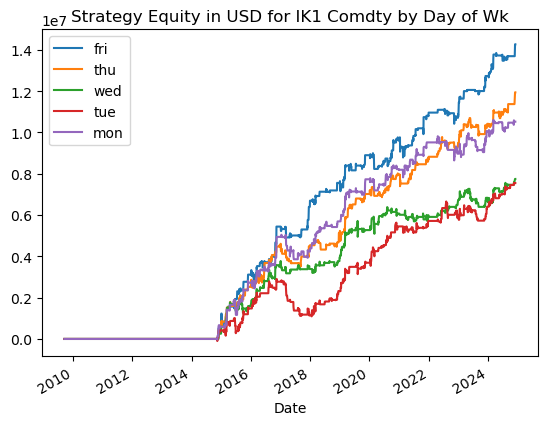

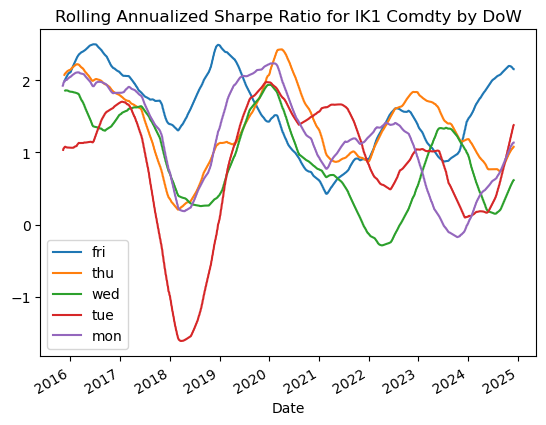

In [18]:
asst = 'IK1 Comdty'
res_dict_dow = {}

for wkday in daysofwk:
    tr_tmp = DoWrules[wkday]
    bt_tmp = tr_tmp.backtest_asset(asst)
    bt_tmp.set_index('Date', inplace=True)
    res_dict_dow[wkday] = bt_tmp['Strategy_Equity_USD']
    display(bt_tmp.tail(10))

dow_pd = pd.DataFrame(res_dict_dow)


dow_pd.plot(title=f'Strategy Equity in USD for {asst} by Day of Wk')

asst_pnl_df = dow_pd.diff()

# Calculate the rolling annualized Sharpe ratio for each column in asst_pnl_df
rolling_sharpe = asst_pnl_df.rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))
rolling_sharpe = rolling_sharpe.rolling(window=252).mean()
# Plot the rolling annualized Sharpe ratio
rolling_sharpe.plot(title=f'Rolling Annualized Sharpe Ratio for {asst} by DoW')
print(rolling_sharpe.mean())

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


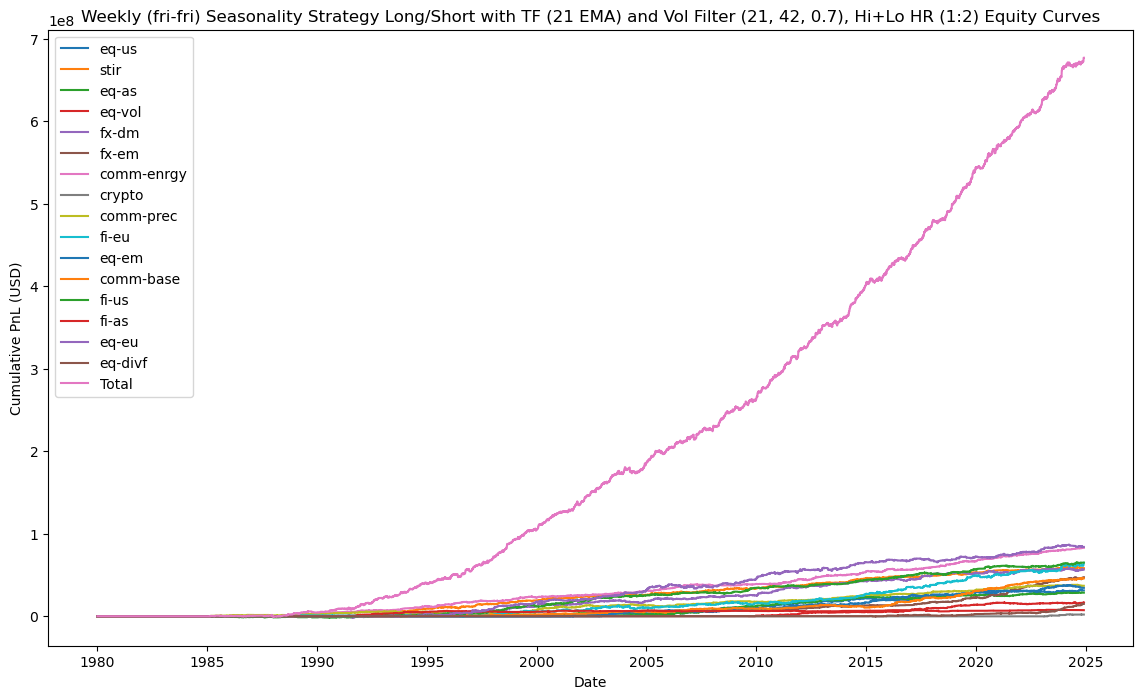

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


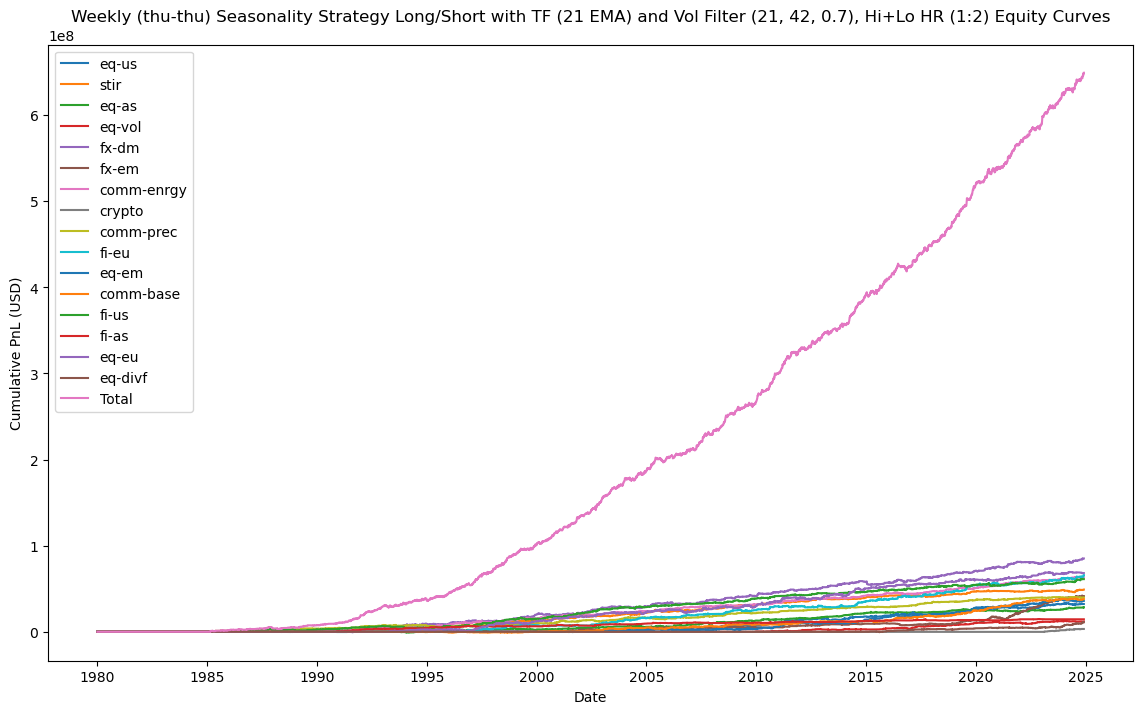

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


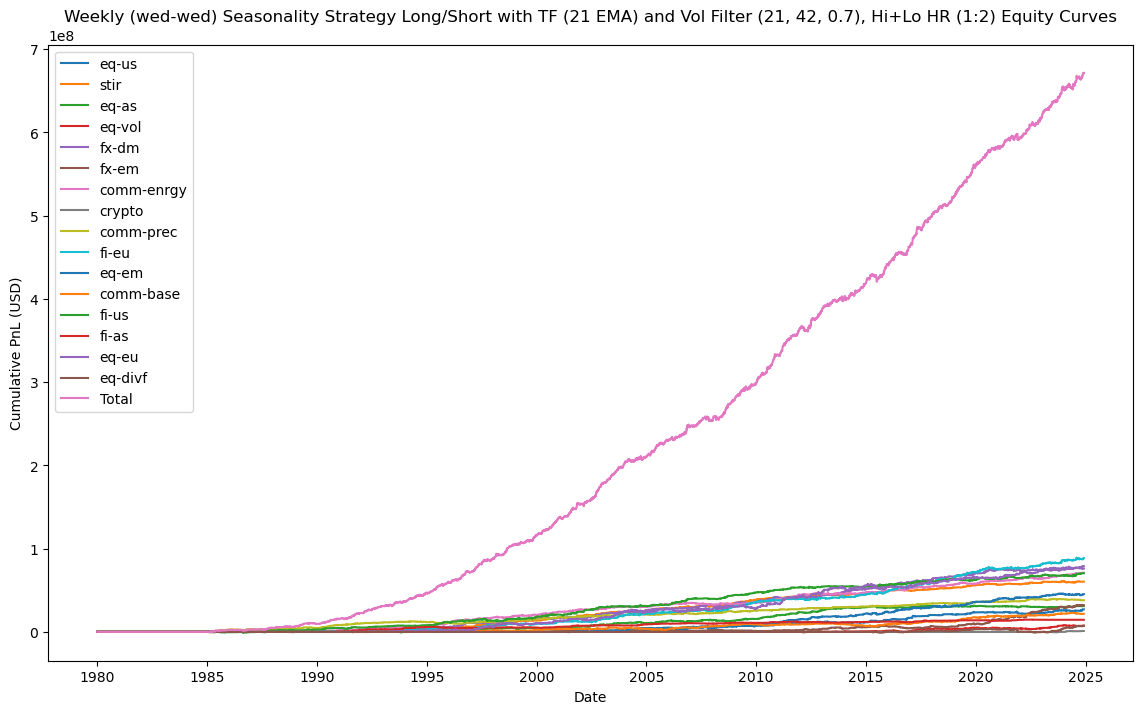

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


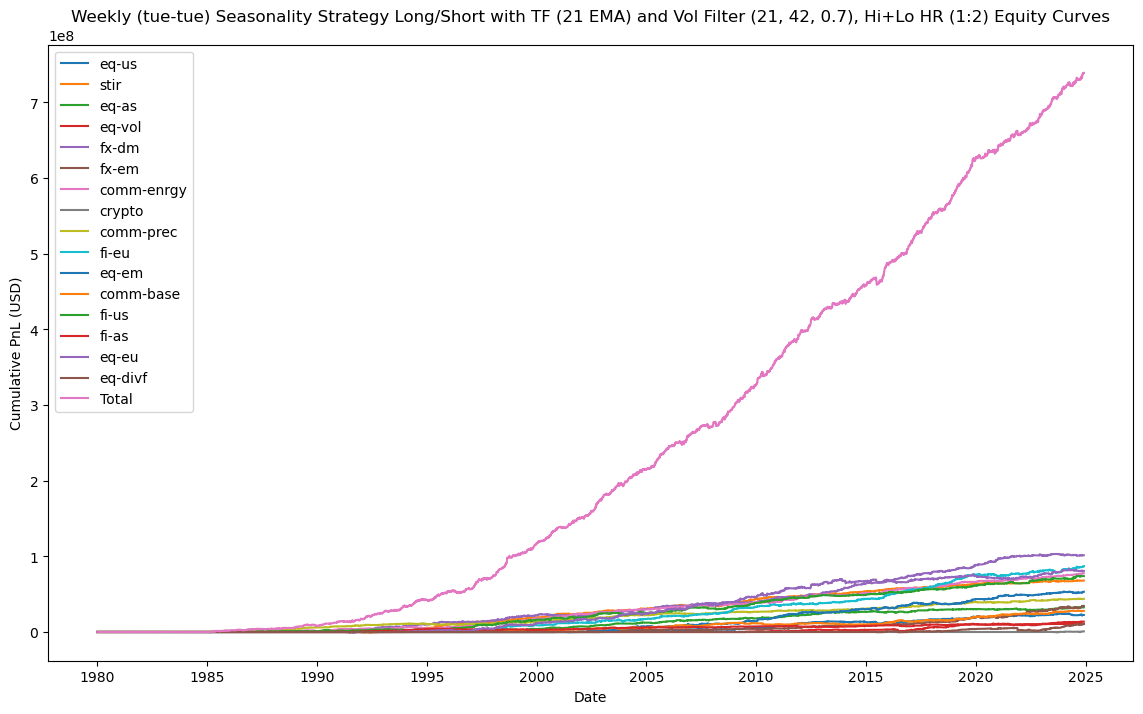

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


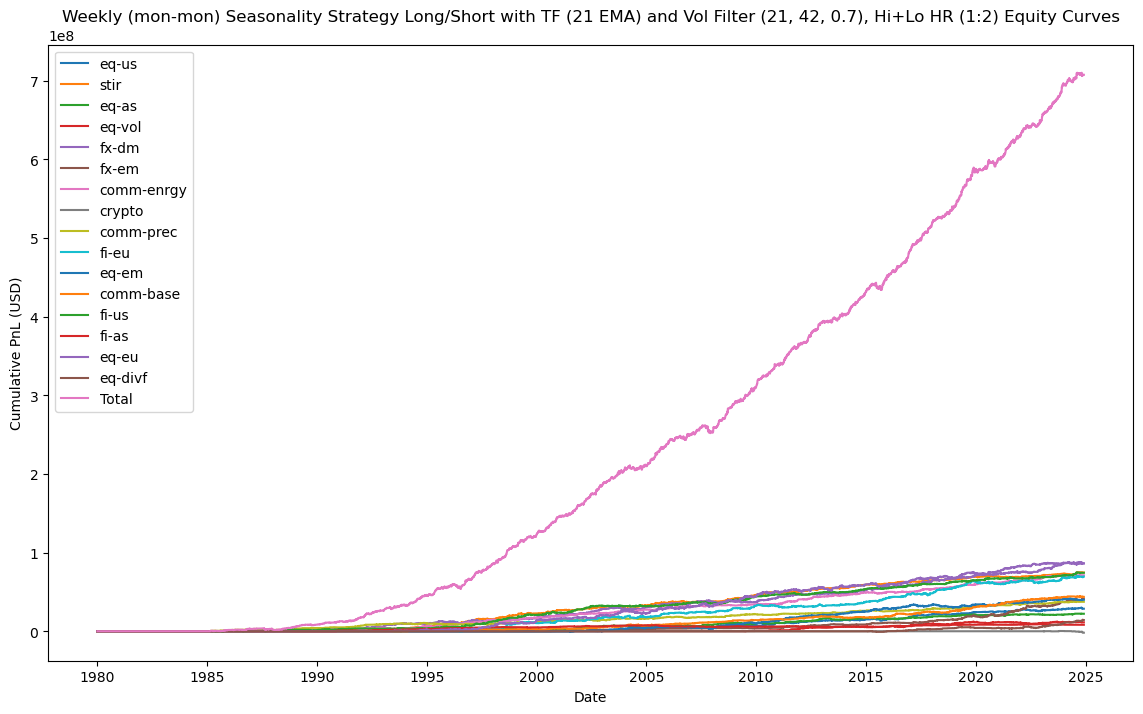

fri   2.59
thu   2.48
wed   2.61
tue   2.72
mon   2.67
dtype: float64


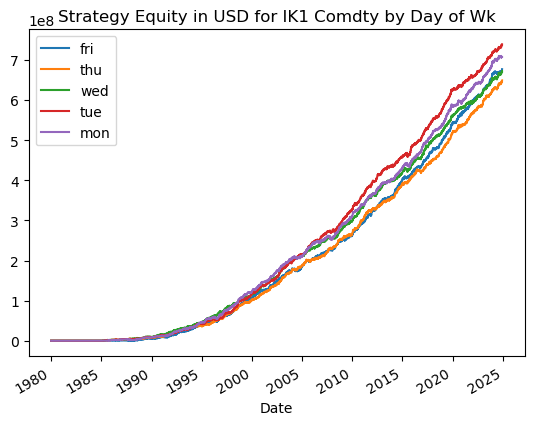

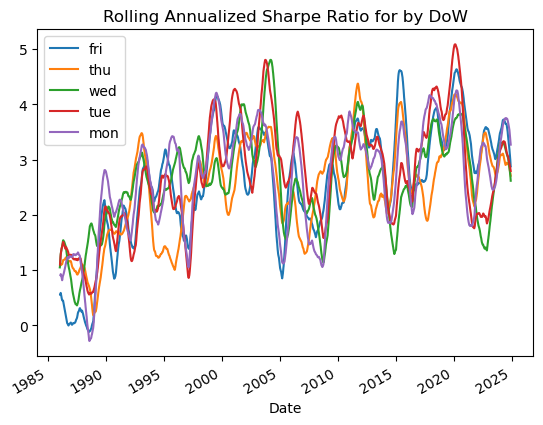

In [19]:
asst = 'IK1 Comdty'
res_dict_dow = {}


filter_list = []
start = '01012024'
start = ''

for wkday in daysofwk:
    tr_tmp = DoWrules[wkday]
    bt_tmp = tr_tmp.plot_equity(byac=True,totalsys=True, filter_ac=filter_list, start_date=start, excl_ac=['comm-soft'])
    res_dict_dow[wkday] = bt_tmp['Total']

dow_pd = pd.DataFrame(res_dict_dow)


dow_pd.plot(title=f'Strategy Equity in USD for {asst} by Day of Wk')

asst_pnl_df = dow_pd.diff()

# Calculate the rolling annualized Sharpe ratio for each column in asst_pnl_df
rolling_sharpe = asst_pnl_df.rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))
rolling_sharpe = rolling_sharpe.rolling(window=252).mean()
# Plot the rolling annualized Sharpe ratio
rolling_sharpe.plot(title=f'Rolling Annualized Sharpe Ratio for by DoW')
print(rolling_sharpe.mean())

fri   3.35
thu   2.91
wed   2.75
tue   3.08
mon   3.07
dtype: float64


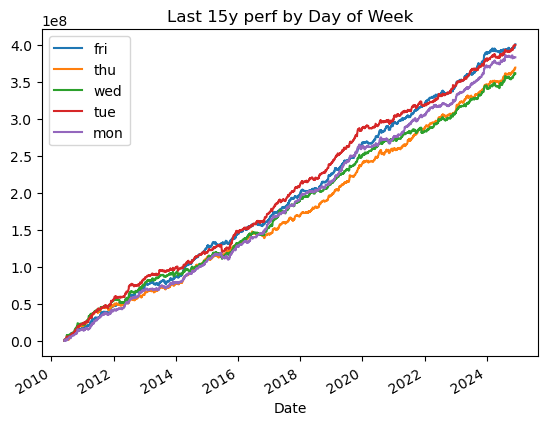

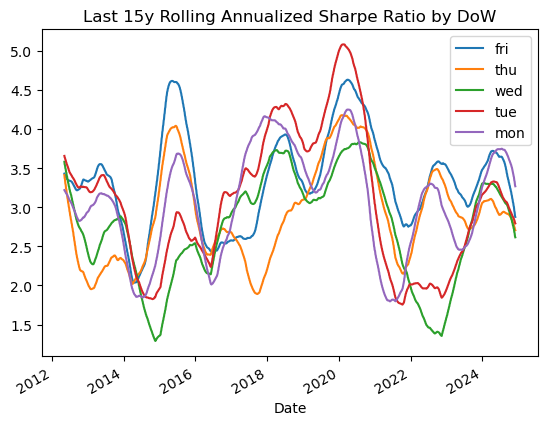

In [20]:
dow_pd_filt = dow_pd[-252*15:]
dow_pd_filt = dow_pd_filt - dow_pd_filt.iloc[0]
dow_pd_filt.plot(title='Last 15y perf by Day of Week')

asst_pnl_df = dow_pd_filt.diff()




# Calculate the rolling annualized Sharpe ratio for each column in asst_pnl_df
rolling_sharpe = asst_pnl_df.rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))
rolling_sharpe = rolling_sharpe.rolling(window=252).mean()
# Plot the rolling annualized Sharpe ratio
rolling_sharpe.plot(title=f'Last 15y Rolling Annualized Sharpe Ratio by DoW')
print(rolling_sharpe.mean())

fri   3.34
thu   3.00
wed   2.37
tue   2.55
mon   3.11
dtype: float64


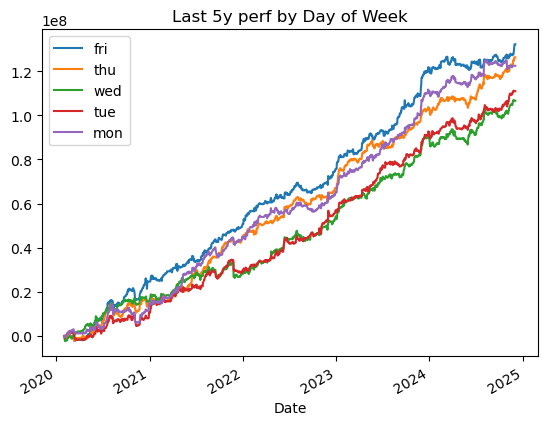

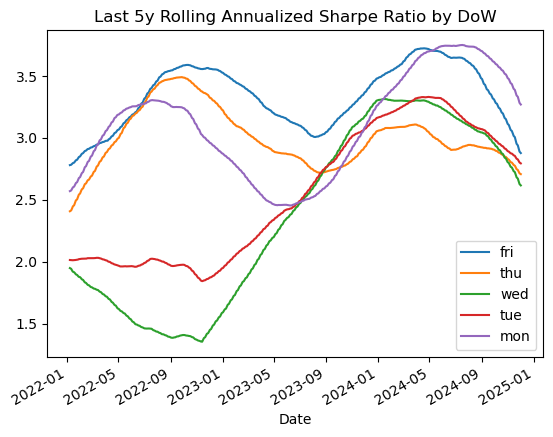

In [21]:
dow_pd_filt = dow_pd[-252*5:]
dow_pd_filt = dow_pd_filt - dow_pd_filt.iloc[0]
dow_pd_filt.plot(title='Last 5y perf by Day of Week')

asst_pnl_df = dow_pd_filt.diff()

# Calculate the rolling annualized Sharpe ratio for each column in asst_pnl_df
rolling_sharpe = asst_pnl_df.rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))
rolling_sharpe = rolling_sharpe.rolling(window=252).mean()
# Plot the rolling annualized Sharpe ratio
rolling_sharpe.plot(title=f'Last 5y Rolling Annualized Sharpe Ratio by DoW')
print(rolling_sharpe.mean())

<Axes: title={'center': 'Rolling Annualized Sharpe Ratio for IK1 Comdty'}, xlabel='Date'>

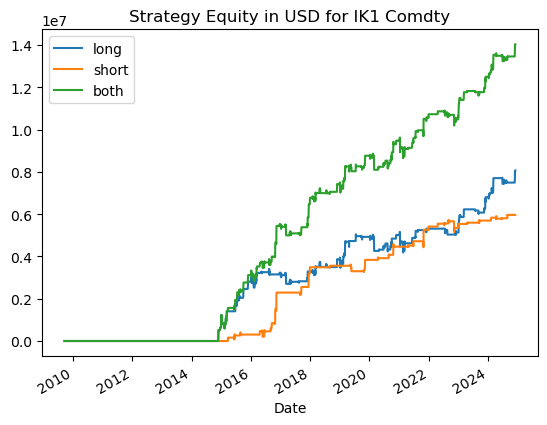

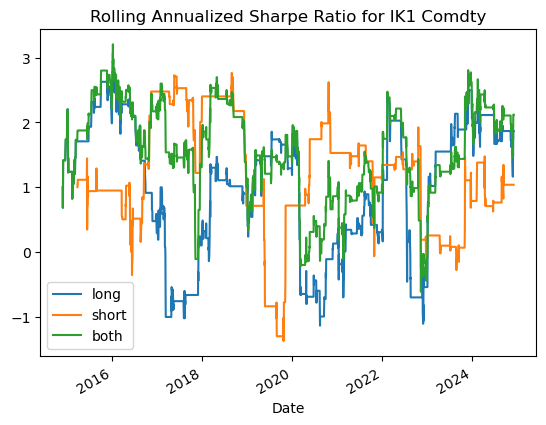

In [22]:


g1 = wklySeasn_b.backtest_asset(asst)
g_l = wklySeasn_l.backtest_asset(asst)
g_s = wklySeasn_s.backtest_asset(asst)

g1.set_index('Date', inplace=True)
g_l.set_index('Date', inplace=True)
g_s.set_index('Date', inplace=True)

# Create a new DataFrame with 'Strategy_Equity_USD' from each DataFrame
equity_df = pd.DataFrame({
    'long': g_l['Strategy_Equity_USD'],
    'short': g_s['Strategy_Equity_USD'],
    'both': g1['Strategy_Equity_USD']
})

# Plot the new DataFrame
equity_df.plot(title=f'Strategy Equity in USD for {asst}')

asst_pnl_df = equity_df.diff()

# Calculate the rolling annualized Sharpe ratio for each column in asst_pnl_df
rolling_sharpe = asst_pnl_df.rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))

# Plot the rolling annualized Sharpe ratio
rolling_sharpe.plot(title=f'Rolling Annualized Sharpe Ratio for {asst}')

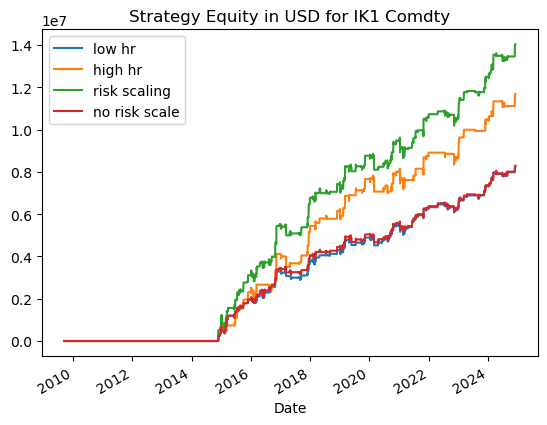

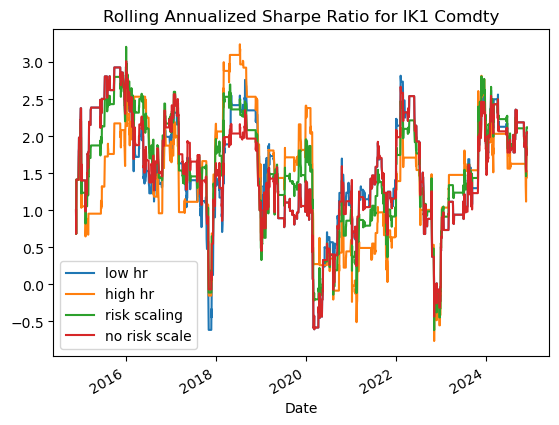

In [23]:

g_b = wklySeasn_b.backtest_asset(asst)
g_l = wklySeasn_b_low.backtest_asset(asst)
g_h = wklySeasn_b_hi.backtest_asset(asst)
g_nos = wklySeasn_b_nos.backtest_asset(asst)

g_b.set_index('Date', inplace=True)
g_l.set_index('Date', inplace=True)
g_h.set_index('Date', inplace=True)
g_nos.set_index('Date', inplace=True)

# Create a new DataFrame with 'Strategy_Equity_USD' from each DataFrame
equity_df = pd.DataFrame({
    'low hr': g_l['Strategy_Equity_USD'],
    'high hr': g_h['Strategy_Equity_USD'],
    'risk scaling': g_b['Strategy_Equity_USD'],
    'no risk scale': g_nos['Strategy_Equity_USD']
})

# Plot the new DataFrame
equity_df.plot(title=f'Strategy Equity in USD for {asst}')

asst_pnl_df = equity_df.diff()

# Calculate the rolling annualized Sharpe ratio for each column in asst_pnl_df
rolling_sharpe = asst_pnl_df.rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))

# Plot the rolling annualized Sharpe ratio
rolling_sharpe.plot(title=f'Rolling Annualized Sharpe Ratio for {asst}')

# Calculate the rolling correlation between 'low hr' and 'high hr'
rolling_corr = asst_pnl_df['low hr'].rolling(window=252).corr(asst_pnl_df['high hr'])

g_b.to_clipboard()

/var/folders/m4/1ljrqkl53mx809bbs_bwc0jr0000gn/T/ipykernel_43629/133342402.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_b_hi['hi PnL'] = (g_b_hi['Strategy_PnL_USD']).cumsum()
/var/folders/m4/1ljrqkl53mx809bbs_bwc0jr0000gn/T/ipykernel_43629/133342402.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_b_lo['lo PnL'] = g_b_lo['Strategy_PnL_USD'].cumsum()


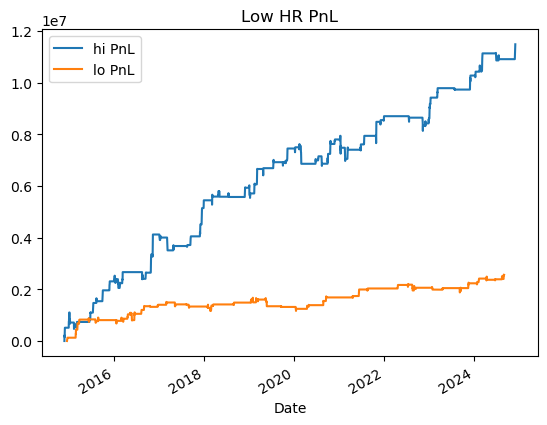

In [24]:
g_b['abs_size'] = g_b['InTrade'].abs()
g_b_hi = g_b[g_b['abs_size'] == 2]
g_b_lo = g_b[g_b['abs_size'] == 1]

g_b_hi['hi PnL'] = (g_b_hi['Strategy_PnL_USD']).cumsum()
g_b_lo['lo PnL'] = g_b_lo['Strategy_PnL_USD'].cumsum()

g_b_hi['hi PnL'].plot(title='High HR PnL')
g_b_lo['lo PnL'].plot(title='Low HR PnL')
plt.legend()

<Axes: title={'center': 'Rolling Correlation between Low HR and High HR'}, xlabel='Date'>

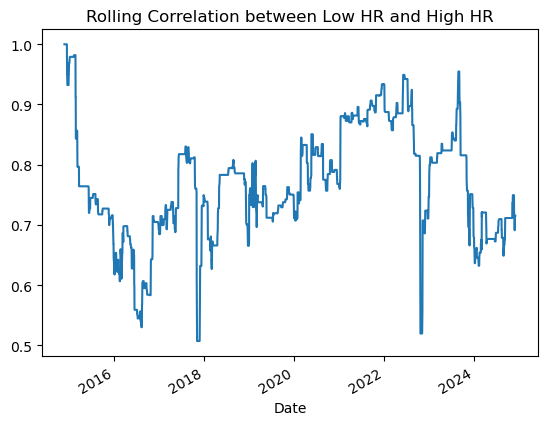

In [25]:

# Plot the rolling correlation
rolling_corr.plot(title='Rolling Correlation between Low HR and High HR')

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


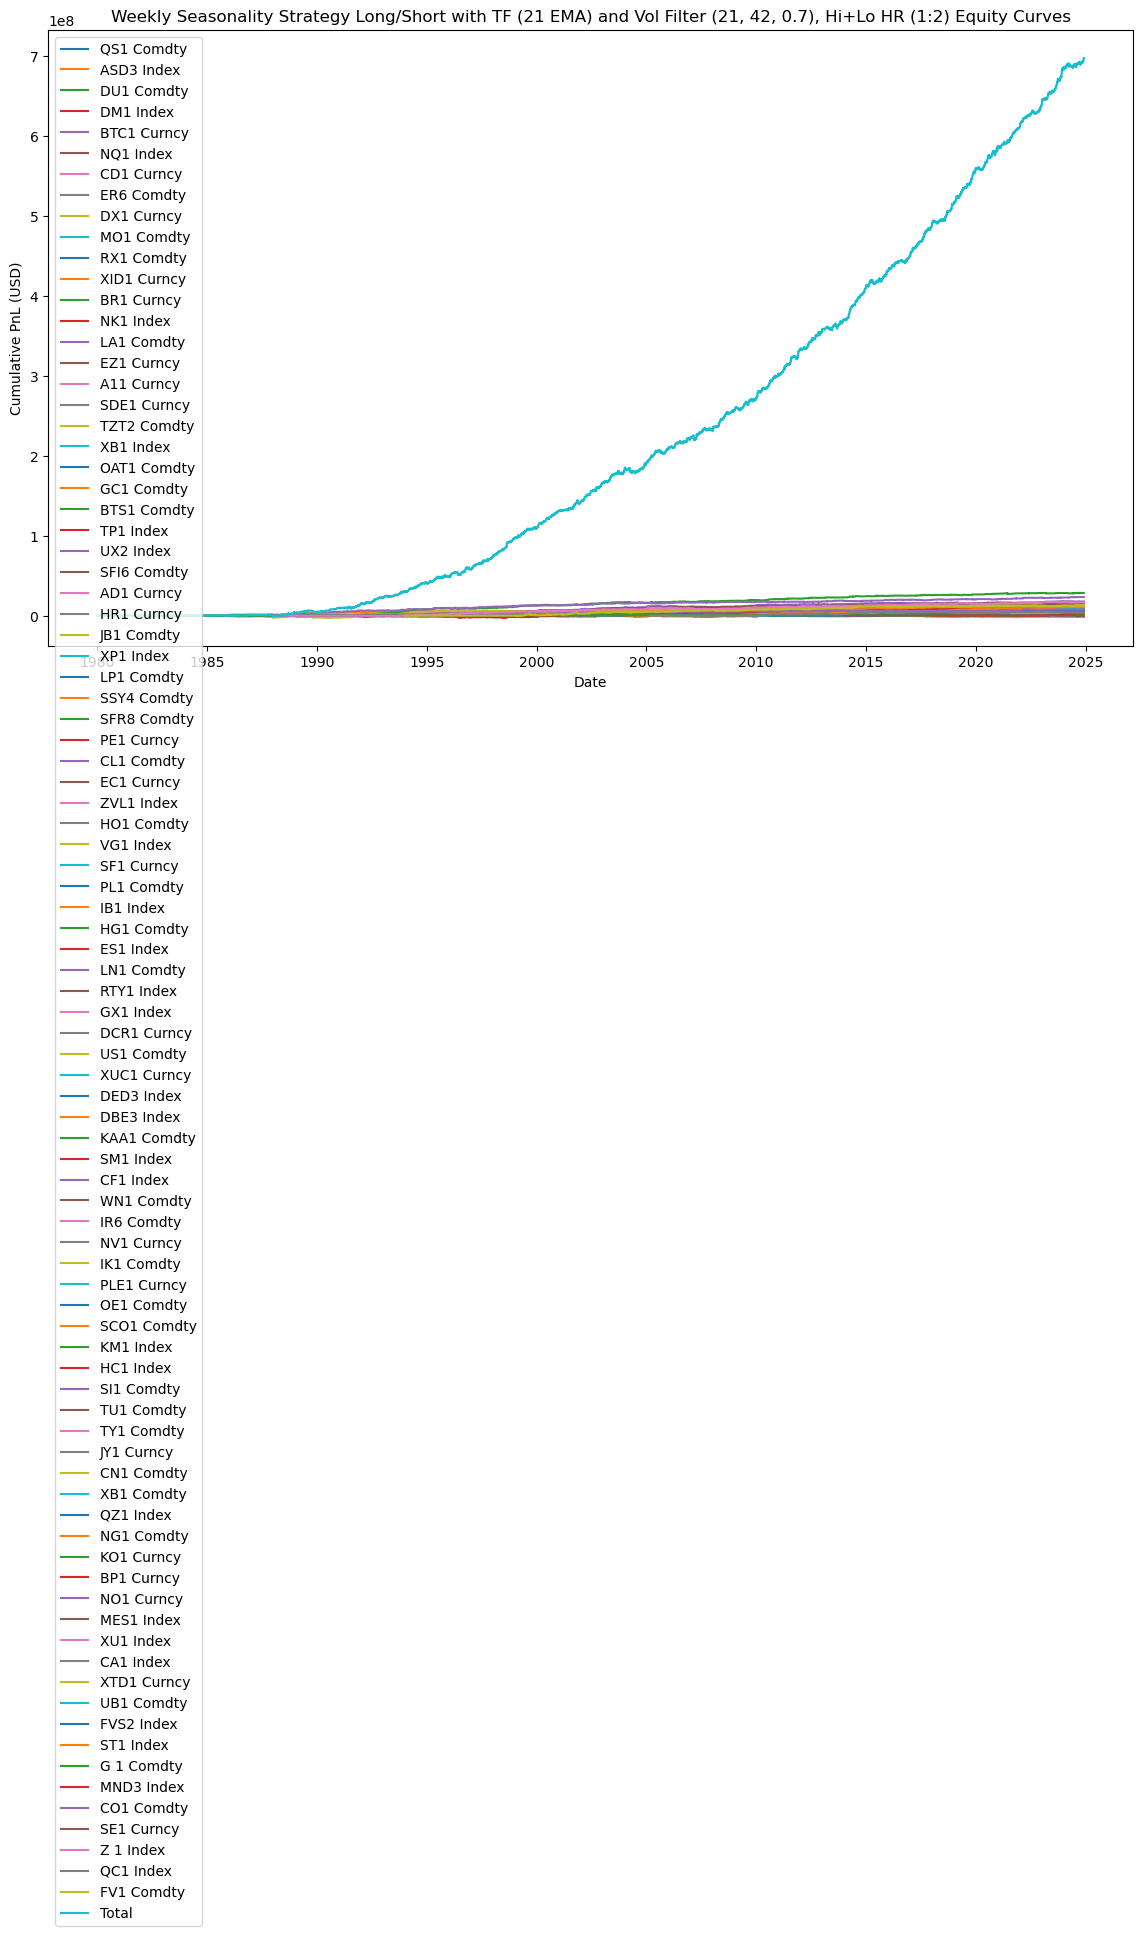

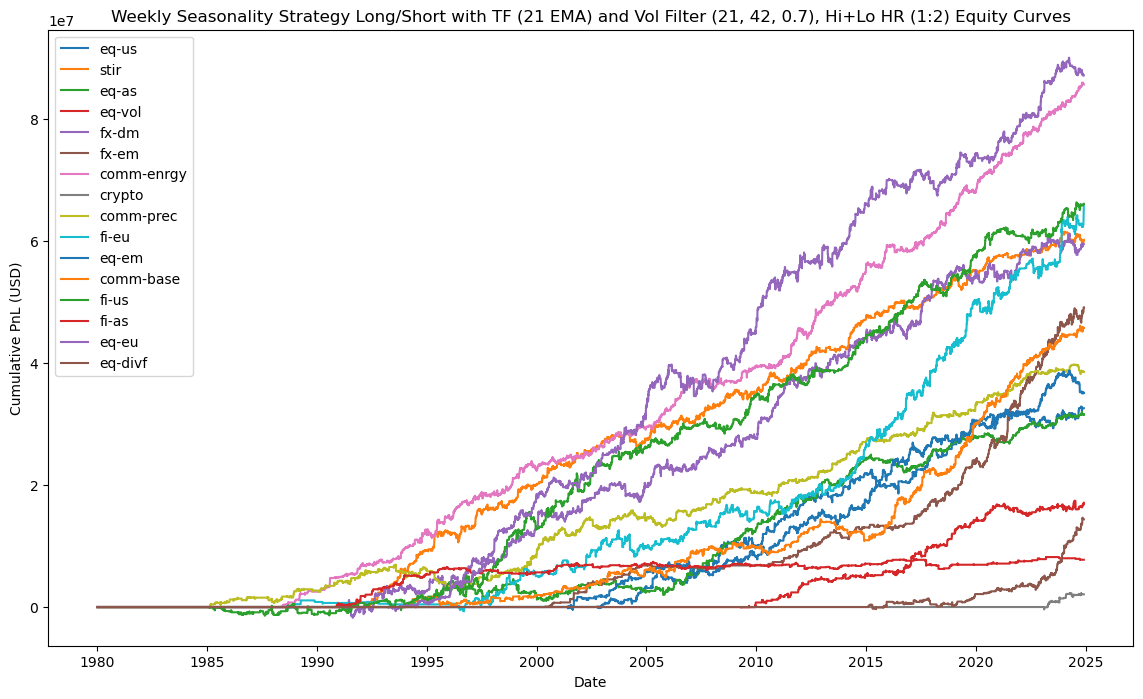

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


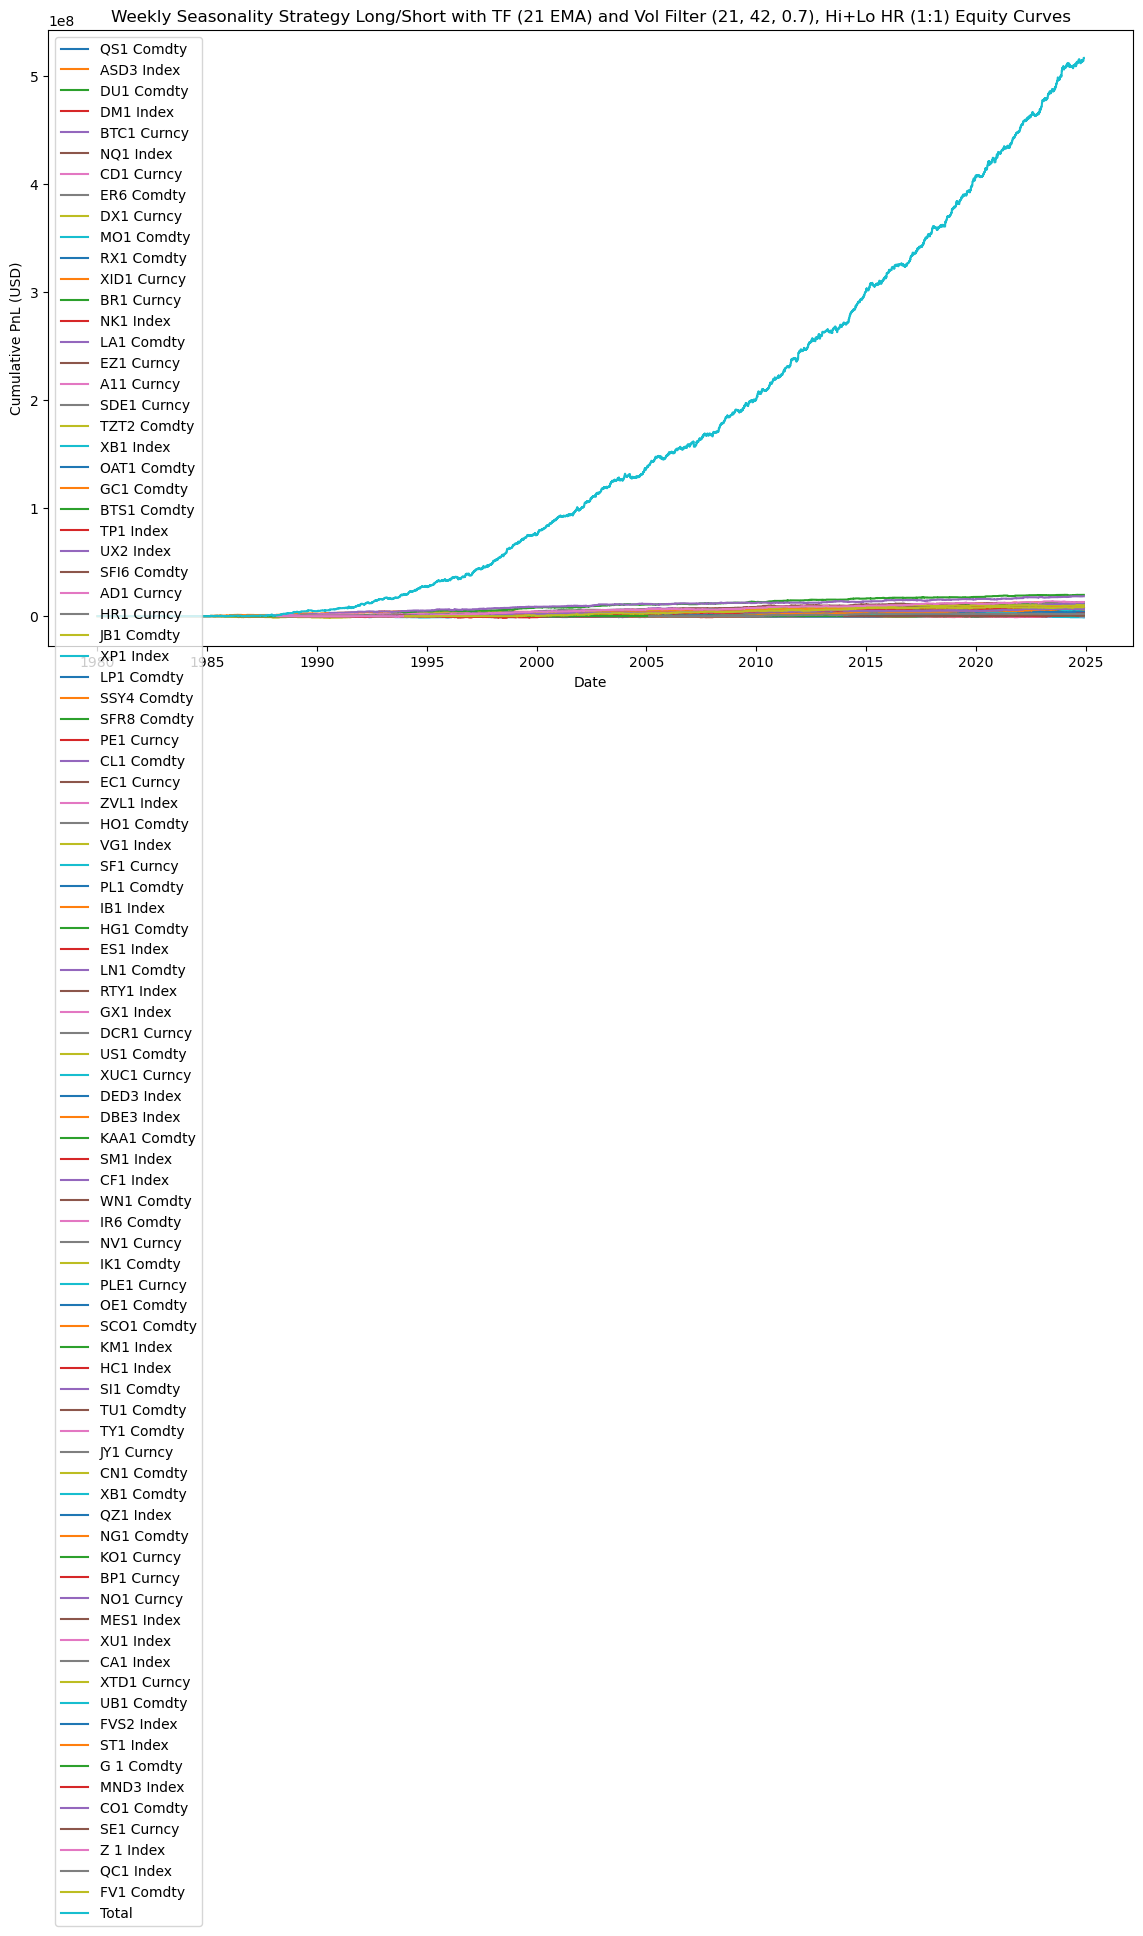

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


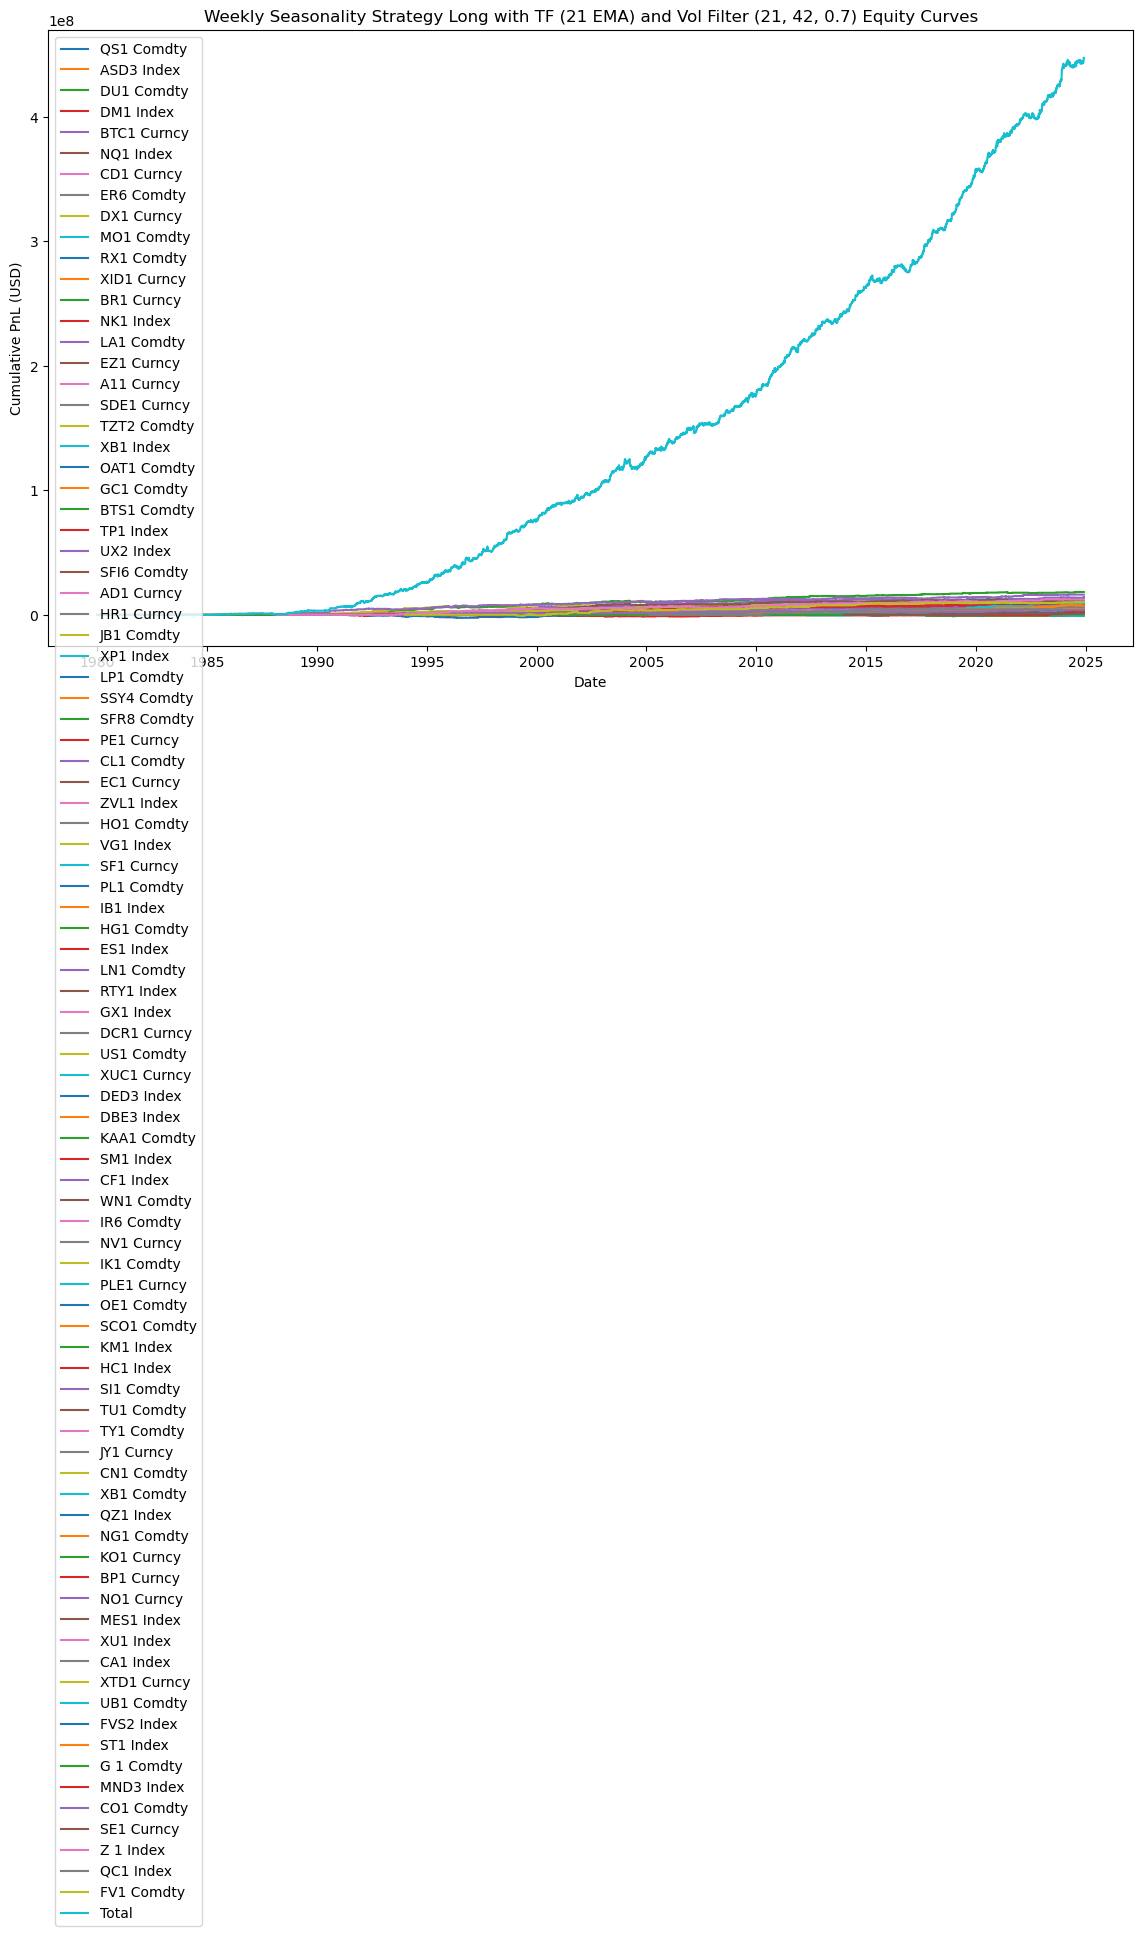

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


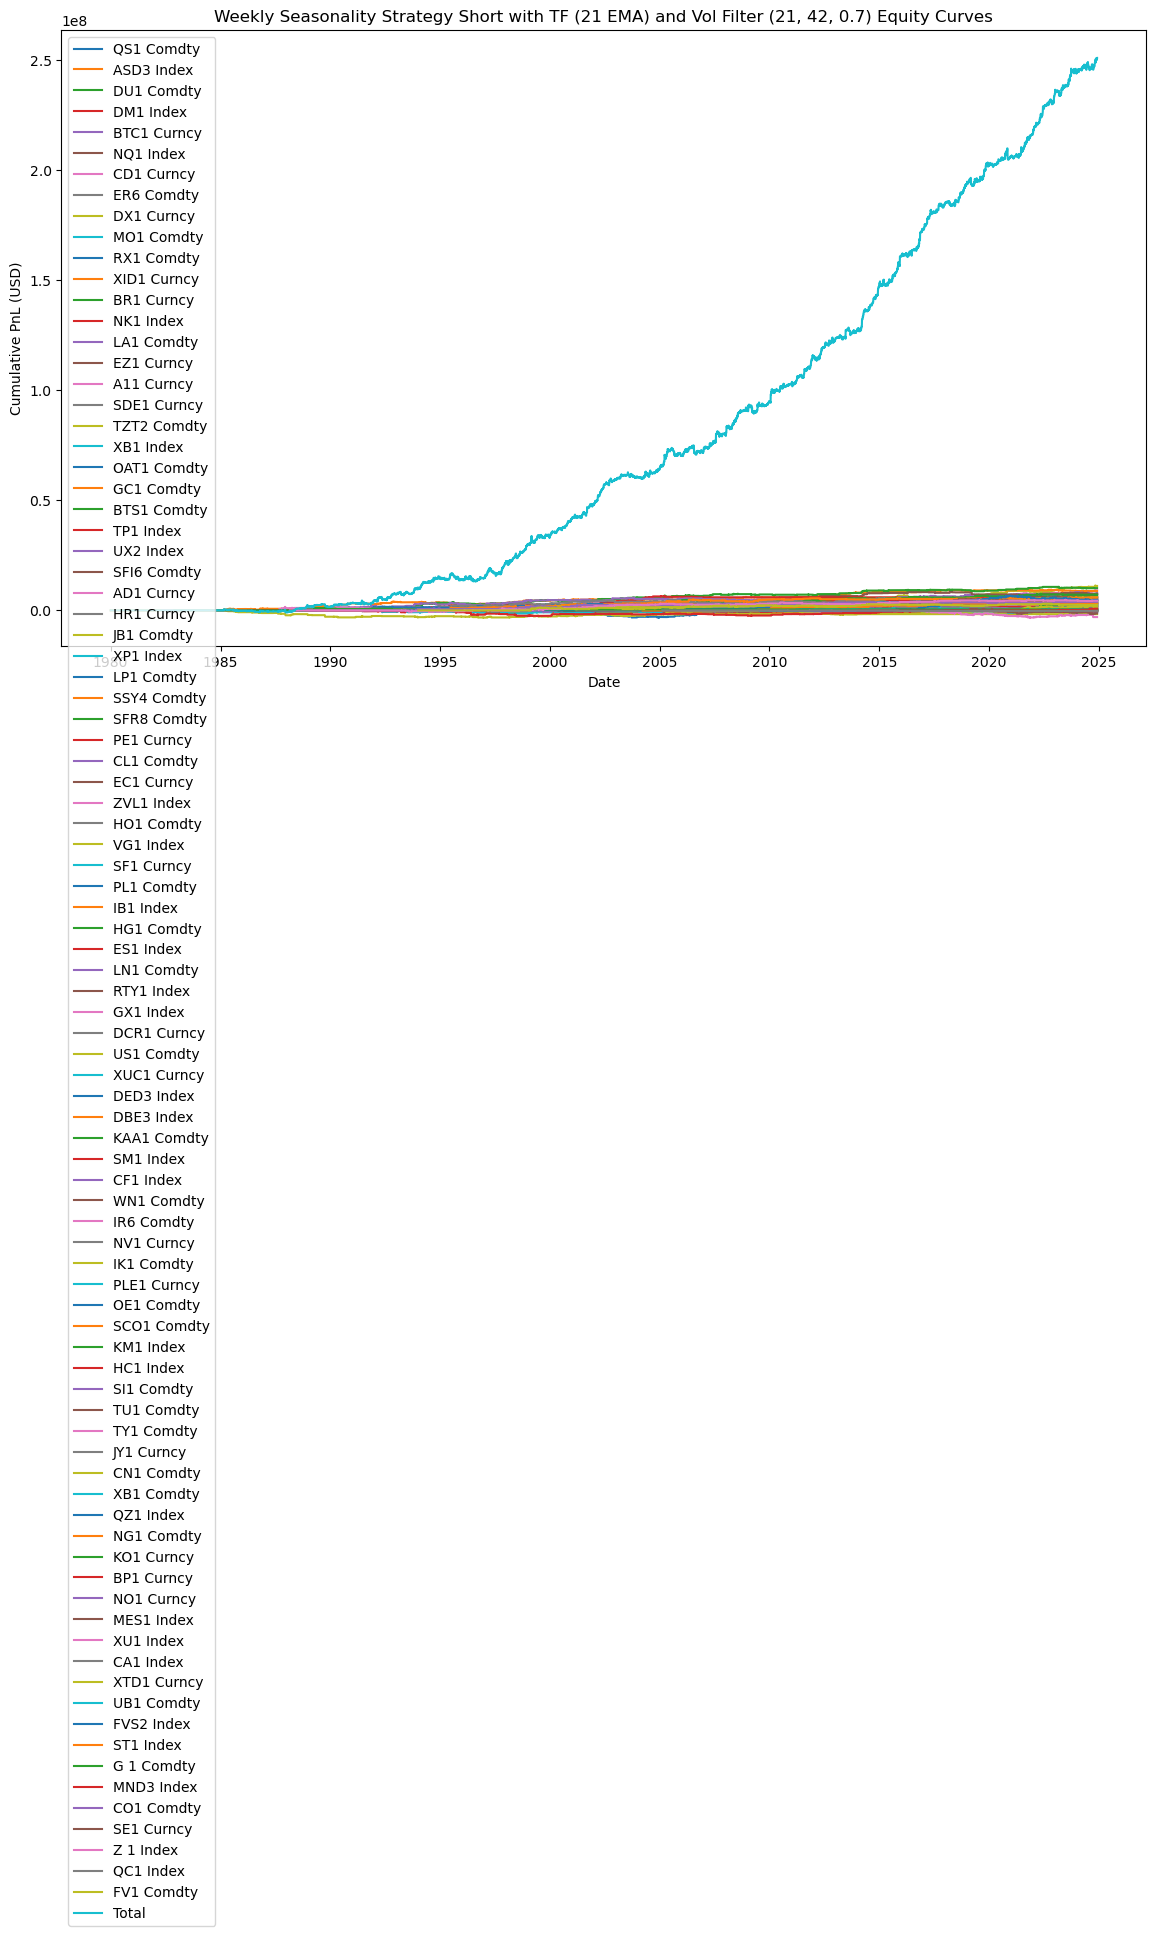

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


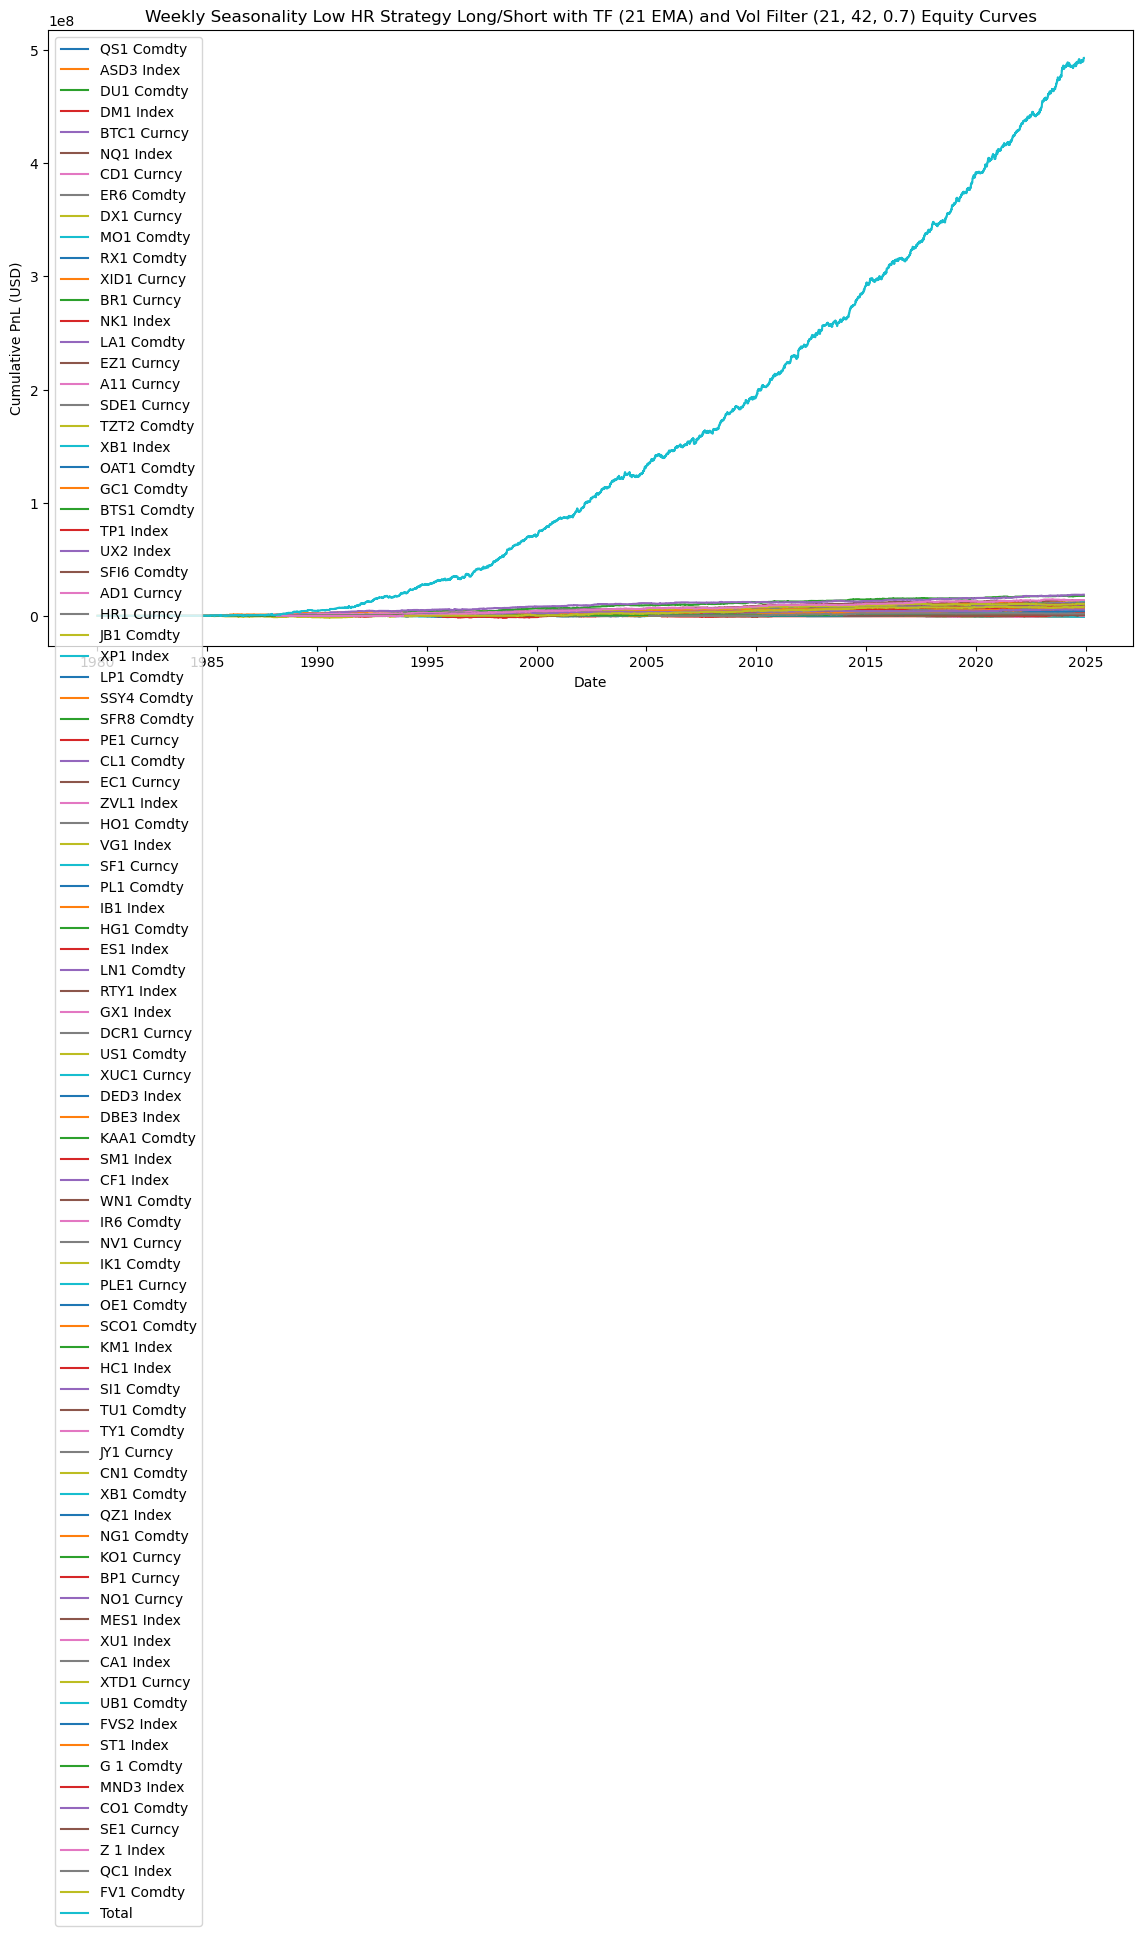

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


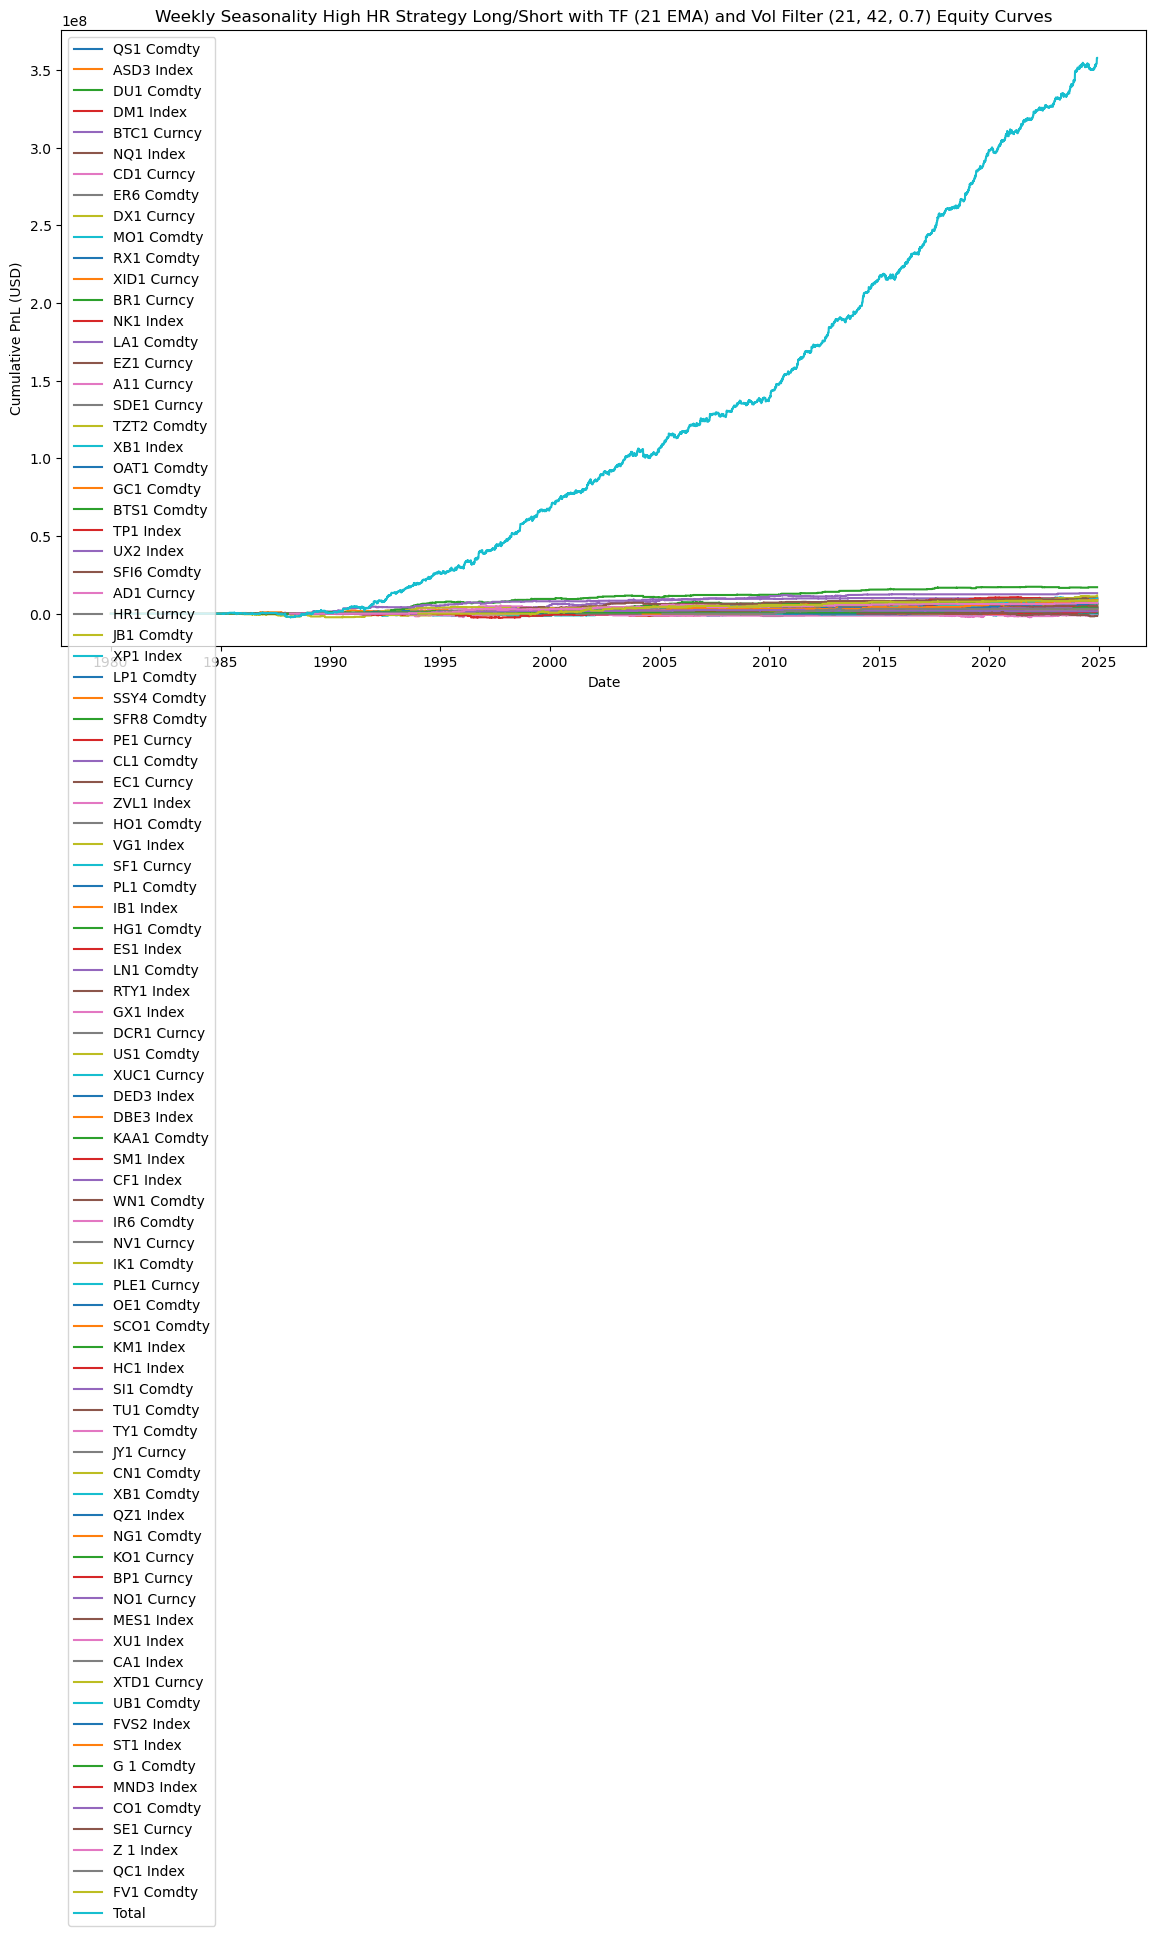

In [26]:

filter_list = []
start = ''
end = ''
#start = ''
#filter_list = ['PL1 Comdty', 'IK1 Comdty', 'MO1 Comdty']
pnldf = wklySeasn_b.plot_equity(byassets=True,totalsys=True, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])
pnldf_ac = wklySeasn_b.plot_equity(byac=True,totalsys=False, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])
pnldf_nos = wklySeasn_b_nos.plot_equity(byassets=True,totalsys=True, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])
pnldf_l = wklySeasn_l.plot_equity(byassets=True,totalsys=True, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])
pnldf_s = wklySeasn_s.plot_equity(byassets=True,totalsys=True, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])
pnldf_b_low = wklySeasn_b_low.plot_equity(byassets=True,totalsys=True, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])
pnldf_b_hi = wklySeasn_b_hi.plot_equity(byassets=True,totalsys=True, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])


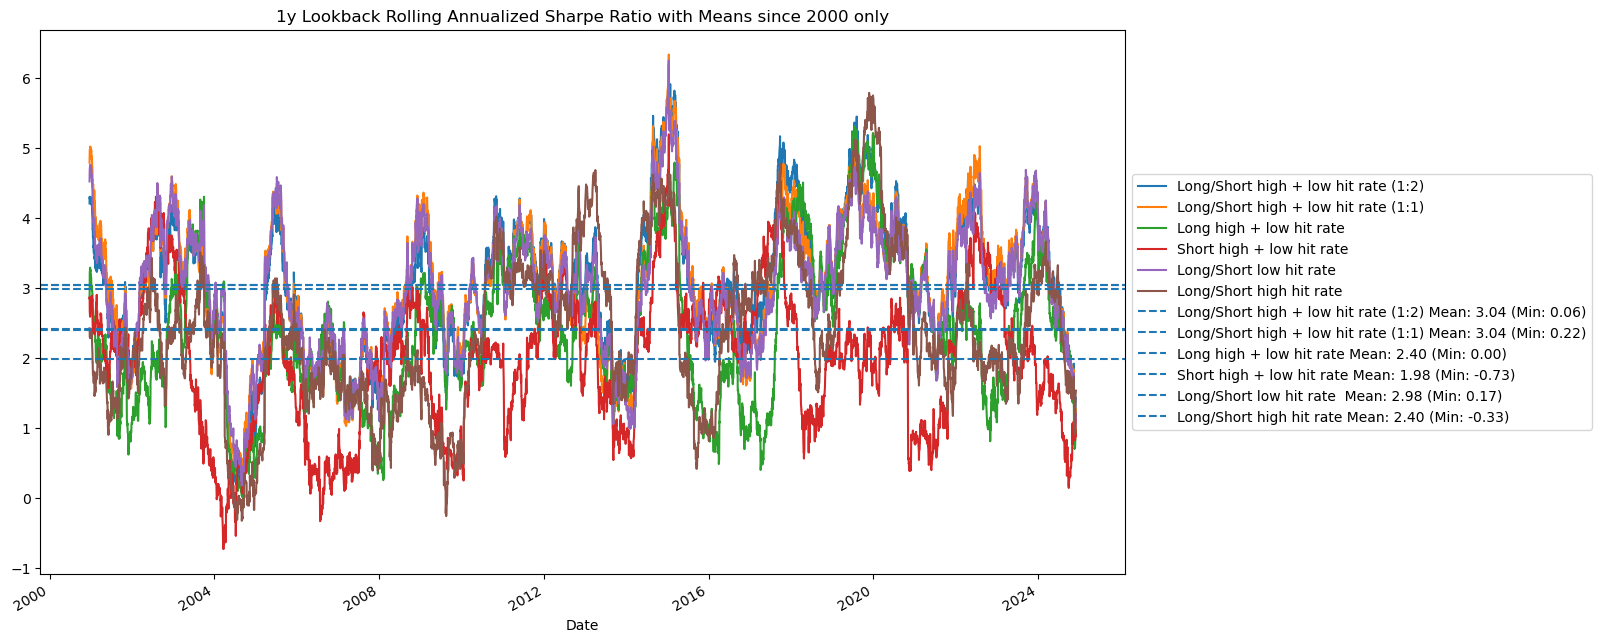

In [27]:
# Extract the 'Total' columns from each of the pnldfs
total_pnl_b = pnldf['Total']
total_pnl_nos = pnldf_nos['Total']
total_pnl_l = pnldf_l['Total']
total_pnl_s = pnldf_s['Total']
total_pnl_b_low = pnldf_b_low['Total']
total_pnl_b_hi = pnldf_b_hi['Total']

# Create a new dataframe with the extracted 'Total' columns
combined_df = pd.DataFrame({
    'Long/Short high + low hit rate (1:2)': total_pnl_b,
    'Long/Short high + low hit rate (1:1)': total_pnl_nos,
    'Long high + low hit rate': total_pnl_l,
    'Short high + low hit rate': total_pnl_s,
    'Long/Short low hit rate ': total_pnl_b_low,
    'Long/Short high hit rate': total_pnl_b_hi
})

# Filter the data to only include dates after '01012000'
combined_df = combined_df[combined_df.index > '2000-01-01']

combined_pnl_df = combined_df.diff()

# Calculate the rolling annualized Sharpe ratio for each column in combined_pnl_df
rolling_sharpe = combined_pnl_df.rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))
# Calculate the mean of each series in rolling_sharpe
mean_sharpe = rolling_sharpe.mean()
min_sharpe = rolling_sharpe.min()

# Plot the rolling Sharpe ratios
ax = rolling_sharpe.plot(figsize=(14, 8), title='1y Lookback Rolling Annualized Sharpe Ratio with Means since 2000 only')

# Plot the mean of each series as dashed lines
for column in rolling_sharpe.columns:
    ax.axhline(y=mean_sharpe[column], linestyle='--', label=f'{column} Mean: {mean_sharpe[column]:.2f} (Min: {min_sharpe[column]:.2f})')
    # Move the legend outside the chart area


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()



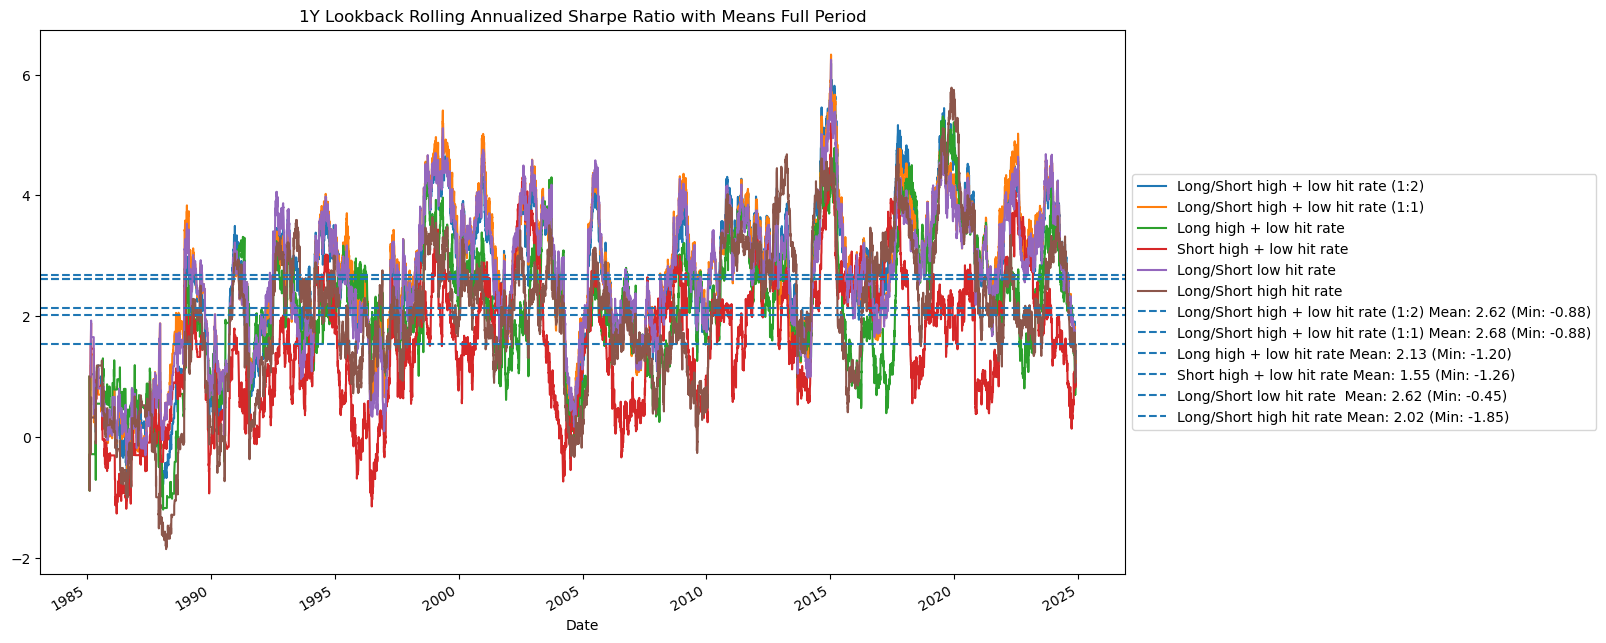

In [28]:
# Extract the 'Total' columns from each of the pnldfs
total_pnl_b = pnldf['Total']
total_pnl_nos = pnldf_nos['Total']
total_pnl_l = pnldf_l['Total']
total_pnl_s = pnldf_s['Total']
total_pnl_b_low = pnldf_b_low['Total']
total_pnl_b_hi = pnldf_b_hi['Total']

# Create a new dataframe with the extracted 'Total' columns
combined_df = pd.DataFrame({
    'Long/Short high + low hit rate (1:2)': total_pnl_b,
    'Long/Short high + low hit rate (1:1)': total_pnl_nos,
    'Long high + low hit rate': total_pnl_l,
    'Short high + low hit rate': total_pnl_s,
    'Long/Short low hit rate ': total_pnl_b_low,
    'Long/Short high hit rate': total_pnl_b_hi
})


combined_pnl_df = combined_df.diff()

# Calculate the rolling annualized Sharpe ratio for each column in combined_pnl_df
rolling_sharpe = combined_pnl_df.rolling(window=252).apply(lambda x: (x.mean() / x.std()) * (252**0.5))
# Calculate the mean of each series in rolling_sharpe
mean_sharpe = rolling_sharpe.mean()
min_sharpe = rolling_sharpe.min()

# Plot the rolling Sharpe ratios
ax = rolling_sharpe.plot(figsize=(14, 8), title='1Y Lookback Rolling Annualized Sharpe Ratio with Means Full Period')

# Plot the mean of each series as dashed lines
for column in rolling_sharpe.columns:
    ax.axhline(y=mean_sharpe[column], linestyle='--', label=f'{column} Mean: {mean_sharpe[column]:.2f} (Min: {min_sharpe[column]:.2f})')
    # Move the legend outside the chart area


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()



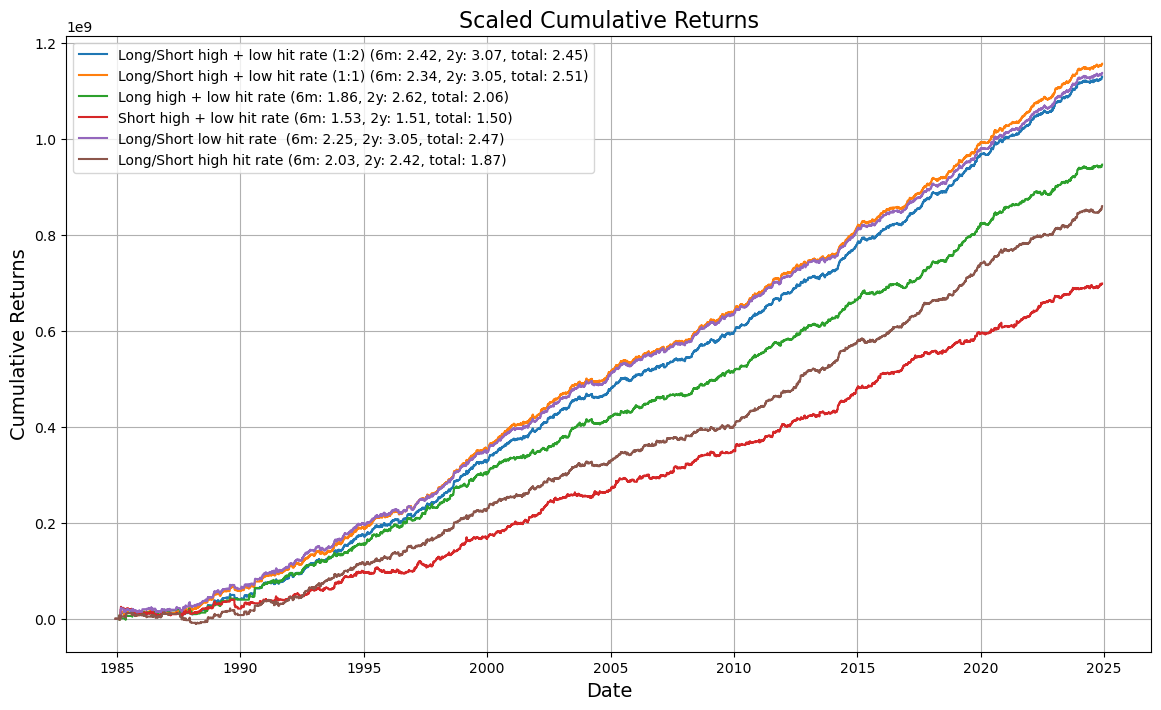

In [29]:
vol_tgt = 10000000  # Target annualized volatility

# Calculate the rolling standard deviation of the last 125 days of returns
rolling_std = combined_pnl_df.rolling(window=125).std()

# Calculate the scaling factor to achieve the target annualized volatility
scaling_factor = vol_tgt / (rolling_std * (252 ** 0.5))

# Apply the scaling factor to the returns
scaled_combined_pnl_df = combined_pnl_df * scaling_factor

# Fill any NaN values that may result from the rolling calculation
scaled_combined_pnl_df = scaled_combined_pnl_df.fillna(0)



# Display the scaled DataFrame
scaled_combined_df = scaled_combined_pnl_df.cumsum()
scaled_combined_df = scaled_combined_df.iloc[252*5:]

# Calculate the Sharpe ratios for different periods
def calculate_sharpe_ratios(df, periods):
    sharpe_ratios = {}
    for period, label in periods.items():
        period_returns = df.tail(period).mean() / df.tail(period).std() * np.sqrt(252)
        sharpe_ratios[label] = period_returns
    return sharpe_ratios

# Define periods for Sharpe ratio calculation
periods = {
    126: 'last 6m',  # Approximately 6 months
    504: 'last 2y',  # Approximately 2 years
    len(scaled_combined_pnl_df): 'total period'
}

# Calculate Sharpe ratios
sharpe_ratios = calculate_sharpe_ratios(scaled_combined_pnl_df, periods)

# Update the legend labels with Sharpe ratios
legend_labels = []
for column in scaled_combined_pnl_df.columns:
    label = f"{column} (6m: {sharpe_ratios['last 6m'][column]:.2f}, 2y: {sharpe_ratios['last 2y'][column]:.2f}, total: {sharpe_ratios['total period'][column]:.2f})"
    legend_labels.append(label)

# Plot the scaled cumulative returns with updated legend labels
plt.figure(figsize=(14, 8))
for column, label in zip(scaled_combined_df.columns, legend_labels):
    plt.plot(scaled_combined_df.index, scaled_combined_df[column], label=label)
plt.title('Scaled Cumulative Returns', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()



In [30]:
pnls_s = pnldf_s.iloc[-1].sort_values(ascending=False)
pnls_l = pnldf_l.iloc[-1].sort_values(ascending=False)
pnls_c = pnldf.iloc[-1].sort_values(ascending=False)


In [31]:
print('PnL by Asset for Short Strategy')

for asset, pnl in pnls_s.items():
    print(f'{asset}: {pnl:,.0f}')

print('PnL by Asset for Long Strategy')
for asset, pnl in pnls_l.items():
    print(f'{asset}: {pnl:,.0f}')


print('PnL by Asset for Long/Short Strategy')
for asset, pnl in pnls_c.items():
    print(f'{asset}: {pnl:,.0f}')

PnL by Asset for Short Strategy
Total: 250,818,575
TZT2 Comdty: 11,092,951
SFR8 Comdty: 10,114,713
A11 Curncy: 9,102,682
GC1 Comdty: 8,822,280
UX2 Index: 7,829,567
SFI6 Comdty: 7,595,199
WN1 Comdty: 7,460,938
KM1 Index: 7,187,423
CL1 Comdty: 7,093,140
HG1 Comdty: 6,884,962
HO1 Comdty: 6,007,907
ES1 Index: 5,993,575
IK1 Comdty: 5,967,099
CD1 Curncy: 5,947,495
PE1 Curncy: 5,942,975
NG1 Comdty: 5,829,520
XP1 Index: 5,677,919
MO1 Comdty: 5,431,279
PL1 Comdty: 4,953,835
HR1 Curncy: 4,942,726
TP1 Index: 4,860,358
FVS2 Index: 4,778,165
JY1 Curncy: 4,767,906
NK1 Index: 4,691,964
Z 1 Index: 4,405,671
MES1 Index: 4,383,335
QS1 Comdty: 4,333,080
XB1 Index: 4,160,288
CF1 Index: 4,097,712
DX1 Curncy: 4,050,076
CO1 Comdty: 3,862,650
LN1 Comdty: 3,707,498
SI1 Comdty: 3,495,590
CN1 Comdty: 3,384,527
EC1 Curncy: 3,334,506
LP1 Comdty: 3,330,108
IB1 Index: 3,297,548
ST1 Index: 3,221,004
VG1 Index: 3,102,522
BTS1 Comdty: 3,038,087
GX1 Index: 2,915,286
KO1 Curncy: 2,884,888
TU1 Comdty: 2,779,125
IR6 Comdty

In [32]:

# Calculate daily returns (diffs)
daily_returns = pnldf.diff()

# Calculate the mean and standard deviation of daily returns for the last 8 years
# Calculate the date range for 8 years ago
eight_years_ago = daily_returns.index[-1] - pd.DateOffset(years=10)
eight_years_ago_end = eight_years_ago - pd.DateOffset(years=10)

# Filter the daily returns for the specified date range
last_8_years = daily_returns.loc[(daily_returns.index >= eight_years_ago_end) & (daily_returns.index < eight_years_ago)]
last_8_years = daily_returns.loc[(daily_returns.index >= eight_years_ago)]
mean_returns = last_8_years.mean()
std_returns = last_8_years.std()

# Calculate the annualized Sharpe ratio
annualized_sharpe = mean_returns / std_returns * np.sqrt(252)

annualized_sharpe = annualized_sharpe.sort_values(ascending=False)

for asset, sharpe in annualized_sharpe.items():
    print(f'{asset}: {sharpe:.2f}')

Total: 3.27
IK1 Comdty: 1.54
TZT2 Comdty: 1.42
LN1 Comdty: 1.32
HG1 Comdty: 1.29
WN1 Comdty: 1.28
LA1 Comdty: 1.18
US1 Comdty: 1.17
PLE1 Curncy: 1.16
HR1 Curncy: 1.08
KO1 Curncy: 1.07
A11 Curncy: 1.06
MO1 Comdty: 1.04
ASD3 Index: 0.97
EC1 Curncy: 0.93
MND3 Index: 0.93
LP1 Comdty: 0.91
XB1 Index: 0.90
DED3 Index: 0.90
FVS2 Index: 0.87
RX1 Comdty: 0.86
PL1 Comdty: 0.86
KM1 Index: 0.85
XP1 Index: 0.85
ST1 Index: 0.85
QS1 Comdty: 0.82
DM1 Index: 0.82
Z 1 Index: 0.80
CL1 Comdty: 0.77
MES1 Index: 0.77
SFR8 Comdty: 0.75
DX1 Curncy: 0.75
UB1 Comdty: 0.74
GC1 Comdty: 0.71
XID1 Curncy: 0.71
SCO1 Comdty: 0.71
BTS1 Comdty: 0.71
ER6 Comdty: 0.71
IR6 Comdty: 0.68
UX2 Index: 0.67
BTC1 Curncy: 0.67
SI1 Comdty: 0.61
CA1 Index: 0.60
QZ1 Index: 0.59
TY1 Comdty: 0.58
GX1 Index: 0.57
HO1 Comdty: 0.57
ES1 Index: 0.56
DU1 Comdty: 0.54
CF1 Index: 0.53
CD1 Curncy: 0.51
NG1 Comdty: 0.50
OAT1 Comdty: 0.48
IB1 Index: 0.48
JB1 Comdty: 0.47
BP1 Curncy: 0.42
XTD1 Curncy: 0.41
OE1 Comdty: 0.39
BR1 Curncy: 0.36
G 1 Co

In [33]:

# Calculate daily returns (diffs)
daily_returns = pnldf_ac.diff()

# Calculate the mean and standard deviation of daily returns for the last 8 years
# Calculate the date range for 8 years ago
eight_years_ago = daily_returns.index[-1] - pd.DateOffset(years=10)
eight_years_ago_end = eight_years_ago - pd.DateOffset(years=10)

# Filter the daily returns for the specified date range
last_8_years = daily_returns.loc[(daily_returns.index >= eight_years_ago_end) & (daily_returns.index < eight_years_ago)]
last_8_years = daily_returns.loc[(daily_returns.index >= eight_years_ago)]
mean_returns = last_8_years.mean()
std_returns = last_8_years.std()

# Calculate the annualized Sharpe ratio
annualized_sharpe = mean_returns / std_returns * np.sqrt(252)

annualized_sharpe_final_ac = annualized_sharpe.sort_values(ascending=False)

for asset, sharpe in annualized_sharpe_final_ac.items():
    print(f'{asset}: {sharpe:.2f}')

Total: 3.27
comm-base: 2.07
comm-enrgy: 1.94
fx-em: 1.83
eq-divf: 1.39
fi-eu: 1.35
fi-us: 1.16
stir: 1.09
comm-prec: 1.05
eq-em: 1.04
eq-vol: 1.01
eq-eu: 0.94
eq-as: 0.67
fx-dm: 0.64
eq-us: 0.63
crypto: 0.56
fi-as: 0.18


In [34]:
wklySeasn_b.perf_table(byassets=True,metric='pnl').to_clipboard()

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


In [35]:
wklySeasn_b.strat_monthly_pnl(byassets=True).to_clipboard()
wklySeasn_b.strat_monthly_pnl(byassets=True)

1         2         3          4          5         6          7  \
Year                                                                            
1980      0.00      0.00      0.00       0.00       0.00      0.00       0.00   
1981      0.00      0.00      0.00       0.00       0.00      0.00       0.00   
1982      0.00      0.00      0.00       0.00       0.00      0.00       0.00   
1983      0.00      0.00      0.00       0.00       0.00      0.00       0.00   
1984      0.00      0.00      0.00       0.00       0.00      0.00       0.00   
...        ...       ...       ...        ...        ...       ...        ...   
2020 1,739,906  -305,208  -737,718  1,260,622  4,181,495 4,371,934  8,429,814   
2021   906,873 2,829,760 2,651,625    545,402    660,104   932,086  5,669,679   
2022 6,094,901 2,103,384 3,591,406    739,963  3,122,263 2,322,095  4,359,841   
2023 6,497,643 2,691,158 1,092,544  6,258,946    541,537 3,463,234    405,137   
2024   340,434 3,938,500 1,735,986 -2,334,656 -2,115,973 3,555,456 -1,619,009   

              8         9        10        11        12  Annual_PnL  \
Year                                                                  
1980       0.00      0.00      0.00      0.00      0.00        0.00   
1981       0.00      0.00      0.00      0.00      0.00        0.00   
1982       0.00      0.00      0.00      0.00      0.00        0.00   
1983       0.00      0.00      0.00      0.00      0.00        0.00   
1984       0.00      0.00      0.00      0.00      0.00        0.00   
...         ...       ...       ...       ...       ...         ...   
2020   -269,388 3,665,267 2,708,560  -188,656 5,656,762  30,513,392   
2021  5,164,244 3,500,008 3,262,535 1,946,633 2,634,762  30,703,712   
2022 -2,729,653   456,617 2,569,562 2,903,314 6,652,751  32,186,445   
2023  6,007,259 5,957,826 2,085,098 8,529,534 7,134,293  50,664,208   
2024  2,442,234   144,500 2,330,771 7,039,597      0.00  15,457,840   

      Sharpe_Ratio  Annual_Vol  Hit_Rate  Profit_Factor  Worst_Drawdown  
Year                                                                     
1980           NaN        0.00      0.00            NaN            0.00  
1981           NaN        0.00       NaN            NaN            0.00  
1982           NaN        0.00       NaN            NaN            0.00  
1983           NaN        0.00       NaN            NaN            0.00  
1984           NaN        0.00       NaN            NaN            0.00  
...            ...         ...       ...            ...             ...  
2020          3.07   9,594,148      0.62           1.88      -5,961,143  
2021          3.58   8,323,960      0.63           2.04      -3,248,170  
2022          3.80   8,202,760      0.63           2.17      -4,355,249  
2023          4.55  10,784,473      0.61           2.71      -2,927,976  
2024          1.65   9,779,493      0.58           1.37      -6,290,167  

[45 rows x 18 columns]

In [36]:
wklySeasn_b_low.strat_monthly_pnl(filter_assets=[])

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


1         2         3          4          5         6         7  \
Year                                                                           
1980      0.00      0.00      0.00       0.00       0.00      0.00      0.00   
1981      0.00      0.00      0.00       0.00       0.00      0.00      0.00   
1982      0.00      0.00      0.00       0.00       0.00      0.00      0.00   
1983      0.00      0.00      0.00       0.00       0.00      0.00      0.00   
1984      0.00      0.00      0.00       0.00       0.00      0.00      0.00   
...        ...       ...       ...        ...        ...       ...       ...   
2020 1,717,315  -117,540   511,196    757,344  2,667,395 3,215,713 7,150,373   
2021 1,532,631 2,553,375 2,049,229  1,081,578    501,074  -764,562 3,442,208   
2022 4,652,988 1,393,425 1,854,665    959,603  2,767,150 1,617,987 3,465,720   
2023 5,591,843 3,029,625   767,819  4,139,819  1,468,131 3,154,432  -235,075   
2024  -532,276 3,319,414 1,292,309 -2,253,283 -1,296,944 2,585,044  -396,109   

              8         9        10        11        12  Annual_PnL  \
Year                                                                  
1980       0.00      0.00      0.00      0.00      0.00        0.00   
1981       0.00      0.00      0.00      0.00      0.00        0.00   
1982       0.00      0.00      0.00      0.00      0.00        0.00   
1983       0.00      0.00      0.00      0.00      0.00        0.00   
1984       0.00      0.00      0.00      0.00      0.00        0.00   
...         ...       ...       ...       ...       ...         ...   
2020    -78,398 2,151,799   521,398   516,175 4,384,079  23,396,850   
2021  4,110,280 2,881,892 3,112,158 1,704,368 1,531,346  23,735,579   
2022 -2,463,258    82,408 2,672,565 2,478,583 4,323,424  23,805,260   
2023  5,016,114 4,115,318   825,502 5,718,174 6,005,261  39,596,965   
2024  2,410,272   289,460 1,374,310 3,901,932      0.00  10,694,127   

      Sharpe_Ratio  Annual_Vol  Hit_Rate  Profit_Factor  Worst_Drawdown  
Year                                                                     
1980           NaN        0.00      0.00            NaN            0.00  
1981           NaN        0.00       NaN            NaN            0.00  
1982           NaN        0.00       NaN            NaN            0.00  
1983           NaN        0.00       NaN            NaN            0.00  
1984           NaN        0.00       NaN            NaN            0.00  
...            ...         ...       ...            ...             ...  
2020          3.10   7,291,002      0.62           1.86      -5,189,564  
2021          3.71   6,197,051      0.65           2.04      -2,539,502  
2022          3.62   6,370,787      0.63           2.04      -4,332,913  
2023          4.78   8,037,081      0.62           2.79      -2,041,326  
2024          1.49   7,519,914      0.59           1.34      -5,451,066  

[45 rows x 18 columns]

In [37]:
import numpy as np
from scipy.stats import norm, t

# Define a function to fit a normal distribution to the histogram data
def fit_and_plot_histogram(data, label, color):
    # Fit a normal distribution to the data
    mu, std = norm.fit(data)
    
    # Plot the fitted line
    x = np.linspace(min(data), max(data), 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, label=f'{label} (μ={mu:.2f}, σ={std:.2f})', color=color)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

def fit_and_plot_fat_tailed(data, label, color):
    # Fit a t-distribution to the data
    df, loc, scale = t.fit(data)
    
    # Plot the fitted line
    x = np.linspace(min(data), max(data), 100)
    p = t.pdf(x, df, loc, scale)
    plt.plot(x, p, label=f'{label} (df={df:.2f}, loc={loc:.2f}, scale={scale:.2f})', color=color)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

wklySeasn_b._calculate_turnover('IK1 Comdty')


91.09576029211053

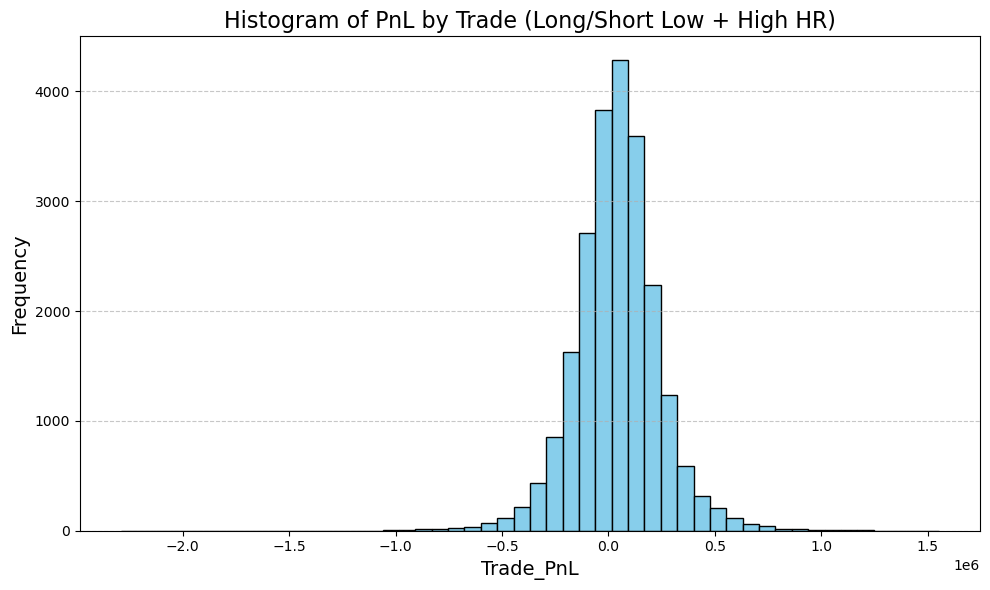

Hit Rate: 59.74%


In [38]:
trades = wklySeasn_b._full_tradeslist()

#trades = trades[(trades['AssetClass'] == 'eq-vol')]

# Plot a histogram of the 'Total PnL'
plt.figure(figsize=(10, 6))
plt.hist(trades['Trade_PnL'][:], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of PnL by Trade (Long/Short Low + High HR)', fontsize=16)
plt.xlabel('Trade_PnL', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

trades_hr = len(trades[trades['Std_PnL'] > 0])/len(trades)
print(f'Hit Rate: {trades_hr:.2%}')

In [39]:
trades_sorted = trades.sort_values('Std_PnL', ascending=False)
display(trades_sorted.head(20))
display(trades_sorted.tail(20))

Descr  AssetClass        Asset  FirstDate  \
Trade_ID                                                                 
2b4c_A11Cur_120  TRY DOLLAR FUTURE       fx-em   A11 Curncy 2018-08-06   
2b4c_SB1Com_7    SUGAR #11 (WORLD)   comm-soft   SB1 Comdty 1985-07-22   
2b4c_DED3In_116  SX5E Dividend Fut     eq-divf   DED3 Index 2024-06-10   
2b4c_SCO1Co_10   SGX Iron Ore 62%    comm-base  SCO1 Comdty 2019-01-28   
2b4c_CA1Com_43   MILL WHEAT EURO     comm-soft   CA1 Comdty 2006-07-17   
2b4c_KC1Com_173  COFFEE 'C' FUTURE   comm-soft   KC1 Comdty 1999-10-11   
2b4c_CO1Com_174  BRENT CRUDE FUTR   comm-enrgy   CO1 Comdty 2022-02-28   
2b4c_CL1Com_477  WTI CRUDE FUTURE   comm-enrgy   CL1 Comdty 2022-02-28   
2b4c_BTS1Co_18   Short Euro-BTP Fu       fi-eu  BTS1 Comdty 2016-10-24   
2b4c_CL1Com_23   WTI CRUDE FUTURE   comm-enrgy   CL1 Comdty 1990-07-30   
2b4c_MO1Com_142  ECX EMISSION       comm-enrgy   MO1 Comdty 2018-08-20   
2b4c_WN1Com_35   US ULTRA BOND CBT       fi-us   WN1 Comdty 2016-11-07   
2b4c_CA1Com_20   MILL WHEAT EURO     comm-soft   CA1 Comdty 2005-01-10   
2b4c_A11Cur_173  TRY DOLLAR FUTURE       fx-em   A11 Curncy 2023-08-21   
2b4c_DU1Com_304  EURO-SCHATZ FUT         fi-eu   DU1 Comdty 2023-11-27   
2b4c_Z1Inde_328  FTSE 100 IDX FUT        eq-eu    Z 1 Index 2014-12-08   
2b4c_TZT2Co_61   TTF NAT GAS F      comm-enrgy  TZT2 Comdty 2014-12-29   
2b4c_HO1Com_84   NY Harb ULSD Fut   comm-enrgy   HO1 Comdty 1999-10-04   
2b4c_RX1Com_55   EURO-BUND FUTURE        fi-eu   RX1 Comdty 1998-08-17   
2b4c_SFR8Co_45   3 MONTH SOFR FUT         stir  SFR8 Comdty 1995-05-01   

                  LastDate  TradeEntry  TradeExit  USD_Notional  Num_Lots  \
Trade_ID                                                                    
2b4c_A11Cur_120 2018-08-10        34.0       35.2    32,211,469     4,821   
2b4c_SB1Com_7   1985-07-26        10.8       12.2    15,075,290     1,244   
2b4c_DED3In_116 2024-06-14       163.2      151.1   -13,837,377    -785.0   
2b4c_SCO1Co_10  2019-02-01       -57.3      -44.8    -8,772,232     1,532   
2b4c_CA1Com_43  2006-07-21        38.2       49.5     6,494,461     2,684   
2b4c_KC1Com_173 1999-10-15       377.1      400.4    13,292,775      94.0   
2b4c_CO1Com_174 2022-03-04        67.2       91.2     2,887,880      43.0   
2b4c_CL1Com_477 2022-03-04        68.9       93.0     2,756,400      40.0   
2b4c_BTS1Co_18  2016-10-28       100.2      100.0  -470,568,739    -4,314   
2b4c_CL1Com_23  1990-08-03        71.8       76.3    27,159,300     378.0   
2b4c_MO1Com_142 2018-08-24        25.7       28.3    15,656,746     532.0   
2b4c_WN1Com_35  2016-11-11       176.1      163.2   -10,211,625     -58.0   
2b4c_CA1Com_20  2005-01-14        33.0       30.8    -8,635,025    -4,009   
2b4c_A11Cur_173 2023-08-25        43.2       42.4   -13,304,348    -8,352   
2b4c_DU1Com_304 2023-12-01       106.8      107.7    87,291,333     747.0   
2b4c_Z1Inde_328 2014-12-12       5,238      4,797    -6,937,346     -85.0   
2b4c_TZT2Co_61  2015-01-02        46.5       44.2   -22,530,364    -552.0   
2b4c_HO1Com_84  1999-10-08       -24.2      -33.0     1,882,671    -185.0   
2b4c_RX1Com_55  1998-08-21        48.3       50.2    15,413,525     293.0   
2b4c_SFR8Co_45  1995-05-05        82.1       82.6   177,670,725     866.0   

                 Trade_PnL  Price_PnL  20d_Price_Vol  Std_PnL  
Trade_ID                                                       
2b4c_A11Cur_120    948,654       1.27           0.06     19.5  
2b4c_SB1Com_7    1,242,147       1.33           0.07     19.4  
2b4c_DED3In_116    660,722      -12.1           0.62     19.4  
2b4c_SCO1Co_10   1,201,920       12.5           0.69     18.0  
2b4c_CA1Com_43   1,554,292       11.2           0.65     17.3  
2b4c_KC1Com_173    756,562       23.3           1.42     16.4  
2b4c_CO1Com_174    749,140       24.0           1.54     15.6  
2b4c_CL1Com_477    697,200       24.1           1.58     15.3  
2b4c_BTS1Co_18   1,131,085      -0.27           0.02     14.3  
2

Descr  AssetClass        Asset  FirstDate  \
Trade_ID                                                                 
2b4c_GX1Ind_145  DAX INDEX FUTURE        eq-eu    GX1 Index 2007-02-26   
2b4c_MO1Com_66   ECX EMISSION       comm-enrgy   MO1 Comdty 2013-09-02   
2b4c_VG1Ind_69   EURO STOXX 50           eq-eu    VG1 Index 2007-02-26   
2b4c_CD1Cur_5    C$ CURRENCY FUT         fx-dm   CD1 Curncy 1991-07-15   
2b4c_XTD1Cu_35   SGX TWD/USD MINI        fx-em  XTD1 Curncy 2022-11-07   
2b4c_BTS1Co_35   Short Euro-BTP Fu       fi-eu  BTS1 Comdty 2017-12-11   
2b4c_FV1Com_47   US 5YR NOTE (CBT)       fi-us   FV1 Comdty 2001-11-12   
2b4c_CL1Com_103  WTI CRUDE FUTURE   comm-enrgy   CL1 Comdty 1996-01-08   
2b4c_SFR8Co_149  3 MONTH SOFR FUT         stir  SFR8 Comdty 2001-11-12   
2b4c_SFR8Co_403  3 MONTH SOFR FUT         stir  SFR8 Comdty 2021-06-14   
2b4c_ES1Ind_76   S&P500 EMINI FUT        eq-us    ES1 Index 2007-02-26   
2b4c_SI1Com_120  SILVER FUTURE       comm-prec   SI1 Comdty 2004-12-06   
2b4c_SM1Com_167  SOYBEAN MEAL FUTR   comm-soft   SM1 Comdty 1998-10-05   
2b4c_RR1Com_271  ROUGH RICE (CBOT)   comm-soft   RR1 Comdty 2022-10-31   
2b4c_IB1Ind_131  IBEX 35 INDX FUTR       eq-eu    IB1 Index 2007-02-26   
2b4c_TZT2Co_76   TTF NAT GAS F      comm-enrgy  TZT2 Comdty 2016-04-18   
2b4c_TU1Com_290  US 2YR NOTE (CBT)       fi-us   TU1 Comdty 2021-06-14   
2b4c_OAT1Co_35   Euro-OAT Future         fi-eu  OAT1 Comdty 2020-03-09   
2b4c_XU1Ind_153  FTSE CHINA A50          eq-em    XU1 Index 2024-09-23   
2b4c_SF1Cur_206  CHF CURRENCY FUT        fx-dm   SF1 Curncy 2015-01-12   

                  LastDate  TradeEntry  TradeExit  USD_Notional  Num_Lots  \
Trade_ID                                                                    
2b4c_GX1Ind_145 2007-03-02       9,100      8,720    14,976,325      50.0   
2b4c_MO1Com_66  2013-09-06        12.5       13.3    -9,462,681    -573.0   
2b4c_VG1Ind_69  2007-03-02       2,822      2,594     7,765,280     209.0   
2b4c_CD1Cur_5   1991-07-19        82.9       82.0   108,313,110     1,306   
2b4c_XTD1Cu_35  2022-11-11        0.33       0.35   -16,551,520    -496.0   
2b4c_BTS1Co_35  2017-12-15       103.1      102.8   200,596,945     1,652   
2b4c_FV1Com_47  2001-11-16        68.4       65.5    30,898,438     452.0   
2b4c_CL1Com_103 1996-01-12        80.9       79.1    33,237,570     411.0   
2b4c_SFR8Co_149 2001-11-16        86.6       85.9    76,897,438     355.0   
2b4c_SFR8Co_403 2021-06-18       100.5      100.3   276,946,375     1,102   
2b4c_ES1Ind_76  2007-03-02       1,665      1,597    17,403,952     209.0   
2b4c_SI1Com_120 2004-12-10        17.9       16.5    18,218,220     204.0   
2b4c_SM1Com_167 1998-10-09      -496.6     -477.7    19,367,400    -390.0   
2b4c_RR1Com_271 2022-11-04        12.9       14.1    -7,198,200    -279.0   
2b4c_IB1Ind_131 2007-03-02       9,255      8,410     8,042,101      66.0   
2b4c_TZT2Co_76  2016-04-22        35.0       36.8   -30,278,658    -1,066   
2b4c_TU1Com_290 2021-06-18       112.9      112.6   455,610,797     2,018   
2b4c_OAT1Co_35  2020-03-13       158.5      153.2    70,123,019     392.0   
2b4c_XU1Ind_153 2024-09-27      11,245     13,511    -9,007,245    -801.0   
2b4c_SF1Cur_206 2015-01-16       125.2      143.5   -16,748,175    -107.0   

                 Trade_PnL  Price_PnL  20d_Price_Vol  Std_PnL  
Trade_ID                                                       
2b4c_GX1Ind_145   -483,880     -380.0           35.4    -10.7  
2b4c_MO1Com_66    -461,637       0.77           0.07    -11.0  
2b4c_VG1Ind_69    -463,414     -228.0           20.7    -11.0  
2b4c_CD1Cur_5     -973,280      -0.98           0.09    -11.2  
2b4c_XTD1Cu_35    -615,810       0.01           0.00    -11.2  
2b4c_BTS1Co_35    -516,418      -0.34           0.03    -11.3  
2b4c_FV1Com_47  -1,107,594      -2.83           0.25    -11.4  
2b4c_CL1Com_103   -573,700      -1.74           0.15    -11.5  
2b4c_SFR8Co_149   -581,638      -0.78           0.07    -11.9  
2

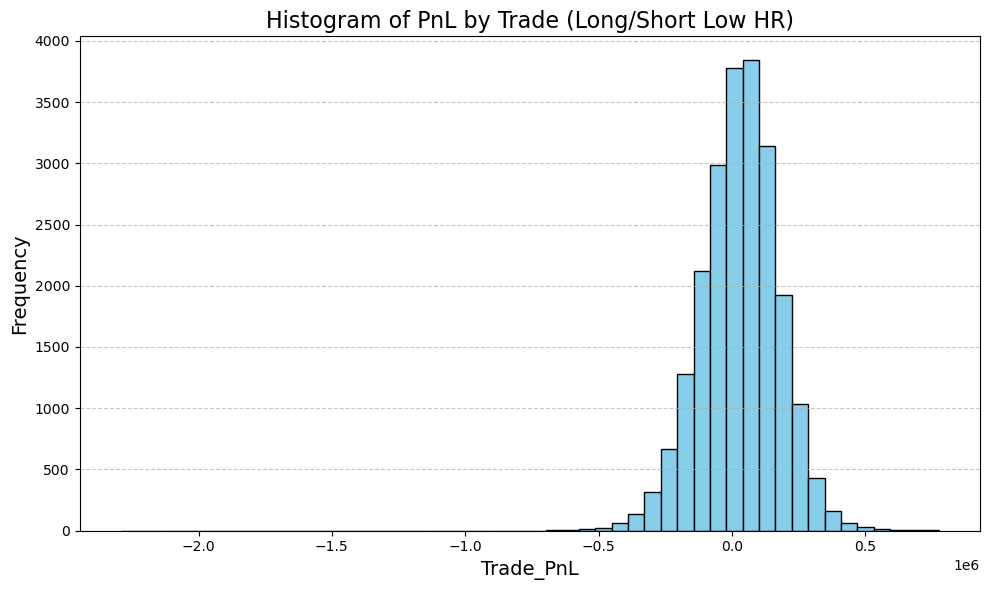

In [40]:
trades = wklySeasn_b_low._full_tradeslist()

# Plot a histogram of the 'Total PnL'
plt.figure(figsize=(10, 6))
plt.hist(trades['Trade_PnL'][:], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of PnL by Trade (Long/Short Low HR)', fontsize=16)
plt.xlabel('Trade_PnL', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

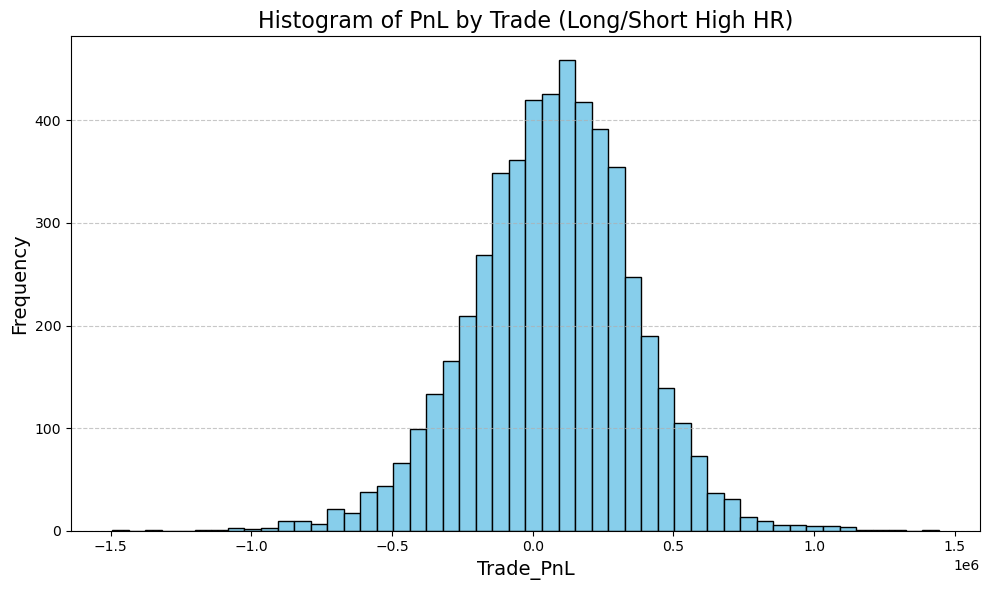

In [41]:
trades = wklySeasn_b_hi._full_tradeslist()

# Plot a histogram of the 'Total PnL'
plt.figure(figsize=(10, 6))
plt.hist(trades['Trade_PnL'][:], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of PnL by Trade (Long/Short High HR)', fontsize=16)
plt.xlabel('Trade_PnL', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

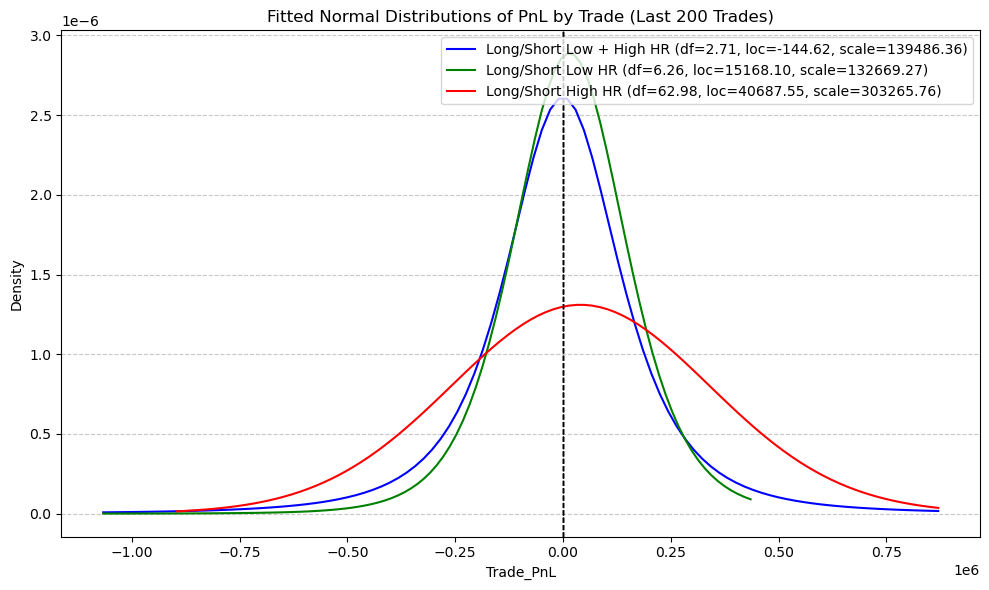

In [42]:
# Extract the 'Total PnL' data from the trades DataFrames
pnl_b = wklySeasn_b._full_tradeslist()['Trade_PnL'][-200:]
pnl_b_low = wklySeasn_b_low._full_tradeslist()['Trade_PnL'][-200:]
pnl_b_hi = wklySeasn_b_hi._full_tradeslist()['Trade_PnL'][-200:]

# Plot the fitted lines
plt.figure(figsize=(10, 6))
fit_and_plot_fat_tailed(pnl_b, 'Long/Short Low + High HR', 'blue')
fit_and_plot_fat_tailed(pnl_b_low, 'Long/Short Low HR', 'green')
fit_and_plot_fat_tailed(pnl_b_hi, 'Long/Short High HR', 'red')

# Add titles and labels
plt.title('Fitted Normal Distributions of PnL by Trade (Last 200 Trades)')
plt.xlabel('Trade_PnL')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

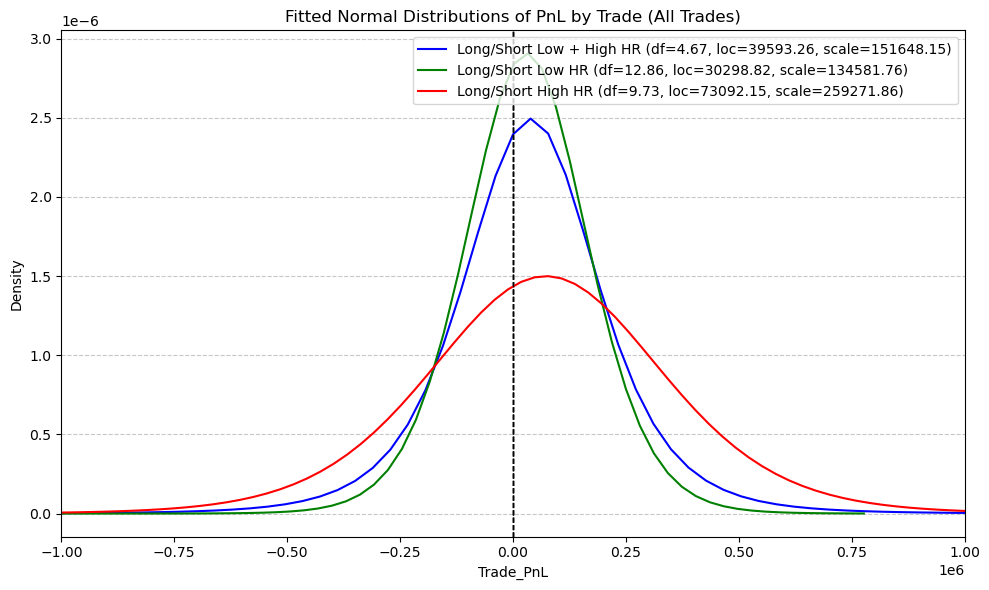

In [43]:

# Extract the 'Total PnL' data from the trades DataFrames
pnl_b = wklySeasn_b._full_tradeslist()['Trade_PnL'][:]
pnl_b_low = wklySeasn_b_low._full_tradeslist()['Trade_PnL'][:]
pnl_b_hi = wklySeasn_b_hi._full_tradeslist()['Trade_PnL'][:]

# Plot the fitted lines
plt.figure(figsize=(10, 6))
fit_and_plot_fat_tailed(pnl_b, 'Long/Short Low + High HR', 'blue')
fit_and_plot_fat_tailed(pnl_b_low, 'Long/Short Low HR', 'green')
fit_and_plot_fat_tailed(pnl_b_hi, 'Long/Short High HR', 'red')
# Add titles and labels
plt.title('Fitted Normal Distributions of PnL by Trade (All Trades)')
plt.xlabel('Trade_PnL')
plt.xlim(-1000000,1000000)
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [44]:
daily_returns.corr()

eq-us  stir  eq-as  eq-vol  fx-dm  fx-em  comm-enrgy  crypto  \
eq-us        1.00  0.00   0.06    0.23   0.04   0.06        0.02    0.02   
stir         0.00  1.00  -0.01    0.01   0.04  -0.00        0.02    0.02   
eq-as        0.06 -0.01   1.00    0.03   0.04   0.01        0.00   -0.00   
eq-vol       0.23  0.01   0.03    1.00   0.05   0.11        0.01    0.03   
fx-dm        0.04  0.04   0.04    0.05   1.00   0.10        0.03    0.00   
fx-em        0.06 -0.00   0.01    0.11   0.10   1.00        0.00    0.05   
comm-enrgy   0.02  0.02   0.00    0.01   0.03   0.00        1.00    0.00   
crypto       0.02  0.02  -0.00    0.03   0.00   0.05        0.00    1.00   
comm-prec    0.00 -0.02   0.01    0.02   0.08   0.05        0.03    0.01   
fi-eu       -0.00  0.30  -0.02    0.02   0.02   0.02        0.01    0.02   
eq-em        0.19  0.01   0.12    0.08   0.09   0.09        0.02    0.01   
comm-base    0.04  0.00   0.01    0.04   0.09   0.10        0.04    0.01   
fi-us       -0.01  0.33   0.02   -0.01   0.03   0.02        0.00    0.00   
fi-as       -0.01  0.02  -0.02   -0.01   0.01  -0.01       -0.01    0.00   
eq-eu        0.29  0.03   0.13    0.13   0.05   0.05        0.03    0.01   
eq-divf      0.09  0.02   0.04    0.16  -0.02   0.05        0.01    0.06   
Total        0.39  0.39   0.26    0.27   0.41   0.29        0.26    0.07   

            comm-prec  fi-eu  eq-em  comm-base  fi-us  fi-as  eq-eu  eq-divf  \
eq-us            0.00  -0.00   0.19       0.04  -0.01  -0.01   0.29     0.09   
stir            -0.02   0.30   0.01       0.00   0.33   0.02   0.03     0.02   
eq-as            0.01  -0.02   0.12       0.01   0.02  -0.02   0.13     0.04   
eq-vol           0.02   0.02   0.08       0.04  -0.01  -0.01   0.13     0.16   
fx-dm            0.08   0.02   0.09       0.09   0.03   0.01   0.05    -0.02   
fx-em            0.05   0.02   0.09       0.10   0.02  -0.01   0.05     0.05   
comm-enrgy       0.03   0.01   0.02       0.04   0.00  -0.01   0.03     0.01   
crypto           0.01   0.02   0.01       0.01   0.00   0.00   0.01     0.06   
comm-prec        1.00   0.00   0.03       0.06  -0.03   0.01   0.01     0.00   
fi-eu            0.00   1.00   0.01       0.01   0.21   0.04  -0.00     0.01   
eq-em            0.03   0.01   1.00       0.06   0.01  -0.03   0.18     0.09   
comm-base        0.06   0.01   0.06       1.00  -0.01   0.00   0.03     0.04   
fi-us           -0.03   0.21   0.01      -0.01   1.00  -0.01   0.02     0.01   
fi-as            0.01   0.04  -0.03       0.00  -0.01   1.00   0.01    -0.00   
eq-eu            0.01  -0.00   0.18       0.03   0.02   0.01   1.00     0.14   
eq-divf          0.00   0.01   0.09       0.04   0.01  -0.00   0.14     1.00   
Total            0.22   0.42   0.37       0.27   0.40   0.08   0.51     0.20   

            Total  
eq-us        0.39  
stir         0.39  
eq-as        0.26  
eq-vol       0.27  
fx-dm        0.41  
fx-em        0.29  
comm-enrgy   0.26  
crypto       0.07  
comm-prec    0.22  
fi-eu        0.42  
eq-em        0.37  
comm-base    0.27  
fi-us        0.40  
fi-as        0.08  
eq-eu        0.51  
eq-divf      0.20  
Total        1.00

In [45]:
trades = wklySeasn_b._full_tradeslist()
trades

Descr AssetClass        Asset  FirstDate  \
Trade_ID                                                                
2b4c_C1Comd_1    CORN FUTURE        comm-soft   C 1 Comdty 1985-01-28   
2b4c_US1Com_1    US LONG BOND(CBT)      fi-us   US1 Comdty 1985-02-04   
2b4c_C1Comd_2    CORN FUTURE        comm-soft   C 1 Comdty 1985-02-11   
2b4c_GC1Com_1    GOLD 100 OZ FUTR   comm-prec   GC1 Comdty 1985-02-19   
2b4c_FC1Com_1    CATTLE FEEDER FUT  comm-soft   FC1 Comdty 1985-02-25   
...                            ...        ...          ...        ...   
2b4c_ER6Com_233  3MO EURO EURIBOR        stir   ER6 Comdty 2024-11-25   
2b4c_RX1Com_360  EURO-BUND FUTURE       fi-eu   RX1 Comdty 2024-11-25   
2b4c_IK1Com_136  Euro-BTP Future        fi-eu   IK1 Comdty 2024-11-25   
2b4c_LN1Com_143  LME NICKEL FUTURE  comm-base   LN1 Comdty 2024-11-25   
2b4c_BTS1Co_121  Short Euro-BTP Fu      fi-eu  BTS1 Comdty 2024-11-25   

                  LastDate  TradeEntry  TradeExit  USD_Notional  Num_Lots  \
Trade_ID                                                                    
2b4c_C1Comd_1   1985-02-01       1,008      1,008    44,293,359     879.0   
2b4c_US1Com_1   1985-02-08       -50.4      -50.6   -12,399,938     246.0   
2b4c_C1Comd_2   1985-02-15       1,008      1,006   -96,293,844    -1,910   
2b4c_GC1Com_1   1985-02-22       1,267      1,256   -31,670,000    -250.0   
2b4c_FC1Com_1   1985-03-01       161.4      160.2   -46,321,800    -574.0   
...                    ...         ...        ...           ...       ...   
2b4c_ER6Com_233 2024-11-29        98.2       98.2   222,910,821     872.0   
2b4c_RX1Com_360 2024-11-29       134.6      136.4    38,982,906     278.0   
2b4c_IK1Com_136 2024-11-29       120.3      122.2    35,080,323     280.0   
2b4c_LN1Com_143 2024-11-29      15,801     15,815     4,740,339      50.0   
2b4c_BTS1Co_121 2024-11-29       107.5      107.8   111,566,279     996.0   

                 Trade_PnL  Price_PnL  20d_Price_Vol  Std_PnL  
Trade_ID                                                       
2b4c_C1Comd_1        325.0       0.00           1.26     0.00  
2b4c_US1Com_1      -56,500      -0.22           0.52    -0.42  
2b4c_C1Comd_2      232,025      -2.50           1.20     2.08  
2b4c_GC1Com_1      266,840      -10.4           2.08     5.00  
2b4c_FC1Com_1      356,800      -1.18           0.48     2.45  
...                    ...        ...            ...      ...  
2b4c_ER6Com_233    190,952       0.07           0.06     1.30  
2b4c_RX1Com_360    532,026       1.78           0.38     4.65  
2b4c_IK1Com_136    575,897       1.89           0.39     4.87  
2b4c_LN1Com_143      4,764       13.9          195.2     0.07  
2b4c_BTS1Co_121    331,006       0.29           0.12     2.45  

[22708 rows x 13 columns]

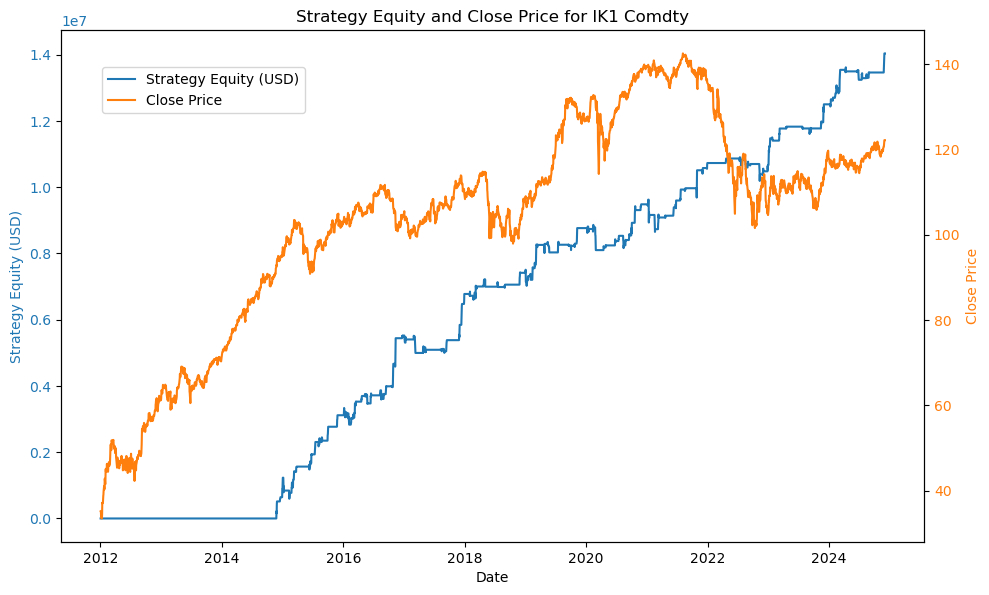

In [46]:
asst_an = 'IK1 Comdty' #########
filter_start_an = '01012012'
#filter_start_an = ''

inv = wklySeasn_b.backtest_asset(asst_an)
inv.set_index('Date', inplace=True)

if filter_start_an:
    filter_start_an = pd.to_datetime(filter_start_an, format='%d%m%Y')
    inv = inv[inv.index >= filter_start_an]
    inv['Strategy_Equity_USD'] = inv['Strategy_Equity_USD'] - inv['Strategy_Equity_USD'].iloc[0]   


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Strategy Equity on the primary axis
ax1.plot(inv.index, inv['Strategy_Equity_USD'], color='tab:blue', label='Strategy Equity (USD)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Strategy Equity (USD)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary axis to plot the Close price
ax2 = ax1.twinx()
ax2.plot(inv.index, inv['Close'], color='tab:orange', label='Close Price')
ax2.set_ylabel('Close Price', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legends
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title(f'Strategy Equity and Close Price for {asst_an}')
plt.show()



In [47]:
wklyPerf = {}

for i in range(1, 53):
    inv_wk = inv[inv['ISO_Week'] == i]
    wklyPerf[f'w{i}'] = inv_wk['Strategy_PnL_USD'].cumsum()

wklyPerf = pd.DataFrame(wklyPerf).ffill()



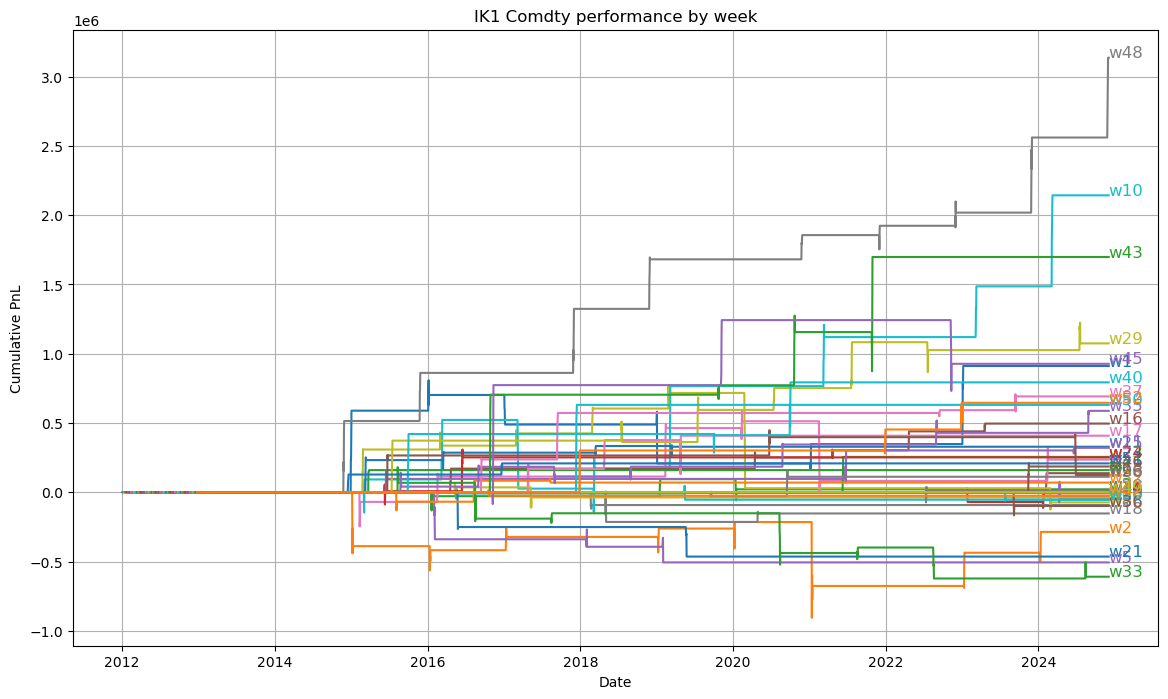

Sharpe Ratio  Cumulative PnL
w48          1.07       3,135,674
w10          0.66       2,142,651
w37          0.63         691,673
w16          0.63         495,670
w51          0.58         208,412
w43          0.57       1,697,797
w29          0.55       1,074,308
w52          0.51         645,652
w40          0.49         793,043
w6           0.48         137,718
w23          0.46         255,187
w50          0.46         630,660
w35          0.46         587,554
w11          0.39         328,531
w45          0.35         926,960
w1           0.34         911,410
w46          0.34         185,856
w13          0.31         159,875
w25          0.28         320,744
w38          0.26         111,761

In [48]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))


wks_to_plot = []

# Add traces for each week
for week in wklyPerf.columns:
    if len(wks_to_plot) == 0 or week in wks_to_plot:
        ax.plot(wklyPerf.index, wklyPerf[week], label=week)
        # Add the week label next to the line
        ax.text(wklyPerf.index[-1], wklyPerf[week].iloc[-1], week, fontsize=12, color=ax.get_lines()[-1].get_color())

# Update layout
ax.set_title(f'{asst_an} performance by week')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative PnL')
ax.grid(True)

# Show the figure
plt.show()

wklyPerfpnl = wklyPerf.diff()
wklyPerfmean = wklyPerfpnl.mean()
wklyPerfstd = wklyPerfpnl.std()

wklyPerfsr = (wklyPerfmean / wklyPerfstd * np.sqrt(252)).sort_values(ascending=False)


# Concatenate Sharpe ratios and PnL into one DataFrame
combined_metrics = pd.concat([wklyPerfsr, wklyPerf.iloc[-1]], axis=1)
combined_metrics.columns = ['Sharpe Ratio', 'Cumulative PnL']

# Display the combined DataFrame sorted by Sharpe Ratio
combined_metrics_sorted = combined_metrics.sort_values(by='Sharpe Ratio', ascending=False).dropna()
combined_metrics_sorted.head(20)

In [49]:
trades_ik = trades[trades['Asset'] == asst_an]
trades_ik = trades_ik[trades_ik['FirstDate'] > filter_start_an]

trades_ik

trades_filt = trades[trades['FirstDate'] > filter_start_an]



hit_rate_ik = (trades_ik['Trade_PnL'] > 0).sum() / len(trades_ik)
hit_rate_overall = (trades_filt['Trade_PnL'] > 0).sum() / len(trades_filt)

print(f'Hit rate for {asst_an}: {hit_rate_ik:.2%}')
print(f'Overall hit rate: {hit_rate_overall:.2%}')


Hit rate for IK1 Comdty: 70.59%
Overall hit rate: 59.84%


/var/folders/m4/1ljrqkl53mx809bbs_bwc0jr0000gn/T/ipykernel_43629/3077771809.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trades_ik['pct returns'].replace([trades_ik['pct returns'].max(), trades_ik['pct returns'].min()], np.nan, inplace=True)


<Axes: xlabel='Trade_ID'>

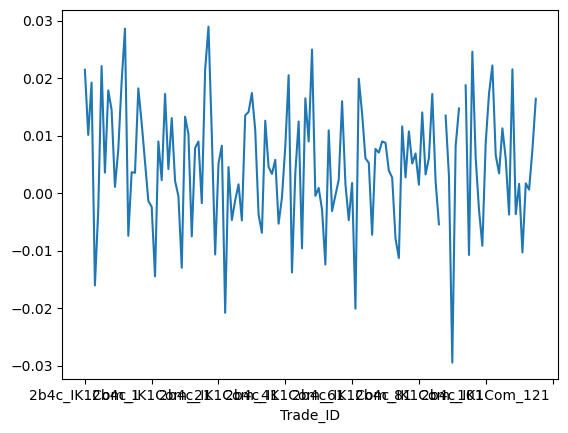

In [50]:
trades_ik['pct returns'] = trades_ik['Trade_PnL'] / np.abs(trades_ik['USD_Notional'])
trades_ik['pct returns'].replace([trades_ik['pct returns'].max(), trades_ik['pct returns'].min()], np.nan, inplace=True)
trades_ik['pct returns'].plot()

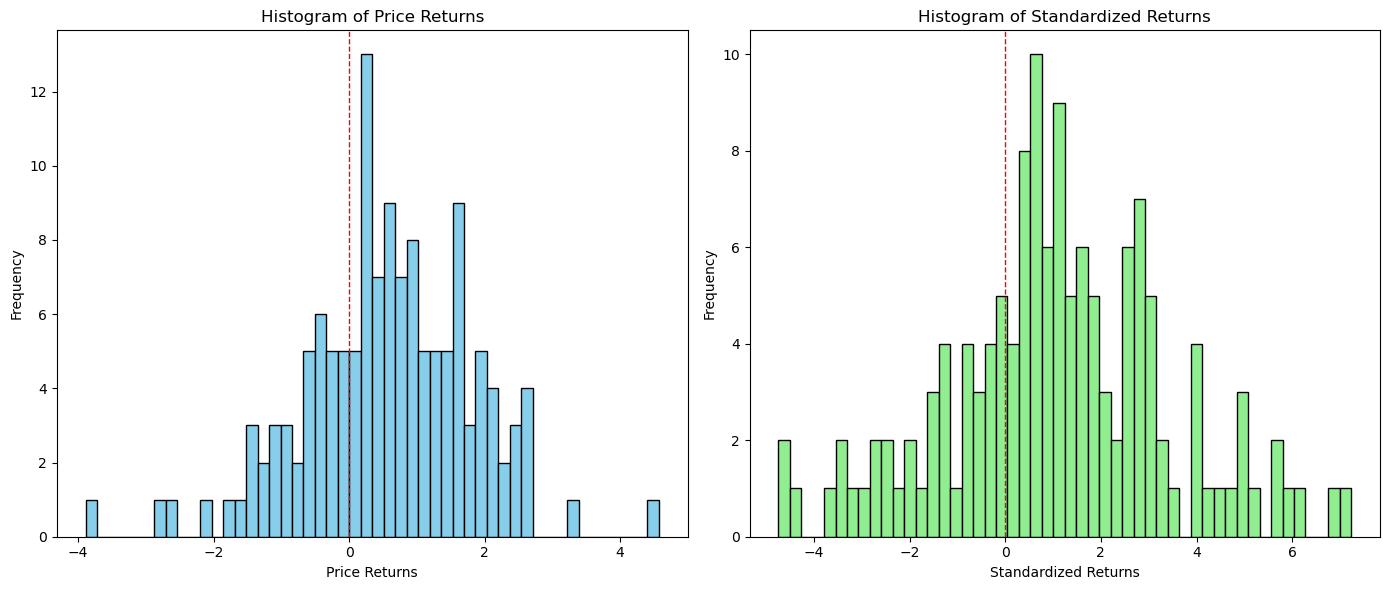

In [51]:
from scipy.stats import t

trades_ik['price returns'] = (trades_ik['TradeExit'] - trades_ik['TradeEntry'])*np.sign(trades_ik['Num_Lots'])
trades_ik['std returns'] = trades_ik['price returns'] / np.abs(trades_ik['20d_Price_Vol'])
trades_ik

# Plot histograms of 'price returns' and 'std returns'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for 'price returns'
axes[0].hist(trades_ik['price returns'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Price Returns')
axes[0].set_xlabel('Price Returns')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
# Histogram for 'std returns'
axes[1].hist(trades_ik['std returns'], bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title('Histogram of Standardized Returns')
axes[1].set_xlabel('Standardized Returns')
axes[1].set_ylabel('Frequency')
axes[1].axvline(0, color='red', linestyle='--', linewidth=1)


plt.tight_layout()
plt.show()


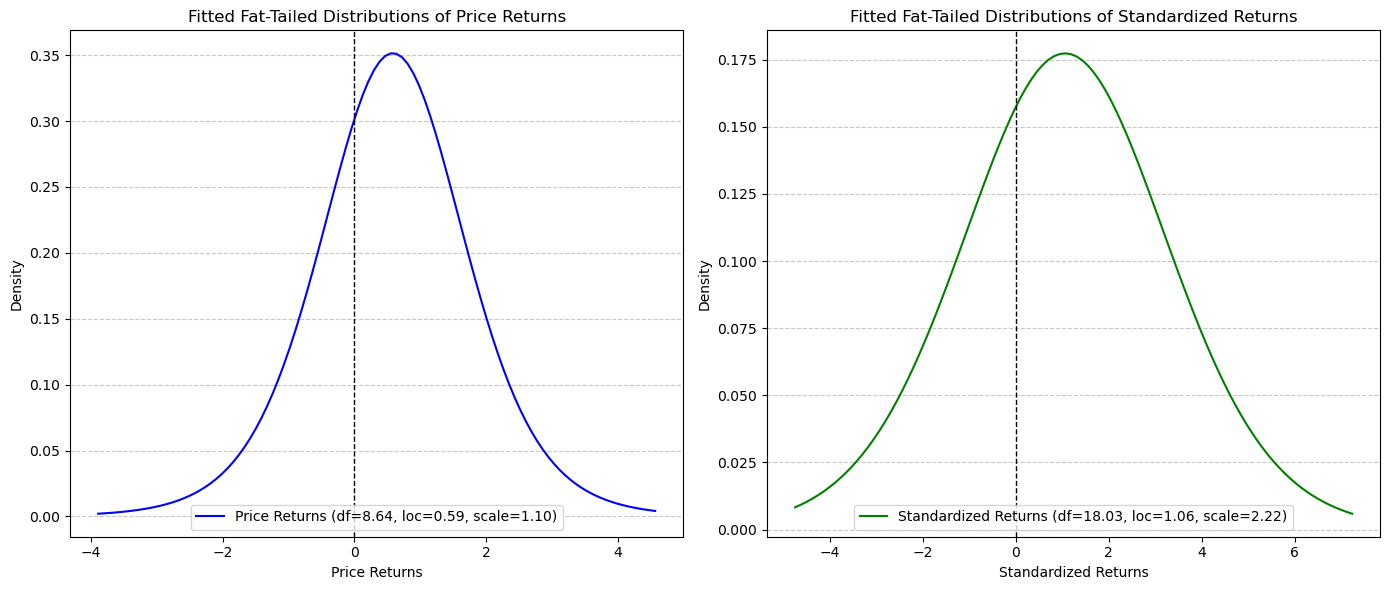

In [52]:
from scipy.stats import t
import matplotlib.pyplot as plt
import numpy as np

# Define a function to fit a fat-tailed normal distribution to the histogram data
def fit_and_plot_fat_tailed2(data, label, color, ax):
    # Fit a t-distribution to the data
    df, loc, scale = t.fit(data)
    
    # Plot the fitted line
    x = np.linspace(min(data), max(data), 100)
    p = t.pdf(x, df, loc, scale)
    ax.plot(x, p, label=f'{label} (df={df:.2f}, loc={loc:.2f}, scale={scale:.2f})', color=color)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the fitted lines for price returns
fit_and_plot_fat_tailed2(trades_ik['price returns'], 'Price Returns', 'blue', axes[0])
axes[0].set_title('Fitted Fat-Tailed Distributions of Price Returns')
axes[0].set_xlabel('Price Returns')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot the fitted lines for standardized returns
fit_and_plot_fat_tailed2(trades_ik['std returns'], 'Standardized Returns', 'green', axes[1])
axes[1].set_title('Fitted Fat-Tailed Distributions of Standardized Returns')
axes[1].set_xlabel('Standardized Returns')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [53]:
# Filter trades with negative values in both 'price returns' and 'std returns'
negative_trades_price = trades_ik[(trades_ik['price returns'] < 0)]
negative_trades_std = trades_ik[(trades_ik['std returns'] < 0)]
# Count the number of such trades
neg_px = len(negative_trades_price)
neg_std = len(negative_trades_std)

print(f'Number of trades with negative price returns: {neg_px}')
print(f'Number of trades with negative standardized returns: {neg_std}')

Number of trades with negative price returns: 40
Number of trades with negative standardized returns: 40


In [54]:
trades_ik['pct returns'].mean() * 100

0.5020349710134433

<Axes: xlabel='Trade_ID'>

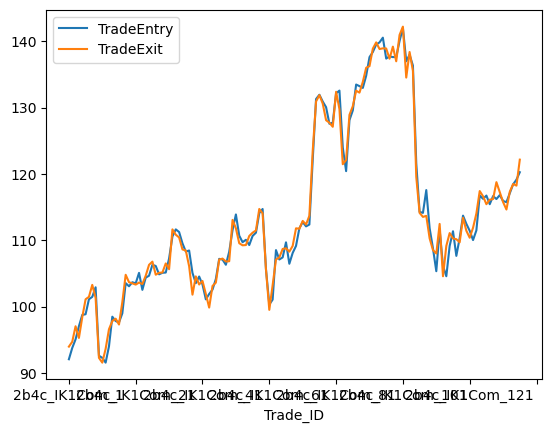

In [55]:
trades_ik[['TradeEntry', 'TradeExit']].plot()

In [56]:
pct_ret_by_asst = {}
pct_ret_by_asst_med = {}
pct_hr_by_asst = {}
num_trades = {}

for asst in trades['Asset'].unique():
    trades_asst = trades_filt[trades_filt['Asset'] == asst]
    trades_asst['pct returns'] = trades_filt['Std_PnL']
    trades_asst['pct returns'].replace([trades_asst['pct returns'].max(), trades_asst['pct returns'].min()], np.nan, inplace=True)
    pct_ret_by_asst_med[asst] = trades_asst['pct returns'].median()
    pct_ret_by_asst[asst] = trades_asst['pct returns'].mean()
    num_trades[asst] = len(trades_asst)

    pct_hr_by_asst[asst] = len(trades_asst[trades_asst['pct returns'] > 0]) / len(trades_asst) if len(trades_asst) > 0 else 0


pct_ret_df = pd.DataFrame.from_dict(pct_ret_by_asst, orient='index', columns=['Mean_Return_Std']).sort_values(by='Mean_Return_Std', ascending=False)
pct_ret_med_df = pd.DataFrame.from_dict(pct_ret_by_asst_med, orient='index', columns=['Median_Return_Std']).sort_values(by='Median_Return_Std', ascending=False)
pct_hr_df = pd.DataFrame.from_dict(pct_hr_by_asst, orient='index', columns=['Hit_Rate']).sort_values(by='Hit_Rate', ascending=False)
num_trades_df = pd.DataFrame.from_dict(num_trades, orient='index', columns=['Num_Trades']).sort_values(by='Num_Trades', ascending=False)

asst_stat_df = pd.concat([pct_ret_df, pct_ret_med_df,pct_hr_df, num_trades_df], axis=1).sort_values(by='Mean_Return_Std', ascending=False)

display(asst_stat_df.head(30))
display(asst_stat_df.tail(20))

/var/folders/m4/1ljrqkl53mx809bbs_bwc0jr0000gn/T/ipykernel_43629/649257974.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_asst['pct returns'] = trades_filt['Std_PnL']
/var/folders/m4/1ljrqkl53mx809bbs_bwc0jr0000gn/T/ipykernel_43629/649257974.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the ori

Mean_Return_Std  Median_Return_Std  Hit_Rate  Num_Trades
QZ1 Index               1.28               0.79      0.69          13
HO1 Comdty              1.17               0.85      0.67          39
MND3 Index              1.10               1.14      0.67          33
ASD3 Index              1.08               0.78      0.59          54
TZT2 Comdty             1.07               1.08      0.67         155
IK1 Comdty              1.06               1.00      0.70         136
IB1 Index               0.98               0.95      0.59          34
CA1 Comdty              0.94               0.66      0.61         160
G 1 Comdty              0.93               0.63      0.71           7
A11 Curncy              0.93               0.76      0.63         171
PLE1 Curncy             0.92               0.92      0.69          49
QC1 Comdty              0.91               1.11      0.65          57
HR1 Curncy              0.91               1.07      0.66          94
KO1 Curncy              0.85               1.09      0.66          65
BTC1 Curncy             0.81               0.38      0.58          33
PL1 Comdty              0.76               0.80      0.61         132
RR1 Comdty              0.74               0.67      0.61         153
GC1 Comdty              0.72               0.73      0.65         114
YW1 Comdty              0.72               0.71      0.63         169
SCO1 Comdty             0.70               0.41      0.56          64
TY1 Comdty              0.70               1.04      0.58          43
US1 Comdty              0.69               0.78      0.65         115
IR6 Comdty              0.68               0.71      0.59          81
XID1 Curncy             0.68               0.63      0.63          57
BO1 Comdty              0.68               0.53      0.61         141
DED3 Index              0.68               0.68      0.65         125
EC1 Curncy              0.67               0.85      0.58         115
LN1 Comdty              0.67               0.67      0.59         143
SFR8 Comdty             0.66               0.57      0.60         139
LA1 Comdty              0.65               0.66      0.60         172

Mean_Return_Std  Median_Return_Std  Hit_Rate  Num_Trades
QW1 Comdty              0.27               0.56      0.56          80
JY1 Curncy              0.26               0.32      0.53         110
VG1 Index               0.26               0.56      0.56         131
NO1 Curncy              0.25               0.40      0.53         157
KC1 Comdty              0.24               0.43      0.62         110
CF1 Index               0.23               0.51      0.62         160
SE1 Curncy              0.19               0.41      0.54          80
TP1 Index               0.17               0.37      0.56         132
TU1 Comdty              0.17               0.33      0.52         117
RTY1 Index              0.15              -0.09      0.42          48
SF1 Curncy              0.13               0.24      0.55         103
XU1 Index               0.08              -0.03      0.48         153
SB1 Comdty              0.07               0.10      0.52         123
NV1 Curncy              0.02               0.41      0.51          81
RS1 Comdty             -0.08              -0.12      0.47         112
S 1 Comdty             -0.39              -0.01      0.45          29
PE1 Curncy             -0.58              -0.25      0.36          11
XB1 Comdty             -0.67              -0.70      0.37          27
KAA1 Comdty            -1.28              -0.53      0.14           7
SM1 Index                NaN                NaN      0.00           1

In [57]:
trades_ik.to_clipboard()

need to do some analysis on profit taking or stop out rules. Seasonality shouldn't be something that causes huge moves and is a subtle effect. So if the trade within 2 days of being in a trade for example has deviated a long way either way it is likely due to factors extrinsic to seasonality, and we should use that to stop out or take profit on trades. Maybe some rule where if the return has been 2*the average recent return just close out, or if the price breaches the 21d ema trend filter, stop out.

Another look at profile of weeks. Seems weeks that dont generally make money never end up turning to make money later anyway, so we should maybe look at historical perf for that week and do something like the worst 5 rolling weeks you just don't trade. 

In [58]:
ikmonthly = wklySeasn_b.strat_monthly_pnl(filter_assets=[asst_an])
ikmonthly

1        2        3       4        5        6       7        8  \
Year                                                                         
2009      NaN      NaN      NaN     NaN      NaN      NaN     NaN      NaN   
2010     0.00     0.00     0.00    0.00     0.00     0.00    0.00     0.00   
2011     0.00     0.00     0.00    0.00     0.00     0.00    0.00     0.00   
2012     0.00     0.00     0.00    0.00     0.00     0.00    0.00     0.00   
2013     0.00     0.00     0.00    0.00     0.00     0.00    0.00     0.00   
2014     0.00     0.00     0.00    0.00     0.00     0.00    0.00     0.00   
2015  -37,330  239,033  484,532    0.00     0.00  369,437 372,610   40,710   
2016   55,738 -156,355  511,165 170,535 -224,443  244,083    0.00  -47,736   
2017 -117,878  111,111 -518,569 168,047  -72,696     0.00    0.00  -92,860   
2018  -42,505   25,279  242,868 208,366 -214,140     0.00  -9,921   71,195   
2019  -32,052  268,449  605,842  31,785 -258,090     0.00 231,791     0.00   
2020  -26,372 -638,258     0.00 142,172     0.00  131,987 157,256 -126,780   
2021 -321,081 -430,153  353,686  51,718     0.00  460,715 331,133   39,653   
2022     0.00     0.00     0.00 136,315     0.00     0.00 -46,873 -105,455   
2023  732,973     0.00  366,122  56,177     0.00     0.00 -54,191     0.00   
2024  195,337  237,138  608,200 -46,283     0.00 -253,899  48,761  171,430   

           9      10       11        12  Annual_PnL  Sharpe_Ratio  Annual_Vol  \
Year                                                                            
2009    0.00    0.00     0.00      0.00        0.00           NaN        0.00   
2010    0.00    0.00     0.00      0.00        0.00           NaN        0.00   
2011    0.00    0.00     0.00      0.00        0.00           NaN        0.00   
2012    0.00    0.00     0.00      0.00        0.00           NaN        0.00   
2013    0.00    0.00     0.00      0.00        0.00           NaN        0.00   
2014    0.00    0.00  514,257   365,436     879,693          2.00     435,659   
2015 195,342 224,928  347,135      0.00   2,236,397          2.41     917,463   
2016 320,490 678,875  773,189    80,456   2,405,996          2.22   1,062,942   
2017 383,379    0.00  291,276 1,103,141   1,254,952          1.64     757,942   
2018    0.00    0.00  357,412      0.00     638,555          0.99     635,078   
2019 -27,107  60,133  469,085      0.00   1,349,837          1.47     913,383   
2020 197,490 705,950  174,733      0.00     718,177          0.85     830,866   
2021    0.00 541,876   -4,626   223,371   1,246,292          1.03   1,193,971   
2022 -13,503    0.00 -326,882   299,066     -57,333         -0.09     606,323   
2023   464.4    0.00  502,056   225,691   1,829,293          2.61     693,917   
2024    0.00    0.00  575,897      0.00   1,536,581          2.19     747,223   

      Hit_Rate  Profit_Factor  Worst_Drawdown  
Year                                           
2009      0.00            NaN            0.00  
2010       NaN            NaN            0.00  
2011       NaN            NaN            0.00  
2012       NaN            NaN            0.00  
2013       NaN            NaN            0.00  
2014      0.89           14.9         -63,280  
2015      0.65           2.41        -635,656  
2016      0.59           2.05        -502,703  
2017      0.58           1.87        -525,336  
2018      0.62           1.52        -251,481  
2019      0.55           1.72        -485,321  
2020      0.54           1.36        -761,804  
2021      0.60           1.57        -972,553  
2022      0.50           0.96        -715,854  
2023      0.55           3.43        -220,810  
2024      0.63           2.25        -375,931

1          2          3          4          5          6  \
Year                                                                    
1985    47,525    993,590  1,609,628  1,888,610  1,959,297 -1,414,168   
1986   203,170  1,856,886    -46,071 -2,637,163  1,382,510    466,506   
1987   -68,673  1,062,426   -612,367 -1,789,423   -124,124  1,447,338   
1988    12,281    536,536    771,662  1,204,900  2,228,370    -66,188   
1989   837,794 -1,274,794    951,724    302,133    747,648    256,353   
1990   597,382    856,328    782,592    588,617  1,459,749  1,598,836   
1991   194,096   -108,653 -1,066,836    328,219    141,814    522,268   
1992   570,380   -801,558  1,657,225    372,043    -73,084  1,493,736   
1993 1,773,883    401,889   -713,724  1,223,133    284,608  1,451,642   
1994   -98,341  2,140,150  3,595,990   -180,037  1,311,236  1,177,968   
1995    25,091  1,695,485    949,775  2,547,423  2,914,884  1,779,174   
1996   489,500  3,025,892    276,276  2,244,903 -1,632,863    509,944   
1997 3,791,234  1,415,214  1,955,124    114,672  2,345,629   -936,334   
1998 2,322,580  1,673,700  2,795,948  2,591,076  2,696,077   -389,456   
1999 1,473,369  2,806,842   -154,522  3,557,851    227,322  4,032,855   
2000 3,779,223  3,757,844    -40,237  2,325,633  2,265,709  3,702,584   
2001 2,204,505   -678,811    985,926    642,229    794,477  1,279,985   
2002 3,424,991  1,062,115  3,416,099  1,806,859  1,122,283  5,362,703   
2003 1,792,433  1,353,316   -585,427  2,363,891  6,543,317  1,905,520   
2004  -299,879  2,678,491  1,059,835 -6,376,584  3,529,145    372,939   
2005 2,382,264  3,749,357  3,672,138  2,932,940  3,643,106  3,362,562   
2006 3,549,463   -388,261    380,633  4,781,247  1,855,066  2,379,145   
2007 2,677,685 -3,082,085    688,405  6,565,309  2,557,605    379,968   
2008 3,117,836  1,314,220    296,989  5,289,459  5,617,800    251,957   
2009 4,996,417    180,970 -2,818,712  3,008,772  2,965,269  4,340,738   
2010 9,351,888    771,282  1,752,371  3,062,742   -269,669    779,328   
2011   682,406  3,290,608  3,693,662  5,047,714  2,574,380   -725,498   
2012   455,767  1,007,097  1,892,394  2,185,227  7,096,036   -639,505   
2013 2,302,370  1,330,156  3,101,759 -2,551,722   -661,113  4,105,059   
2014  -268,991  1,804,435  5,953,875  8,475,341  2,808,011  1,372,583   
2015 3,265,050  3,506,363  4,262,871 -2,728,325  1,388,021     -5,213   
2016 3,820,920   -256,508  4,164,449  2,622,734  2,252,465  3,072,138   
2017 6,452,976  3,899,344  1,614,594  2,928,600  4,786,941  1,526,893   
2018 5,381,919   -651,495 -2,472,603  3,214,505  3,597,181    966,198   
2019 4,447,412  5,754,447 -2,154,060  6,368,028  6,471,266  1,007,996   
2020 1,739,906   -305,208   -737,718  1,260,622  4,181,495  4,371,934   
2021   906,873  2,829,760  2,651,625    545,402    660,104    932,086   
2022 6,094,901  2,103,384  3,591,406    739,963  3,122,263  2,322,095   
2023 6,497,643  2,691,158  1,092,544  6,258,946    541,537  3,463,234   
2024   340,434  3,938,500  1,735,986 -2,334,656 -2,115,973  3,555,456   

              7          8          9         10         11         12  \
Year                                                                     
1985  1,606,195     31,712   -196,664  2,689,665   -780,624    980,653   
1986    370,362    238,477    517,656    638,590   -464,769  1,495,837   
1987   -864,425    717,501    498,854  1,114,980    976,950     40,010   
1988    -89,576  1,122,200  1,357,351  1,517,790  1,143,275  1,140,709   
1989  1,117,404   -671,103    735,014 -1,985,056    -38,013    268,052   
1990  2,369,979   -142,028    171,041  1,178,207  1,536,720   -567,863   
1991   -778,522    410,707    537,304  2,644,824    703,624  2,001,820   
1992  4,764,871  3,315,012    771,109  2,747,040    -49,429   -605,906   
1993  1,445,786   -377,641  1,751,191  3,635,976    971,475    549,832   
1994  1,328,812  1,796,398  2,907,767  1,785,712   -109,737   -678,887   
1995  1,686,720   -137,712   -187,579  2,625,353   -690,10

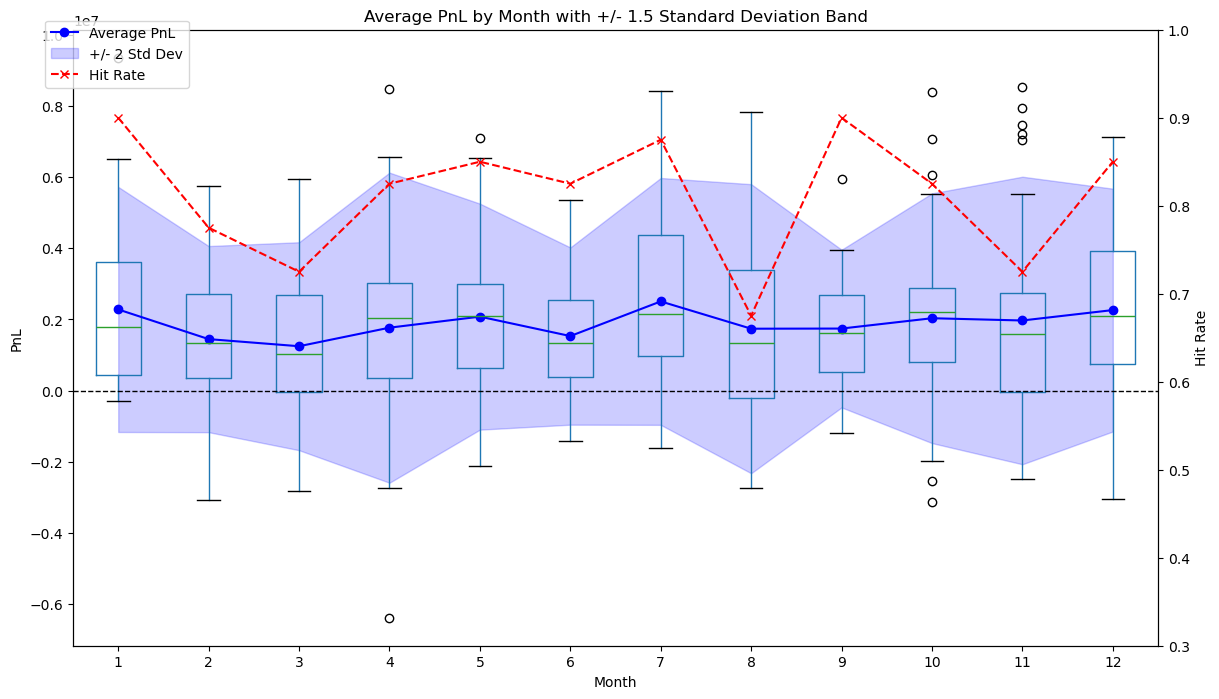

In [59]:
final_monthly = wklySeasn_b.strat_monthly_pnl(filter_assets=[])

final_monthly = final_monthly.dropna(subset=['Sharpe_Ratio'])

final_monthly = final_monthly
display(final_monthly)

# Assuming final_monthly is your DataFrame with monthly PnL data
monthly_pnl = final_monthly.iloc[:, :12]  # Extract the first 12 columns for monthly PnL
monthly_pnl = monthly_pnl.apply(pd.to_numeric, errors='coerce')  # Ensure all data is numeric

# Calculate average PnL and standard deviation for each month
average_pnl = monthly_pnl.mean()
std_pnl = monthly_pnl.std()

# Calculate hit rate for each month
hit_rate = (monthly_pnl > 0).mean()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the box plot for each month
monthly_pnl.boxplot(ax=ax1, grid=False)
ax1.set_title('Average PnL by Month with +/- 1.5 Standard Deviation Band')
ax1.set_xlabel('Month')
ax1.set_ylabel('PnL')
ax1.axhline(0, color='black', linewidth=1, linestyle='--')

# Plot the average PnL and +/- 2 standard deviation band
months = range(1, 13)
ax1.plot(months, average_pnl, color='blue', marker='o', label='Average PnL')
ax1.fill_between(months, average_pnl - 1.5 * std_pnl, average_pnl + 1.5 * std_pnl, color='blue', alpha=0.2, label='+/- 2 Std Dev')

# Create a secondary axis to plot the hit rate
ax2 = ax1.twinx()
ax2.plot(months, hit_rate, color='red', marker='x', linestyle='--', label='Hit Rate')
ax2.set_ylabel('Hit Rate')
ax2.set_ylim(0.3, 1)

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

In [60]:
# Calculate the average PnL of all months
average_of_all_months = average_pnl.mean()

# Create a list with the weight for each month
weights = (average_pnl / average_of_all_months).tolist()

# Round weights to the nearest 0.05
weights = [round(w * 20) / 20 for w in weights]

# Cap weights to 1.25 and floor to 0.75
weights = [min(max(w, 0.5), 1.5) for w in weights]

# Display the weights
weights
weights = [1]*6+[1.5]*6
weights

[1, 1, 1, 1, 1, 1, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]

In [125]:

    
hr_t_long = [0.53, 0.75]
hr_t_short = [0.47, 0.25]
ret_t = [1.75, 1.25]
risk_scale = [1, 2]


params_b_rescale ={
    'X_years': 6,
    'ewma_span': 6,
    'hr_threshold_long': hr_t_long,
    'hr_threshold_short': hr_t_short,
    'ret_threshold': ret_t,
    'min_lb': 5,
    'wks_to_trade': [], # [2,3,6,9,10,11,15,16,22,27,32,34,36, 37,40, 41,42,44,45,46,47,48,52],
    'vol_filter': (15, 45, 0.75),
    'trend_filter': ('EMA',21),
    'trade_direction': 'both',
    'risk_scale': risk_scale
}

wklySeasn_b_rescale = TradingRule(
    market_data=market_data,
    trading_rule_function=wkly_seasn_simple,
    trading_params=params_b_rescale,
    position_sizing_params=pSizeParamsUse,
    cont_rule=False,
    bt_folder=bt_folder,
    excl_assets=['comm-soft'],
    strat_descr='Type2 Seasonality Strategy Long/Short with TF (21 EMA) and Vol Filter (15, 45, 0.75), Hi+Lo HR (1:2)'
    
)

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning:

invalid value encountered in reduce

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning:

invalid value encountered in reduce

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning:

invalid value encountered in reduce

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning:

invalid value encountered in reduce



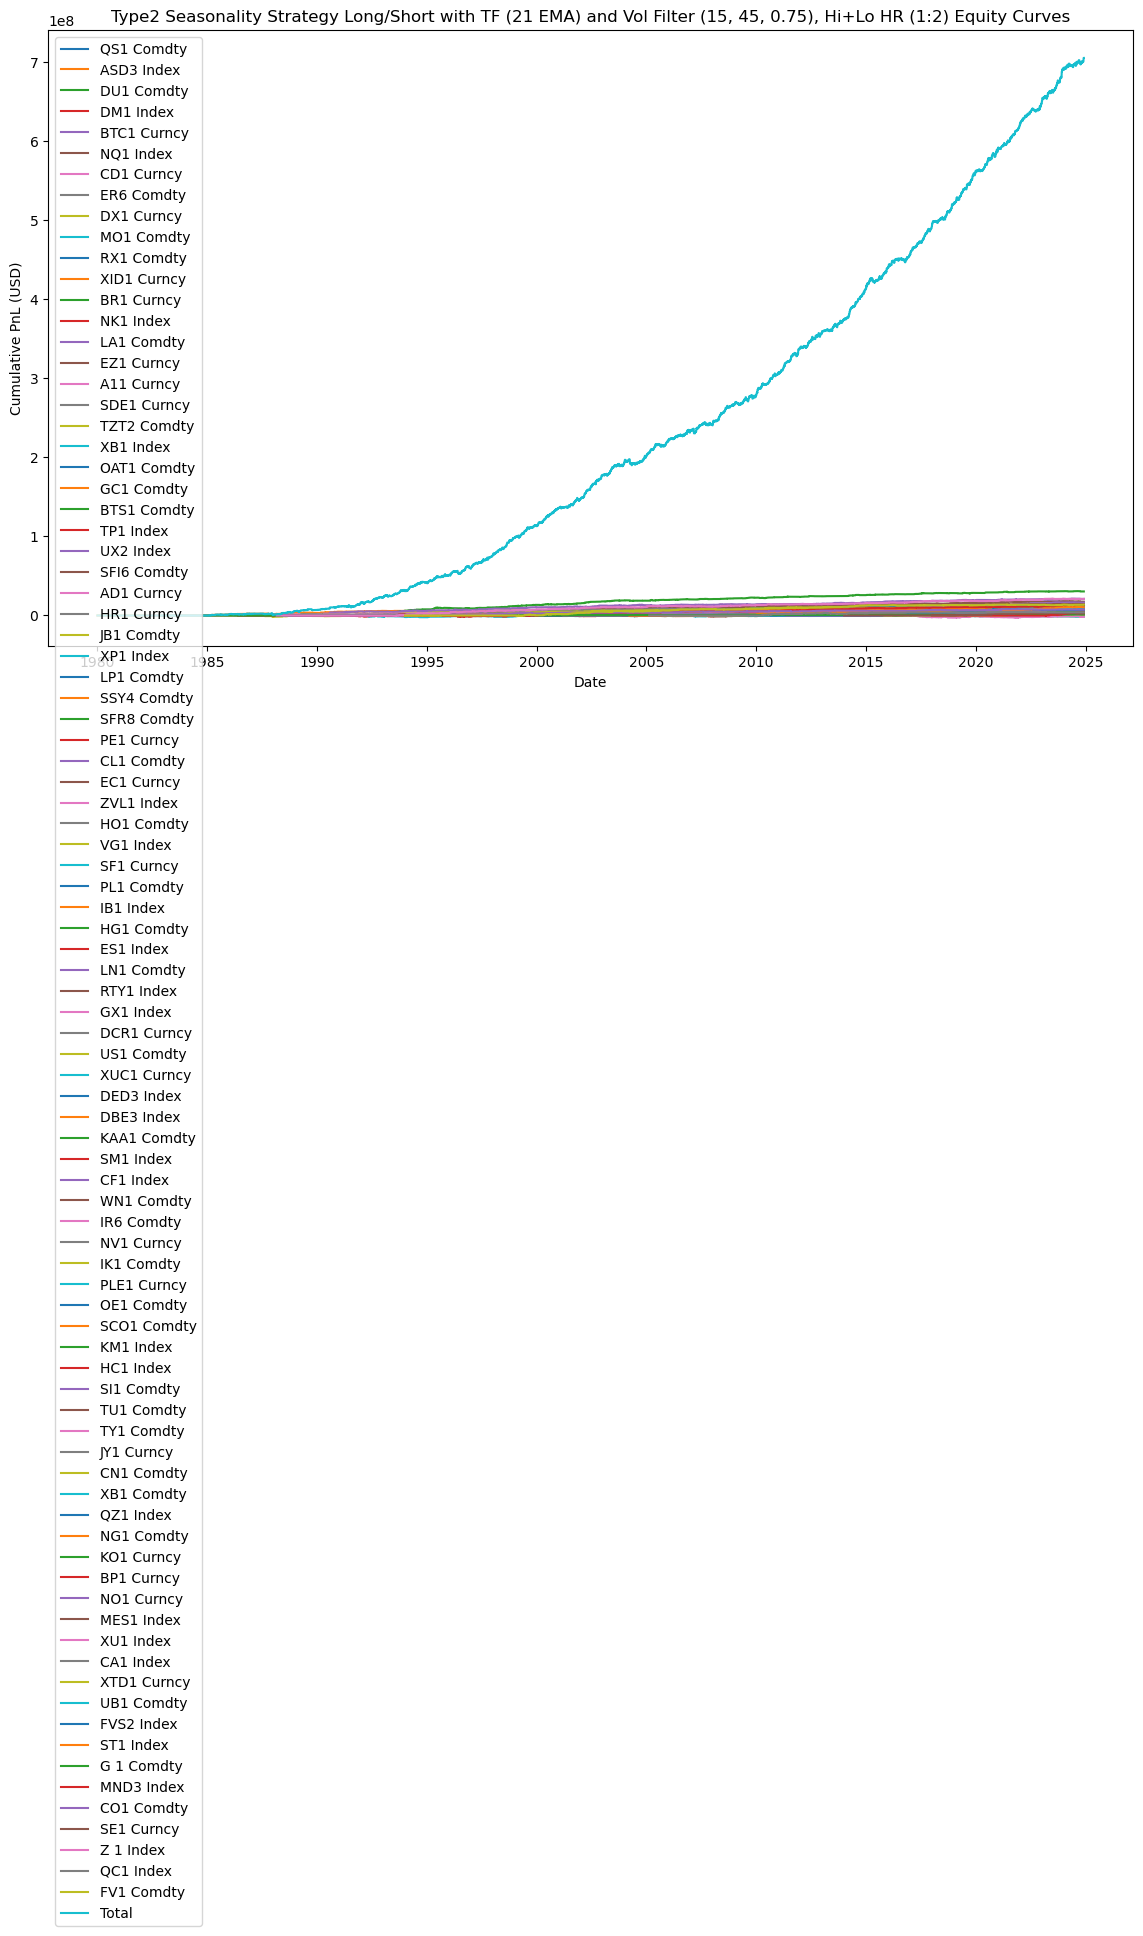

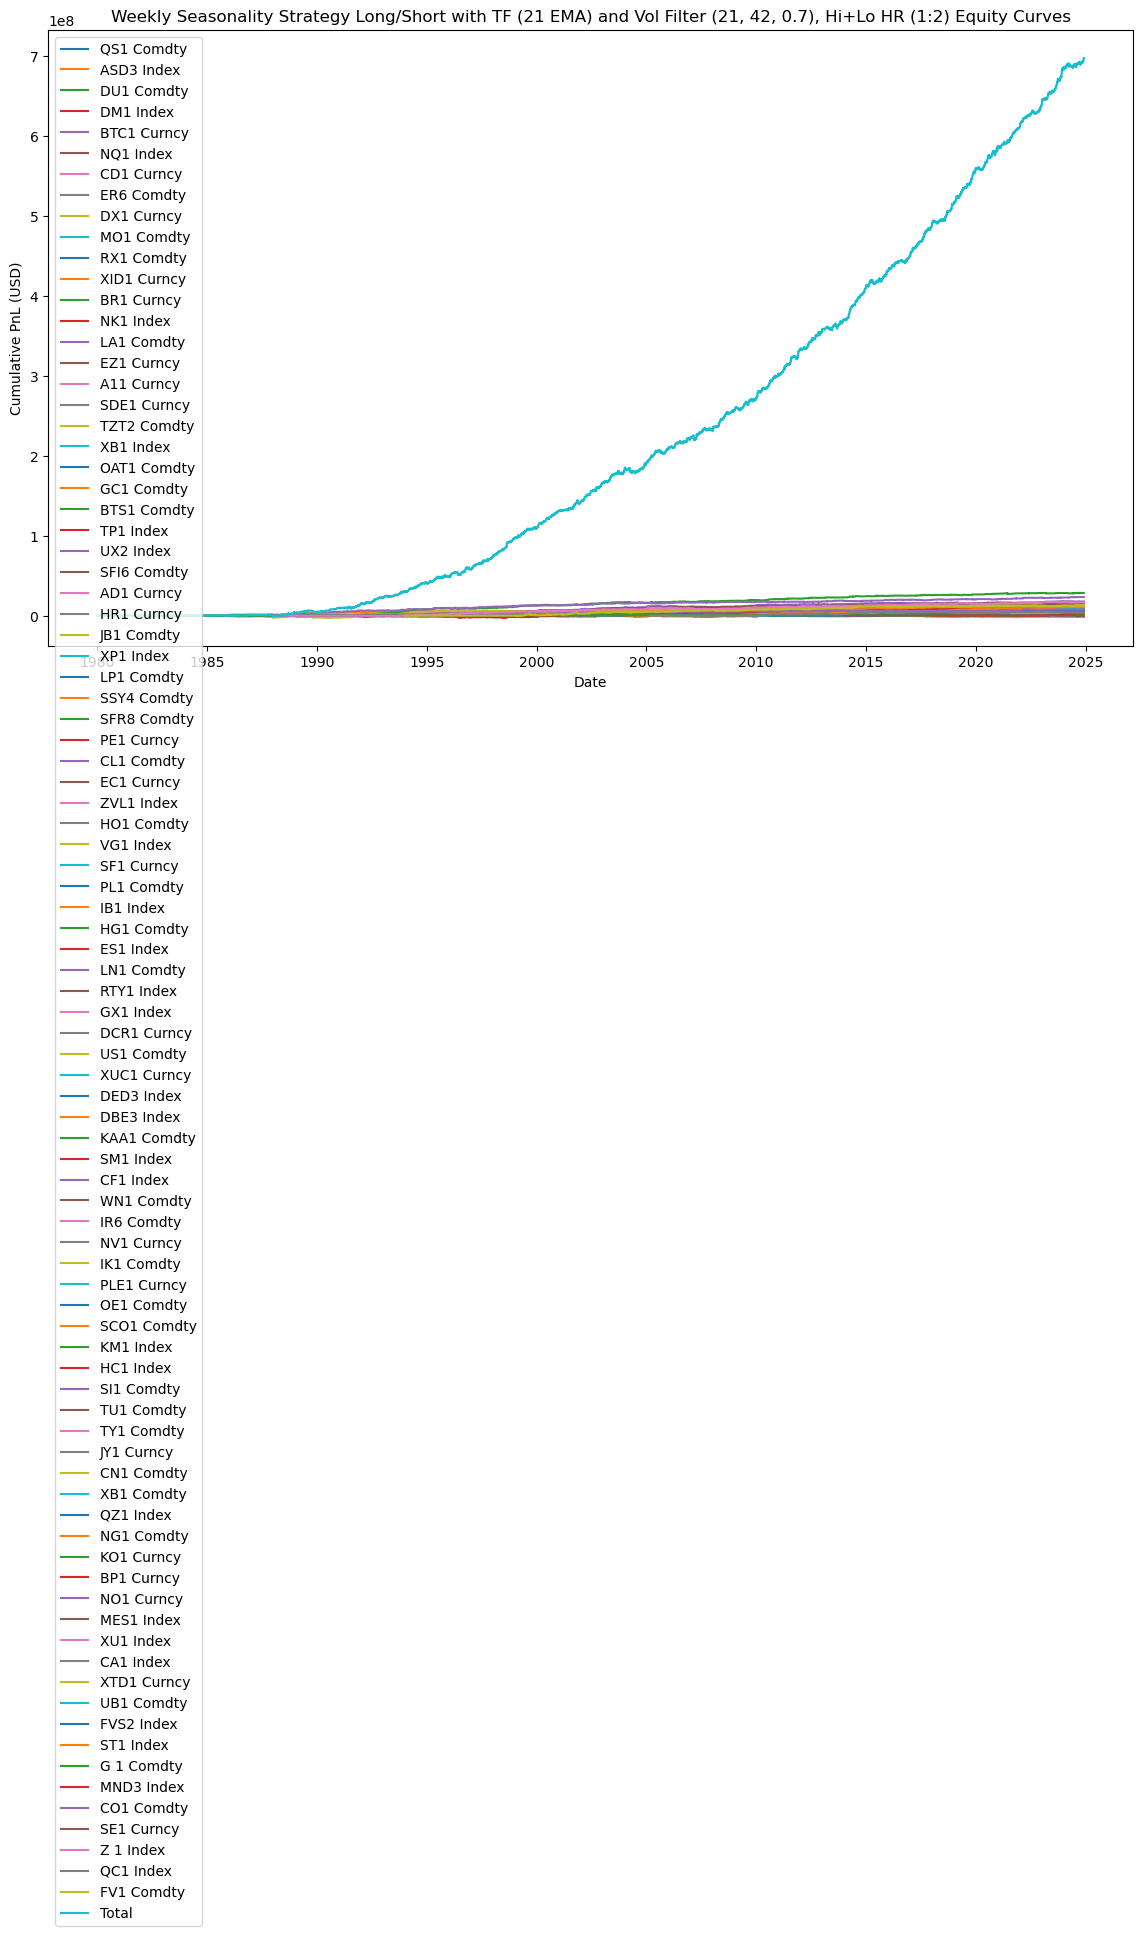

In [126]:

filter_list = []
start = ''
end = ''
#start = ''
#filter_list = ['PL1 Comdty', 'IK1 Comdty', 'MO1 Comdty']

pscaled = wklySeasn_b_rescale.plot_equity(byassets=True,totalsys=True, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])

punscaled = wklySeasn_b.plot_equity(byassets=True,totalsys=True, filter_assets=filter_list, start_date=start, end_date=end, excl_ac=['comm-soft'])

<Axes: xlabel='Date'>

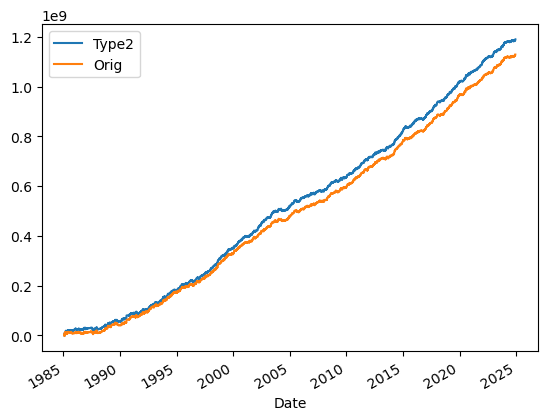

In [127]:
# Extract the 'Total' columns from both dataframes
total_pscaled = pscaled['Total']
total_punscaled = punscaled['Total']

# Create a new dataframe with the extracted 'Total' columns
combined_total_df = pd.DataFrame({
    'Type2': total_pscaled,
    'Orig': total_punscaled
})

vol_tgt = 10000000

# Calculate the rolling standard deviation of the last 125 days of returns
rolling_std = combined_total_df.diff().rolling(window=125).std()

# Calculate the scaling factor to achieve the target annualized volatility
scaling_factor = vol_tgt / (rolling_std * (252 ** 0.5))

# Apply the scaling factor to the returns
scaled_combined_total_df = combined_total_df.diff() * scaling_factor
scaled_combined_total_df = scaled_combined_total_df.cumsum()

scaled_combined_total_df.plot()

In [128]:
# Calculate daily returns (diffs)
daily_returns = combined_total_df.diff()

# Define the date range for 5 years and 10 years ago
five_years_ago = daily_returns.index[-1] - pd.DateOffset(years=2)
ten_years_ago = daily_returns.index[-1] - pd.DateOffset(years=6)

# Filter the daily returns for the specified date ranges
last_5_years = daily_returns.loc[daily_returns.index >= five_years_ago]
last_10_years = daily_returns.loc[daily_returns.index >= ten_years_ago]

# Calculate the mean and standard deviation of daily returns for the last 5 years and 10 years
mean_returns_5y = last_5_years.mean()
std_returns_5y = last_5_years.std()
mean_returns_10y = last_10_years.mean()
std_returns_10y = last_10_years.std()

# Calculate the annualized Sharpe ratio
annualized_sharpe_5y = mean_returns_5y / std_returns_5y * np.sqrt(252)
annualized_sharpe_10y = mean_returns_10y / std_returns_10y * np.sqrt(252)

print("Last 2 Years Annualized Sharpe Ratios:")
print(annualized_sharpe_5y)
print("\nLast 6 Years Annualized Sharpe Ratios:")
print(annualized_sharpe_10y)

Last 2 Years Annualized Sharpe Ratios:
Type2   2.97
Orig    3.00
dtype: float64

Last 6 Years Annualized Sharpe Ratios:
Type2   3.40
Orig    3.27
dtype: float64


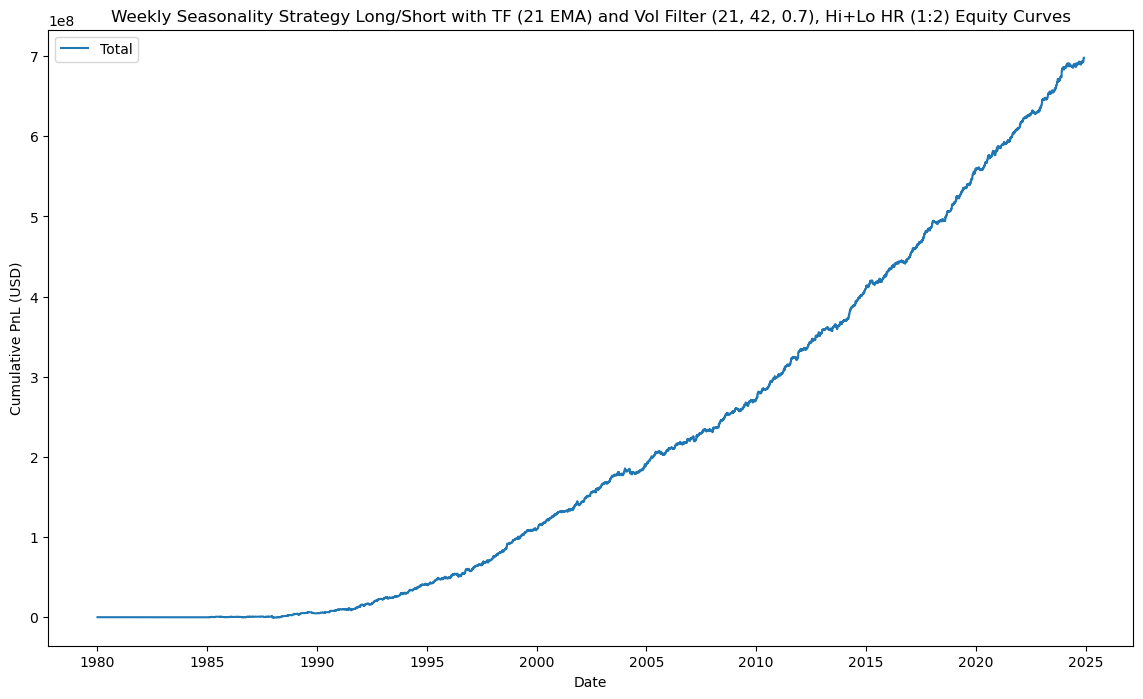

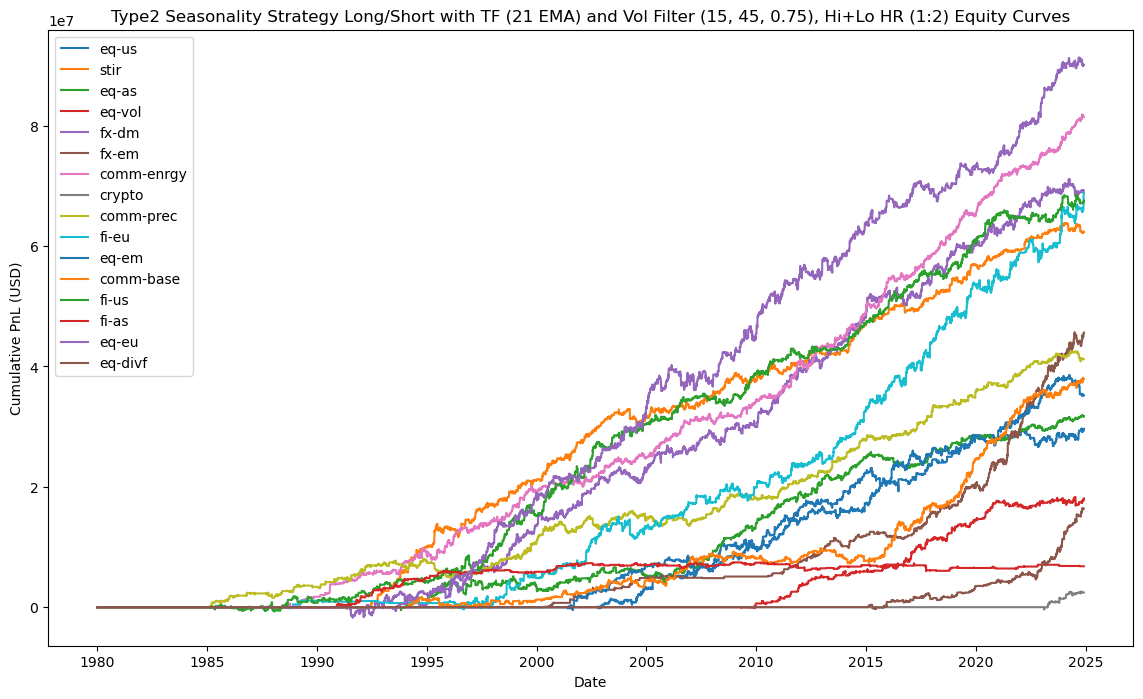

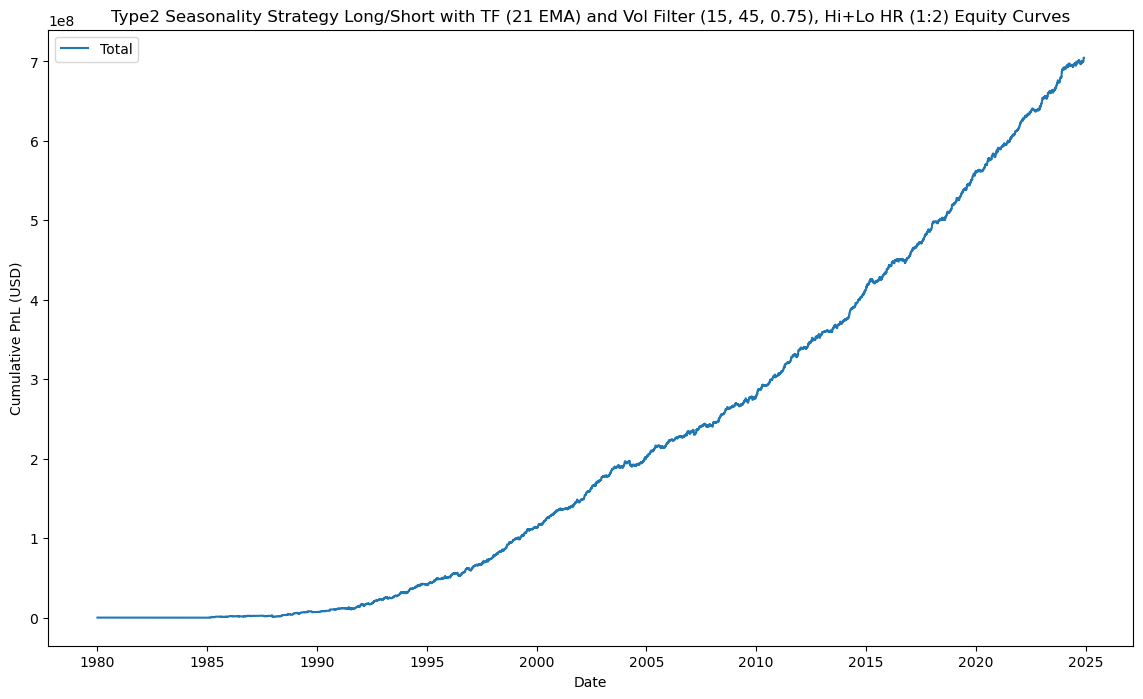

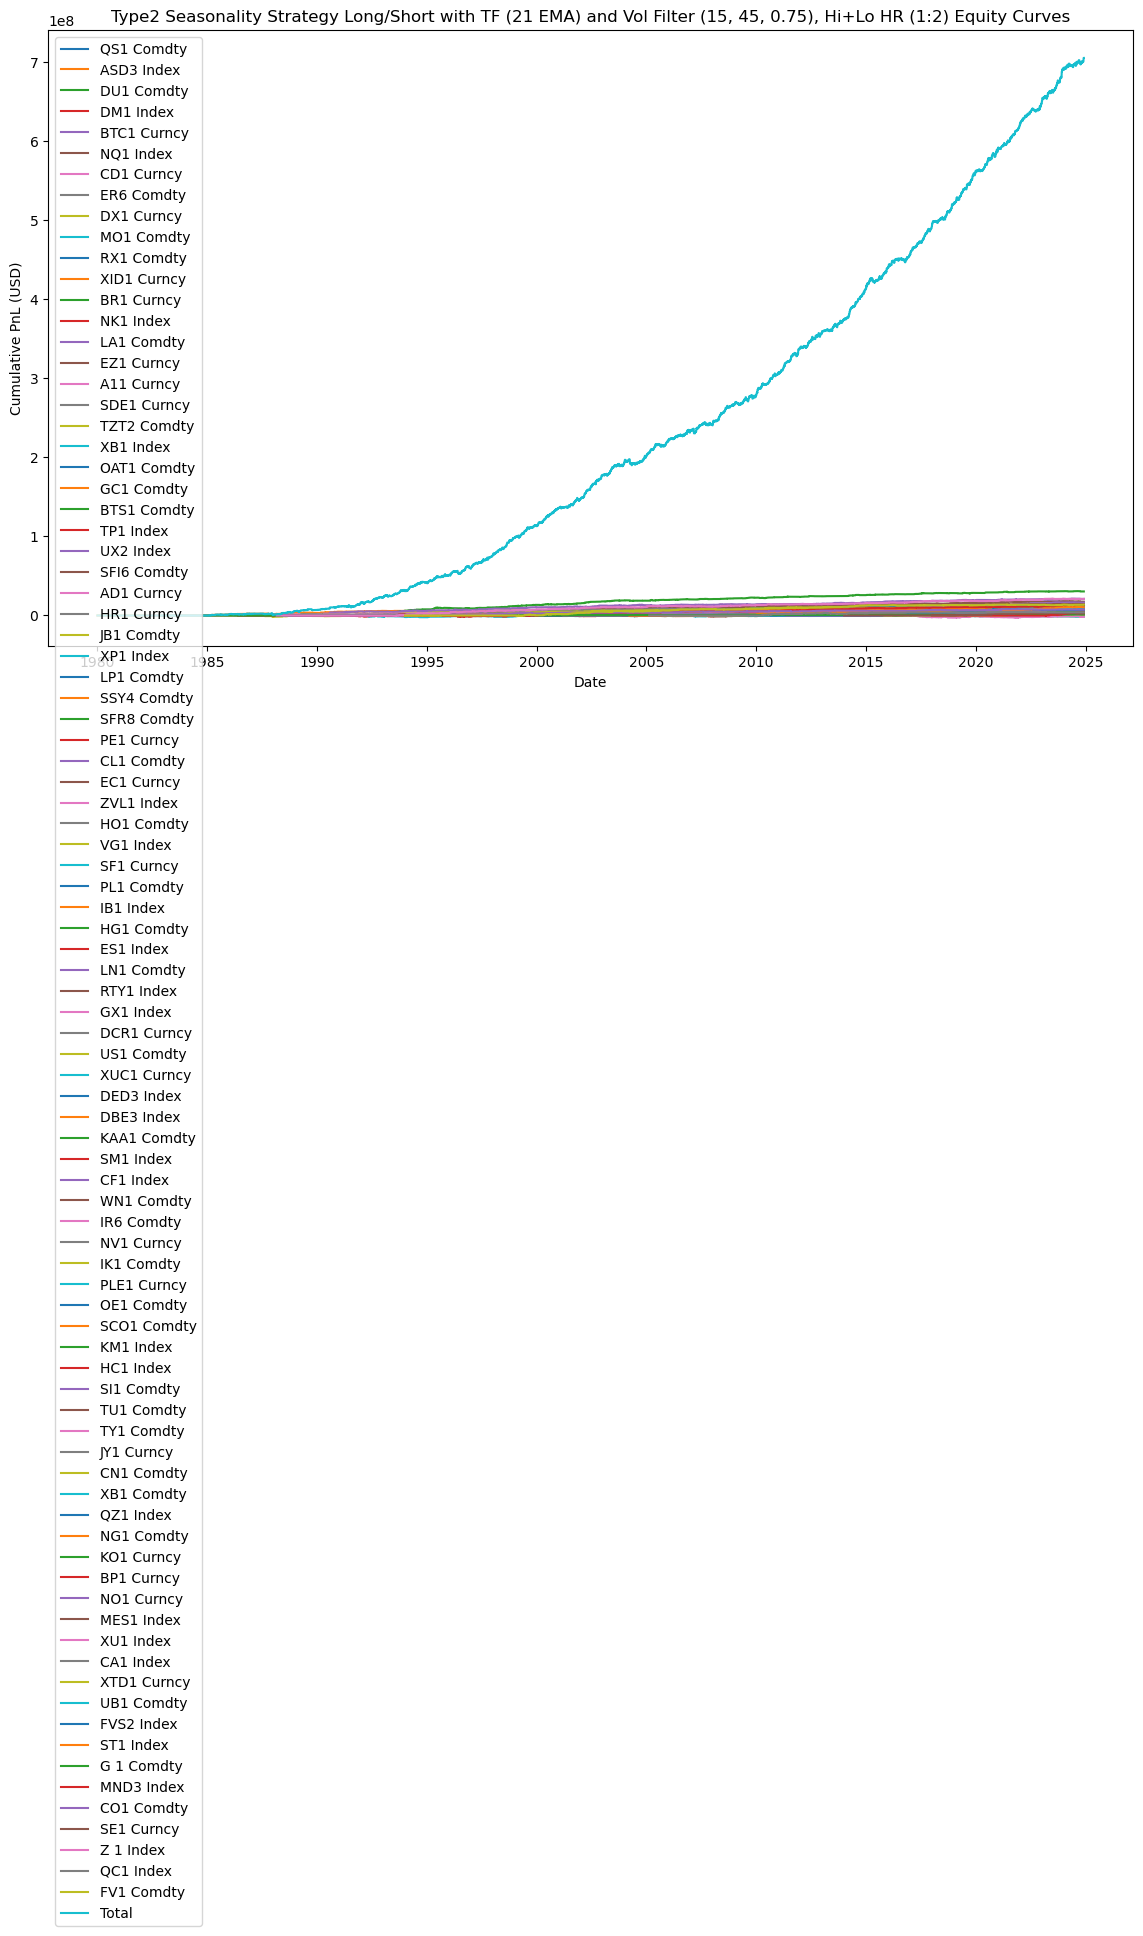

In [129]:
filters = []
start = ''
end = ''

pnl_final = wklySeasn_b.plot_equity(byac=False,totalsys=True, filter_assets=filters, start_date=start, end_date=end)
pnl_filt = wklySeasn_b_rescale.plot_equity(byac=True,totalsys=False, filter_assets=filters, start_date=start, end_date=end)
pnl_full = wklySeasn_b_rescale.plot_equity(byac=False,totalsys=True, filter_assets=filters, start_date=start, end_date=end)
pnl_bya = wklySeasn_b_rescale.plot_equity(byassets=True,totalsys=True, filter_assets=filters, start_date=start, end_date=end)

In [130]:
import plotly.graph_objects as go

# Extract the years from the index
years = pnl_full.index.year.unique()

# Initialize a dictionary to hold the normalized PnL data
normalized_pnl = {}

years = years[-10:]

# Normalize each year's PnL to start from 0
for year in years:
    yearly_pnl = pnl_full[pnl_full.index.year == year]['Total']
    normalized_pnl[year] = yearly_pnl - yearly_pnl.iloc[0]

# Create a Plotly figure
fig = go.Figure()

# Add traces for each year
for year, pnl in normalized_pnl.items():
    fig.add_trace(go.Scatter(
        x=pnl.index.dayofyear,
        y=pnl,
        mode='lines',
        name=str(year)
    ))

# Add year labels to the last x, y value of each year's PnL
for year, pnl in normalized_pnl.items():
    fig.add_trace(go.Scatter(
        x=[pnl.index.dayofyear[-1]],
        y=[pnl.iloc[-1]],
        mode='text',
        text=[str(year)],
        textposition='top right',
        showlegend=False
    ))

# Update layout
fig.update_layout(
    title='Type2 PnL Performance by Year',
    xaxis_title='Day of the Year',
    yaxis_title='PnL',
    showlegend=True
)

# Show the figure
fig.show()


In [131]:
import plotly.graph_objects as go

# Extract the years from the index
years = pnl_final.index.year.unique()

# Initialize a dictionary to hold the normalized PnL data
normalized_pnl = {}

years = years[-10:]

# Normalize each year's PnL to start from 0
for year in years:
    yearly_pnl = pnl_final[pnl_final.index.year == year]['Total']
    normalized_pnl[year] = yearly_pnl - yearly_pnl.iloc[0]

# Create a Plotly figure
fig = go.Figure()

# Add traces for each year
for year, pnl in normalized_pnl.items():
    fig.add_trace(go.Scatter(
        x=pnl.index.dayofyear,
        y=pnl,
        mode='lines',
        name=str(year)
    ))

# Add year labels to the last x, y value of each year's PnL
for year, pnl in normalized_pnl.items():
    fig.add_trace(go.Scatter(
        x=[pnl.index.dayofyear[-1]],
        y=[pnl.iloc[-1]],
        mode='text',
        text=[str(year)],
        textposition='top right',
        showlegend=False
    ))

# Update layout
fig.update_layout(
    title='Old PnL Performance by Year',
    xaxis_title='Day of the Year',
    yaxis_title='PnL',
    showlegend=True
)

# Show the figure
fig.show()


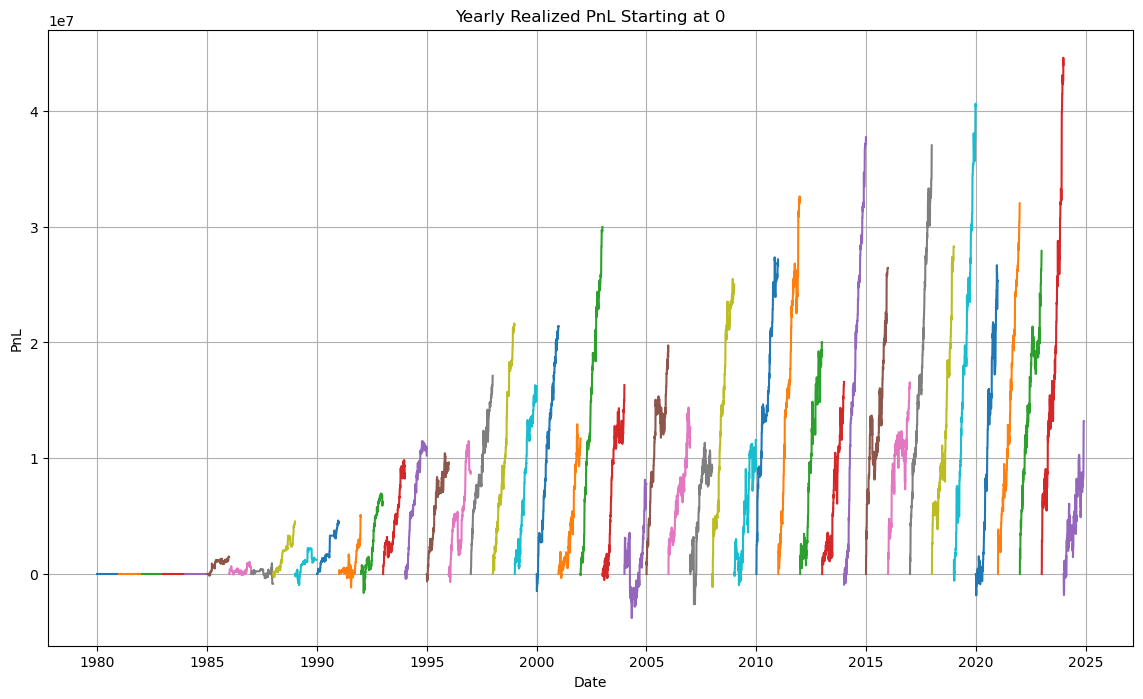

In [132]:

# Extract the years from the index
years = pnl_full.index.year.unique()

# Initialize a dictionary to hold the normalized PnL data
normalized_pnl = {}

# Normalize each year's PnL to start from 0
for year in years:
    yearly_pnl = pnl_full[pnl_full.index.year == year]['Total']
    normalized_pnl[year] = yearly_pnl - yearly_pnl.iloc[0]

# Plot the normalized PnL for each year on the same chart
plt.figure(figsize=(14, 8))
for year, pnl in normalized_pnl.items():
    plt.plot(pnl.index, pnl, label=str(year))

plt.title('Yearly Realized PnL Starting at 0')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

In [133]:
type2_mthly = wklySeasn_b_rescale.strat_monthly_pnl(filter_assets=[])
type2_mthly = type2_mthly.dropna(subset=['Sharpe_Ratio'])
type2_mthly

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:53: RuntimeWarning:

invalid value encountered in reduce



1          2          3          4          5          6  \
Year                                                                    
1985   152,962    974,315  1,826,827  2,008,635  2,082,797 -1,068,706   
1986   287,233  2,109,921    -46,071 -2,340,726    934,663    466,506   
1987   136,091  1,613,515   -510,350 -1,788,353   -399,447  1,590,697   
1988   233,021    926,481    936,193  1,136,427  1,623,500    493,406   
1989   777,952 -1,260,055  1,147,537    390,643    454,855    145,715   
1990   360,459  1,101,610  1,341,929    601,102    631,072    609,971   
1991  -771,174    201,417 -1,928,429    194,018    135,259    445,607   
1992 1,202,367 -1,486,720  1,715,944    502,328   -402,312  1,293,341   
1993 2,128,422    781,890 -1,622,791    503,442    303,725  1,670,817   
1994   919,919  1,899,633  4,270,496    438,355    923,631  1,189,510   
1995 1,052,913  1,368,292  1,281,685  2,033,227  2,905,423  1,152,034   
1996   -96,021  3,030,991    750,177  2,794,415 -1,757,717    328,909   
1997 4,279,896  1,239,021  2,199,821   -567,895  2,469,425   -504,890   
1998 2,410,555  1,777,345  3,072,668  2,427,610  1,707,847   -320,589   
1999 2,650,416  1,696,124   -161,181  3,342,645    414,330  3,432,835   
2000 2,321,810  2,340,651    741,327  3,606,347  1,923,632  4,621,369   
2001 2,657,242 -1,130,709  1,208,325    609,390    418,910  1,819,573   
2002 2,474,935  1,302,318  4,009,549  3,735,212    768,912  4,358,134   
2003   466,052  1,579,782   -879,019  2,895,876  6,562,710  2,817,515   
2004 1,253,658  2,753,107  1,124,115 -7,117,621  3,923,503   -950,774   
2005 3,190,192  3,073,388  3,028,506  2,823,364  2,897,070  3,551,531   
2006 3,322,259    -20,653    394,866  3,162,563  1,585,493  2,481,163   
2007 1,480,598 -2,968,187    652,891  5,334,140  3,019,344  1,427,285   
2008 3,155,083  2,215,148  1,164,284  4,887,432  5,754,744   -707,267   
2009 4,248,319   -736,901 -2,505,623  3,022,157  2,622,968  4,155,730   
2010 8,671,771  1,956,481  1,983,591  3,211,955   -784,264    845,962   
2011 1,279,359  3,617,669  3,299,842  6,195,550  1,773,079   -359,056   
2012   774,769    642,151  1,518,795  1,467,943  8,224,693 -1,183,895   
2013 1,758,378    692,761  2,561,381 -2,649,508    475,805  4,493,864   
2014   541,915  1,240,263  4,922,521  8,540,292  2,150,529    529,303   
2015 7,656,901  3,340,041  3,613,272 -2,880,617    166,573  1,010,735   
2016 4,196,481   -382,416  4,796,726  2,519,370  1,726,489  1,226,885   
2017 6,334,446  3,873,178  2,278,106  2,681,364  3,553,528    343,915   
2018 5,905,984  1,571,896 -2,432,329  4,208,012  3,546,738    986,862   
2019 2,907,661  5,697,744 -2,300,377  6,721,309  6,546,174  2,060,062   
2020 2,025,512  1,176,710   -649,742    910,125  3,628,698  3,933,530   
2021 2,908,912  1,853,085  2,959,796  1,150,506  1,041,844  2,389,632   
2022 4,992,297  2,747,793  3,779,417  1,205,203  3,567,379  3,683,361   
2023 6,853,089  3,215,554    197,860  5,559,987    608,999  3,517,185   
2024   158,853  3,878,692  3,666,308 -1,461,978 -1,505,184  2,800,918   

              7          8          9         10         11         12  \
Year                                                                     
1985      1,988   -595,531    -61,339  2,563,683   -701,326  1,259,148   
1986    320,108    823,209    422,956    990,477   -569,910  1,076,642   
1987 -1,044,095  1,059,357    196,135    355,295  1,675,810   -571,826   
1988      1,878    880,010  1,357,351    471,862  1,140,294  1,301,740   
1989  1,956,116   -246,807    563,114 -1,870,920    516,441    186,290   
1990  1,597,760    370,906    471,144    882,337  1,153,541   -400,861   
1991   -332,621    518,549    486,430  2,923,212    298,334  2,371,711   
1992  4,241,811  2,651,114  1,254,830  1,607,578    313,426   -771,166   
1993  1,911,154    291,176  2,062,517  2,792,093  1,204,974   -400,636   
1994  1,000,374  1,060,449  2,935,371  1,401,766    572,176   -756,194   
1995  1,629,136   -262,814   -462,396  2,632,001 -1,394,81

In [134]:
final_monthly

1          2          3          4          5          6  \
Year                                                                    
1985    47,525    993,590  1,609,628  1,888,610  1,959,297 -1,414,168   
1986   203,170  1,856,886    -46,071 -2,637,163  1,382,510    466,506   
1987   -68,673  1,062,426   -612,367 -1,789,423   -124,124  1,447,338   
1988    12,281    536,536    771,662  1,204,900  2,228,370    -66,188   
1989   837,794 -1,274,794    951,724    302,133    747,648    256,353   
1990   597,382    856,328    782,592    588,617  1,459,749  1,598,836   
1991   194,096   -108,653 -1,066,836    328,219    141,814    522,268   
1992   570,380   -801,558  1,657,225    372,043    -73,084  1,493,736   
1993 1,773,883    401,889   -713,724  1,223,133    284,608  1,451,642   
1994   -98,341  2,140,150  3,595,990   -180,037  1,311,236  1,177,968   
1995    25,091  1,695,485    949,775  2,547,423  2,914,884  1,779,174   
1996   489,500  3,025,892    276,276  2,244,903 -1,632,863    509,944   
1997 3,791,234  1,415,214  1,955,124    114,672  2,345,629   -936,334   
1998 2,322,580  1,673,700  2,795,948  2,591,076  2,696,077   -389,456   
1999 1,473,369  2,806,842   -154,522  3,557,851    227,322  4,032,855   
2000 3,779,223  3,757,844    -40,237  2,325,633  2,265,709  3,702,584   
2001 2,204,505   -678,811    985,926    642,229    794,477  1,279,985   
2002 3,424,991  1,062,115  3,416,099  1,806,859  1,122,283  5,362,703   
2003 1,792,433  1,353,316   -585,427  2,363,891  6,543,317  1,905,520   
2004  -299,879  2,678,491  1,059,835 -6,376,584  3,529,145    372,939   
2005 2,382,264  3,749,357  3,672,138  2,932,940  3,643,106  3,362,562   
2006 3,549,463   -388,261    380,633  4,781,247  1,855,066  2,379,145   
2007 2,677,685 -3,082,085    688,405  6,565,309  2,557,605    379,968   
2008 3,117,836  1,314,220    296,989  5,289,459  5,617,800    251,957   
2009 4,996,417    180,970 -2,818,712  3,008,772  2,965,269  4,340,738   
2010 9,351,888    771,282  1,752,371  3,062,742   -269,669    779,328   
2011   682,406  3,290,608  3,693,662  5,047,714  2,574,380   -725,498   
2012   455,767  1,007,097  1,892,394  2,185,227  7,096,036   -639,505   
2013 2,302,370  1,330,156  3,101,759 -2,551,722   -661,113  4,105,059   
2014  -268,991  1,804,435  5,953,875  8,475,341  2,808,011  1,372,583   
2015 3,265,050  3,506,363  4,262,871 -2,728,325  1,388,021     -5,213   
2016 3,820,920   -256,508  4,164,449  2,622,734  2,252,465  3,072,138   
2017 6,452,976  3,899,344  1,614,594  2,928,600  4,786,941  1,526,893   
2018 5,381,919   -651,495 -2,472,603  3,214,505  3,597,181    966,198   
2019 4,447,412  5,754,447 -2,154,060  6,368,028  6,471,266  1,007,996   
2020 1,739,906   -305,208   -737,718  1,260,622  4,181,495  4,371,934   
2021   906,873  2,829,760  2,651,625    545,402    660,104    932,086   
2022 6,094,901  2,103,384  3,591,406    739,963  3,122,263  2,322,095   
2023 6,497,643  2,691,158  1,092,544  6,258,946    541,537  3,463,234   
2024   340,434  3,938,500  1,735,986 -2,334,656 -2,115,973  3,555,456   

              7          8          9         10         11         12  \
Year                                                                     
1985  1,606,195     31,712   -196,664  2,689,665   -780,624    980,653   
1986    370,362    238,477    517,656    638,590   -464,769  1,495,837   
1987   -864,425    717,501    498,854  1,114,980    976,950     40,010   
1988    -89,576  1,122,200  1,357,351  1,517,790  1,143,275  1,140,709   
1989  1,117,404   -671,103    735,014 -1,985,056    -38,013    268,052   
1990  2,369,979   -142,028    171,041  1,178,207  1,536,720   -567,863   
1991   -778,522    410,707    537,304  2,644,824    703,624  2,001,820   
1992  4,764,871  3,315,012    771,109  2,747,040    -49,429   -605,906   
1993  1,445,786   -377,641  1,751,191  3,635,976    971,475    549,832   
1994  1,328,812  1,796,398  2,907,767  1,785,712   -109,737   -678,887   
1995  1,686,720   -137,712   -187,579  2,625,353   -690,10

In [135]:
type2_mthly - final_monthly

1          2          3          4          5          6  \
Year                                                                     
1985    105,438    -19,275    217,199    120,025    123,500    345,462   
1986     84,062    253,035       0.00    296,437   -447,847       0.00   
1987    204,763    551,089    102,017      1,069   -275,323    143,360   
1988    220,740    389,946    164,531    -68,472   -604,870    559,593   
1989    -59,843     14,738    195,812     88,511   -292,792   -110,638   
1990   -236,923    245,281    559,338     12,485   -828,677   -988,866   
1991   -965,270    310,071   -861,592   -134,201     -6,555    -76,661   
1992    631,986   -685,163     58,719    130,286   -329,228   -200,395   
1993    354,539    380,001   -909,067   -719,691     19,117    219,175   
1994  1,018,260   -240,517    674,506    618,392   -387,605     11,543   
1995  1,027,822   -327,193    331,910   -514,197     -9,461   -627,139   
1996   -585,522      5,099    473,901    549,512   -124,854   -181,035   
1997    488,662   -176,193    244,697   -682,566    123,796    431,445   
1998     87,975    103,645    276,720   -163,467   -988,230     68,867   
1999  1,177,046 -1,110,718     -6,659   -215,206    187,007   -600,020   
2000 -1,457,413 -1,417,192    781,564  1,280,714   -342,077    918,785   
2001    452,737   -451,897    222,399    -32,840   -375,568    539,588   
2002   -950,056    240,203    593,450  1,928,353   -353,370 -1,004,569   
2003 -1,326,381    226,466   -293,592    531,985     19,393    911,995   
2004  1,553,537     74,616     64,280   -741,037    394,358 -1,323,713   
2005    807,927   -675,969   -643,632   -109,576   -746,036    188,969   
2006   -227,204    367,607     14,234 -1,618,684   -269,573    102,018   
2007 -1,197,087    113,898    -35,513 -1,231,170    461,739  1,047,316   
2008     37,246    900,928    867,295   -402,027    136,944   -959,224   
2009   -748,098   -917,871    313,089     13,385   -342,301   -185,007   
2010   -680,118  1,185,199    231,220    149,214   -514,594     66,634   
2011    596,954    327,061   -393,820  1,147,836   -801,301    366,442   
2012    319,003   -364,946   -373,598   -717,284  1,128,657   -544,391   
2013   -543,992   -637,396   -540,378    -97,786  1,136,918    388,805   
2014    810,906   -564,172 -1,031,354     64,951   -657,483   -843,280   
2015  4,391,851   -166,322   -649,599   -152,292 -1,221,449  1,015,949   
2016    375,560   -125,908    632,277   -103,364   -525,976 -1,845,252   
2017   -118,530    -26,166    663,511   -247,236 -1,233,413 -1,182,978   
2018    524,066  2,223,391     40,274    993,507    -50,443     20,664   
2019 -1,539,751    -56,702   -146,318    353,281     74,908  1,052,066   
2020    285,606  1,481,918     87,975   -350,497   -552,797   -438,404   
2021  2,002,039   -976,675    308,170    605,104    381,739  1,457,546   
2022 -1,102,605    644,409    188,011    465,240    445,116  1,361,266   
2023    355,446    524,396   -894,684   -698,959     67,462     53,951   
2024   -181,581    -59,808  1,930,321    872,678    610,789   -754,539   

              7          8          9         10         11        12  \
Year                                                                    
1985 -1,604,207   -627,244    135,325   -125,981     79,298   278,495   
1986    -50,254    584,732    -94,700    351,888   -105,141  -419,195   
1987   -179,669    341,856   -302,718   -759,685    698,860  -611,836   
1988     91,454   -242,190       0.00 -1,045,928     -2,981   161,031   
1989    838,712    424,297   -171,900    114,136    554,454   -81,762   
1990   -772,218    512,933    300,103   -295,870   -383,179   167,002   
1991    445,901    107,842    -50,874    278,388   -405,290   369,891   
1992   -523,060   -663,898    483,721 -1,139,462    362,855  -165,260   
1993    465,368    668,817    311,326   -843,883    233,499  -950,468   
1994   -328,438   -735,950     27,604   -383,946    681,913   -77,307   
1995    -57,583   -125,103   

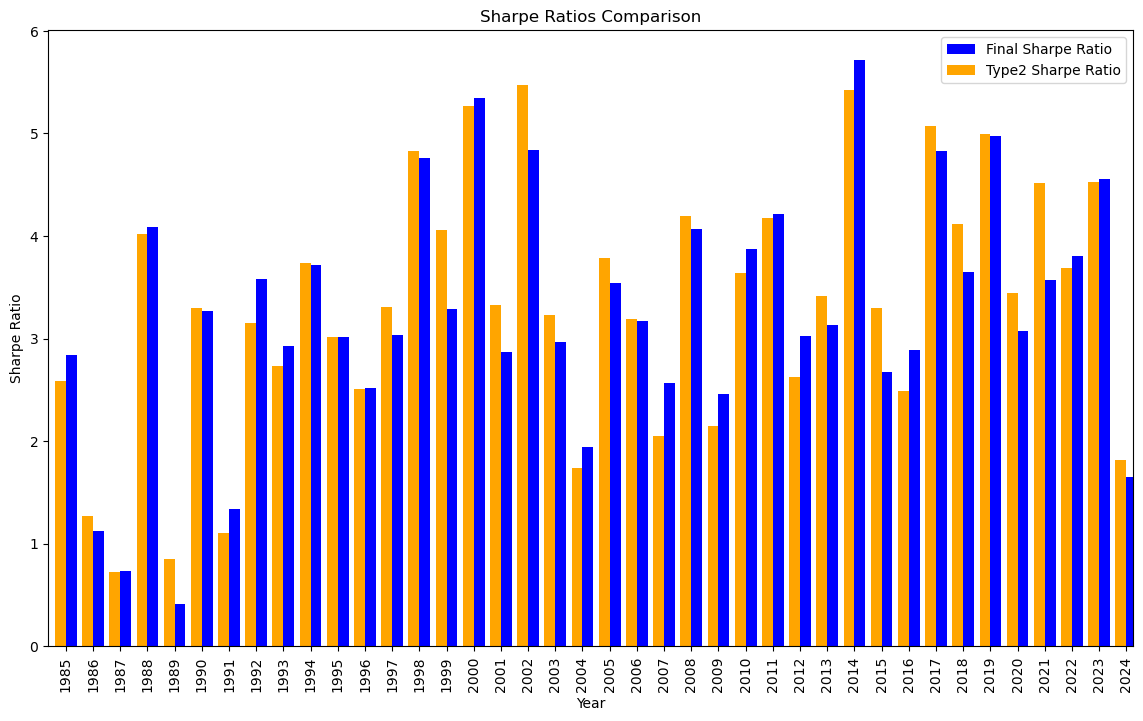

In [136]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the Sharpe Ratios for final_monthly
final_monthly['Sharpe_Ratio'].plot(kind='bar', ax=ax, position=0, width=0.4, label='Final Sharpe Ratio', color='blue')

# Plot the Sharpe Ratios for type2_mthly
type2_mthly['Sharpe_Ratio'].plot(kind='bar', ax=ax, position=1, width=0.4, label='Type2 Sharpe Ratio', color='orange')

# Set the title and labels
ax.set_title('Sharpe Ratios Comparison')
ax.set_xlabel('Year')
ax.set_ylabel('Sharpe Ratio')

# Add a legend
ax.legend()

# Show the plot
plt.show()

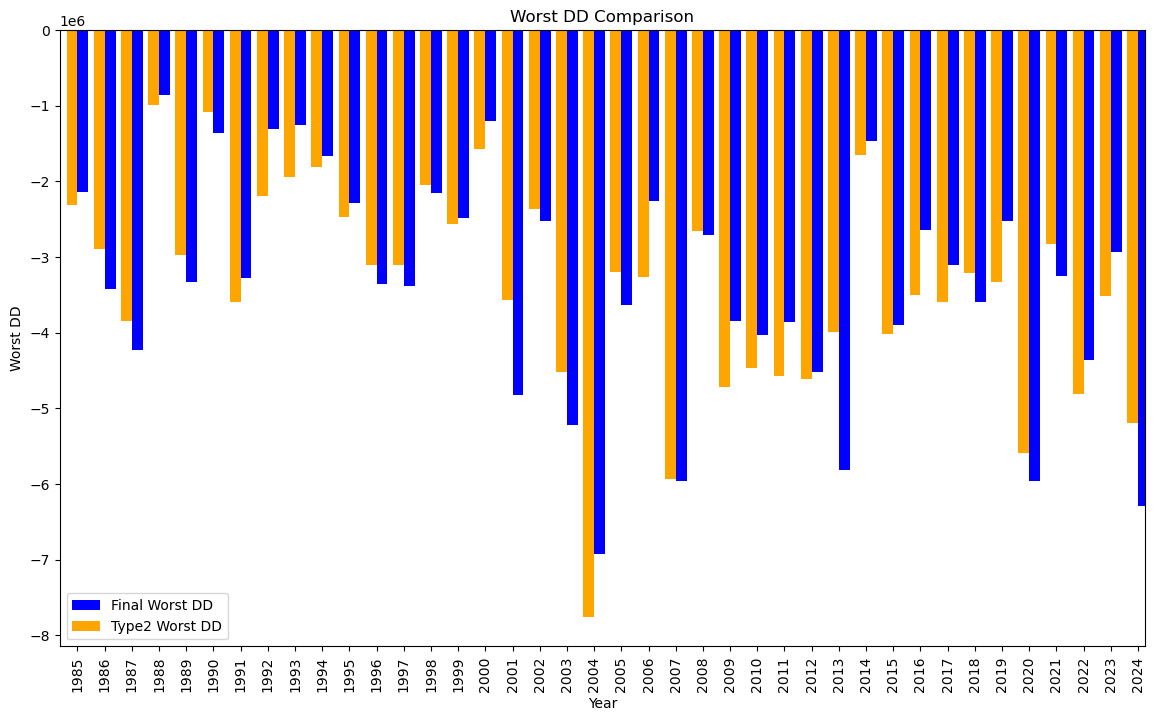

In [137]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the Sharpe Ratios for final_monthly
final_monthly['Worst_Drawdown'].plot(kind='bar', ax=ax, position=0, width=0.4, label='Final Worst DD', color='blue')

# Plot the Sharpe Ratios for type2_mthly
type2_mthly['Worst_Drawdown'].plot(kind='bar', ax=ax, position=1, width=0.4, label='Type2 Worst DD', color='orange')

# Set the title and labels
ax.set_title('Worst DD Comparison')
ax.set_xlabel('Year')
ax.set_ylabel('Worst DD')

# Add a legend
ax.legend()

# Show the plot
plt.show()

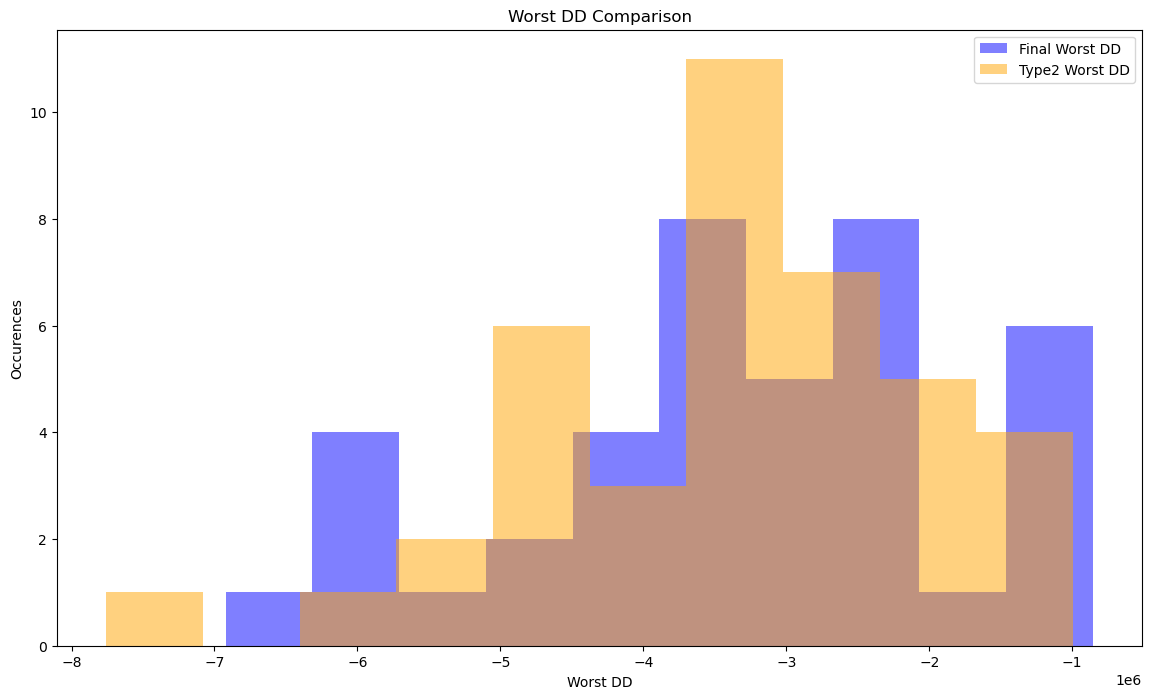

In [138]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))
# Plot the Worst Drawdown for final_monthly as a histogram
final_monthly['Worst_Drawdown'].plot(kind='hist', ax=ax, alpha=0.5, label='Final Worst DD', color='blue')

# Plot the Worst Drawdown for type2_mthly as a histogram
type2_mthly['Worst_Drawdown'].plot(kind='hist', ax=ax, alpha=0.5, label='Type2 Worst DD', color='orange')

# Set the title and labels
ax.set_title('Worst DD Comparison')
ax.set_xlabel('Worst DD')
ax.set_ylabel('Occurences')

# Add a legend
ax.legend()

# Show the plot
plt.show()

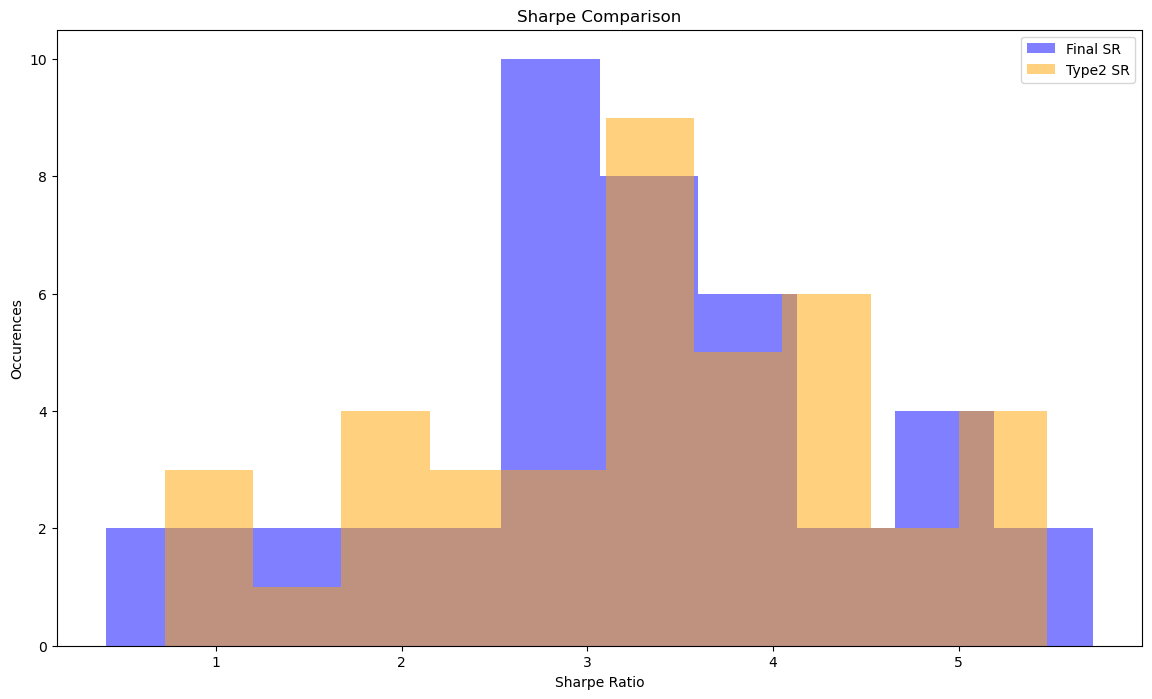

In [139]:

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))
# Plot the Worst Drawdown for final_monthly as a histogram
final_monthly['Sharpe_Ratio'].plot(kind='hist', ax=ax, alpha=0.5, label='Final SR', color='blue')

# Plot the Worst Drawdown for type2_mthly as a histogram
type2_mthly['Sharpe_Ratio'].plot(kind='hist', ax=ax, alpha=0.5, label='Type2 SR', color='orange')

# Set the title and labels
ax.set_title('Sharpe Comparison')
ax.set_xlabel('Sharpe Ratio')
ax.set_ylabel('Occurences')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [140]:

# Calculate daily returns (diffs)
daily_returns = pnl_bya.diff()

# Calculate the mean and standard deviation of daily returns for the last 8 years
# Calculate the date range for 8 years ago
eight_years_ago = daily_returns.index[-1] - pd.DateOffset(years=10)
eight_years_ago_end = eight_years_ago - pd.DateOffset(years=10)

# Filter the daily returns for the specified date range
last_8_years = daily_returns.loc[(daily_returns.index >= eight_years_ago_end) & (daily_returns.index < eight_years_ago)]
last_8_years = daily_returns.loc[(daily_returns.index >= eight_years_ago)]
mean_returns = last_8_years.mean()
std_returns = last_8_years.std()

# Calculate the annualized Sharpe ratio
annualized_sharpe = mean_returns / std_returns * np.sqrt(252)

annualized_sharpe = annualized_sharpe.sort_values(ascending=False)

for asset, sharpe in annualized_sharpe.items():
    print(f'{asset}: {sharpe:.2f}')

Total: 3.43
TZT2 Comdty: 1.36
PLE1 Curncy: 1.33
HG1 Comdty: 1.29
WN1 Comdty: 1.23
MO1 Comdty: 1.21
LA1 Comdty: 1.17
IK1 Comdty: 1.17
US1 Comdty: 1.17
DED3 Index: 1.16
A11 Curncy: 1.14
LN1 Comdty: 1.12
MND3 Index: 1.07
KO1 Curncy: 1.07
Z 1 Index: 1.01
ASD3 Index: 1.00
QS1 Comdty: 0.99
EC1 Curncy: 0.98
XB1 Index: 0.96
HR1 Curncy: 0.95
KM1 Index: 0.94
SI1 Comdty: 0.93
ER6 Comdty: 0.93
ST1 Index: 0.90
FVS2 Index: 0.89
XP1 Index: 0.88
MES1 Index: 0.87
LP1 Comdty: 0.86
SFR8 Comdty: 0.84
IR6 Comdty: 0.83
NV1 Curncy: 0.81
CF1 Index: 0.79
CL1 Comdty: 0.77
GC1 Comdty: 0.76
CA1 Index: 0.76
BTC1 Curncy: 0.75
PL1 Comdty: 0.75
OAT1 Comdty: 0.74
UB1 Comdty: 0.73
UX2 Index: 0.72
GX1 Index: 0.72
RX1 Comdty: 0.71
XID1 Curncy: 0.71
NG1 Comdty: 0.70
DX1 Curncy: 0.69
HO1 Comdty: 0.65
DU1 Comdty: 0.62
BTS1 Comdty: 0.61
DM1 Index: 0.57
ES1 Index: 0.55
SFI6 Comdty: 0.51
QZ1 Index: 0.50
BP1 Curncy: 0.50
IB1 Index: 0.49
QC1 Index: 0.47
XUC1 Curncy: 0.47
SCO1 Comdty: 0.47
VG1 Index: 0.41
BR1 Curncy: 0.39
CD1 Cur

In [141]:
import numpy as np

# Calculate daily returns (diffs)
daily_returns = pnl_filt.diff()

# Calculate the mean and standard deviation of daily returns for the last 8 years
# Calculate the date range for 8 years ago
eight_years_ago = daily_returns.index[-1] - pd.DateOffset(years=10)
eight_years_ago_end = eight_years_ago - pd.DateOffset(years=10)

# Filter the daily returns for the specified date range
last_8_years = daily_returns.loc[(daily_returns.index >= eight_years_ago_end) & (daily_returns.index < eight_years_ago)]
last_8_years = daily_returns.loc[(daily_returns.index >= eight_years_ago)]
mean_returns = last_8_years.mean()
std_returns = last_8_years.std()

# Calculate the annualized Sharpe ratio
annualized_sharpe = mean_returns / std_returns * np.sqrt(252)

annualized_sharpe_new_ac = annualized_sharpe.sort_values(ascending=False)

for asset, sharpe in annualized_sharpe_new_ac.items():
    print(f'{asset}: {sharpe:.2f}')

Total: 3.43
comm-enrgy: 2.15
comm-base: 1.88
fx-em: 1.80
eq-divf: 1.63
stir: 1.34
fi-eu: 1.30
eq-eu: 1.21
comm-prec: 1.19
fi-us: 1.15
eq-em: 1.10
eq-vol: 1.06
fx-dm: 0.94
eq-as: 0.66
crypto: 0.63
eq-us: 0.47
fi-as: -0.05


In [142]:
comp_acs = pd.DataFrame({
    'Type2': annualized_sharpe_new_ac,
    'Orig': annualized_sharpe_final_ac,
    'Diff': annualized_sharpe_new_ac - annualized_sharpe_final_ac
})

comp_acs = comp_acs.sort_values(by='Diff', ascending=False)

comp_acs


Type2  Orig  Diff
fx-dm        0.94  0.64  0.30
eq-eu        1.21  0.94  0.27
stir         1.34  1.09  0.25
eq-divf      1.63  1.39  0.23
comm-enrgy   2.15  1.94  0.21
Total        3.43  3.27  0.16
comm-prec    1.19  1.05  0.14
crypto       0.63  0.56  0.07
eq-vol       1.06  1.01  0.06
eq-em        1.10  1.04  0.06
fi-us        1.15  1.16 -0.01
eq-as        0.66  0.67 -0.01
fx-em        1.80  1.83 -0.03
fi-eu        1.30  1.35 -0.05
eq-us        0.47  0.63 -0.16
comm-base    1.88  2.07 -0.20
fi-as       -0.05  0.18 -0.23

In [143]:
asset_classes

{'crypto': ['BTC1 Curncy', 'DCR1 Curncy'],
 'eq-divf': ['DBE3 Index', 'DED3 Index', 'MND3 Index', 'ASD3 Index'],
 'eq-us': ['RTY1 Index', 'NQ1 Index', 'DM1 Index', 'ES1 Index'],
 'fx-dm': ['DX1 Curncy',
  'JY1 Curncy',
  'SDE1 Curncy',
  'NV1 Curncy',
  'AD1 Curncy',
  'EC1 Curncy',
  'SF1 Curncy',
  'BP1 Curncy',
  'NO1 Curncy',
  'CD1 Curncy',
  'SE1 Curncy'],
 'fi-us': ['TY1 Comdty',
  'WN1 Comdty',
  'CN1 Comdty',
  'US1 Comdty',
  'TU1 Comdty',
  'FV1 Comdty'],
 'comm-soft': ['RR1 Comdty',
  'BO1 Comdty',
  'KC1 Comdty',
  'CA1 Comdty',
  'QW1 Comdty',
  'S 1 Comdty',
  'QC1 Comdty',
  'RS1 Comdty',
  'C 1 Comdty',
  'W 1 Comdty',
  'FC1 Comdty',
  'SM1 Comdty',
  'SB1 Comdty',
  'YW1 Comdty'],
 'comm-base': ['LA1 Comdty',
  'LN1 Comdty',
  'SCO1 Comdty',
  'HG1 Comdty',
  'LP1 Comdty'],
 'stir': ['IR6 Comdty',
  'SFR8 Comdty',
  'SFI6 Comdty',
  'SSY4 Comdty',
  'ER6 Comdty'],
 'eq-em': ['XB1 Index',
  'KM1 Index',
  'XU1 Index',
  'HC1 Index',
  'ZVL1 Index',
  'QZ1 Index',
  'M

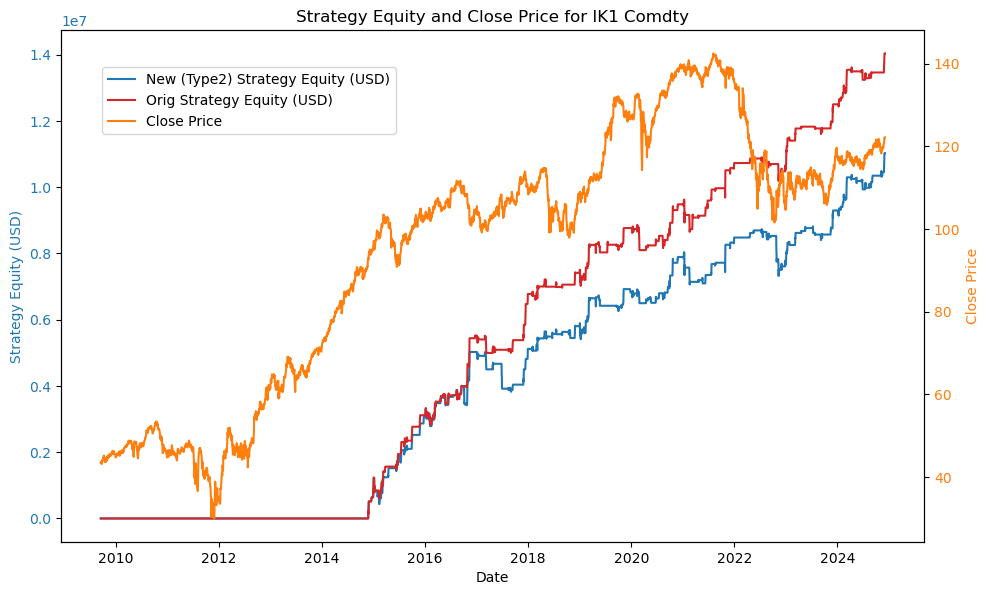

In [144]:
asst_an = 'IK1 Comdty' #########
filter_start_an = '01012012'
filter_start_an = ''

trades= wklySeasn_b_rescale._full_tradeslist()

inv = wklySeasn_b_rescale.backtest_asset(asst_an)
inv2 = wklySeasn_b.backtest_asset(asst_an)
inv2.set_index('Date', inplace=True)
inv.set_index('Date', inplace=True)

if filter_start_an:
    filter_start_an = pd.to_datetime(filter_start_an, format='%d%m%Y')
    inv = inv[inv.index >= filter_start_an]
    inv2 = inv2[inv2.index >= filter_start_an]
    inv['Strategy_Equity_USD'] = inv['Strategy_Equity_USD'] - inv['Strategy_Equity_USD'].iloc[0]   
    inv2['Strategy_Equity_USD'] = inv2['Strategy_Equity_USD'] - inv2['Strategy_Equity_USD'].iloc[0]


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Strategy Equity on the primary axis
ax1.plot(inv.index, inv['Strategy_Equity_USD'], color='tab:blue', label='New (Type2) Strategy Equity (USD)')
ax1.plot(inv2.index, inv2['Strategy_Equity_USD'], color='tab:red', label='Orig Strategy Equity (USD)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Strategy Equity (USD)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary axis to plot the Close price
ax2 = ax1.twinx()
ax2.plot(inv.index, inv['Close'], color='tab:orange', label='Close Price')
ax2.set_ylabel('Close Price', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legends
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title(f'Strategy Equity and Close Price for {asst_an}')
plt.show()



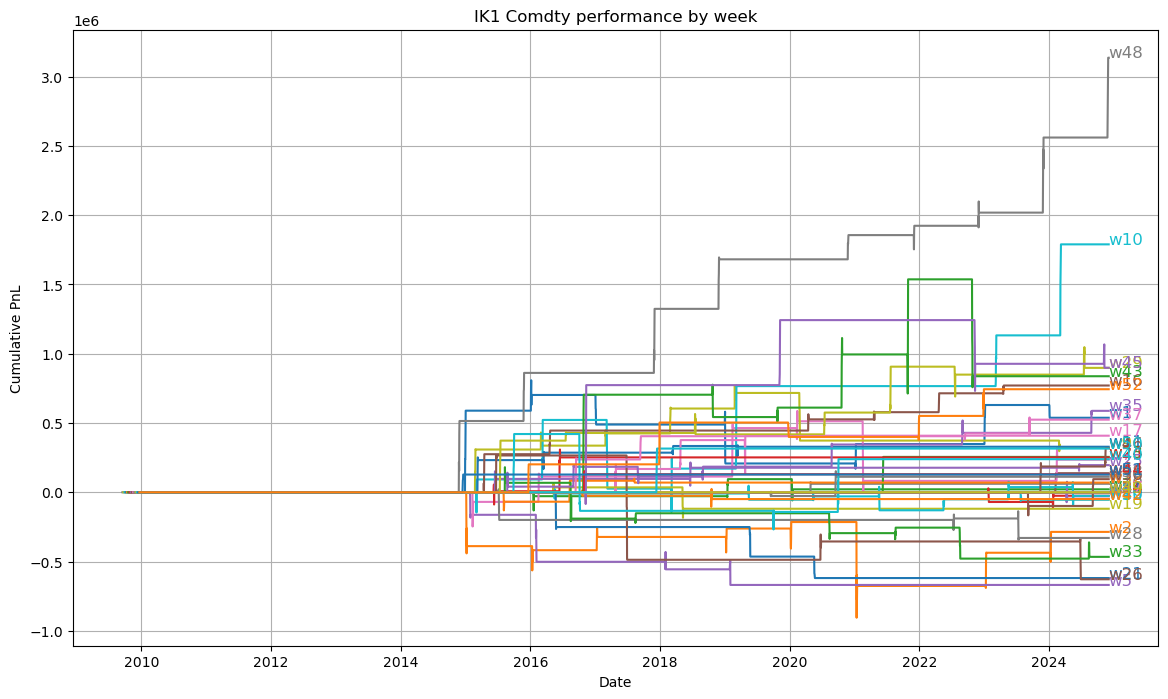

Sharpe Ratio  Cumulative PnL
w48          0.95       3,135,674
w16          0.67         770,383
w10          0.55       1,788,965
w37          0.53         523,893
w29          0.48         897,705
w51          0.47         127,956
w52          0.47         743,552
w6           0.45         137,718
w46          0.45         318,595
w23          0.43         255,187
w35          0.43         587,554
w50          0.41         315,330
w11          0.36         328,531
w45          0.30         898,370
w17          0.23         408,199
w38          0.23         111,761
w18          0.21          61,246
w24          0.21         251,611
w43          0.21         837,302
w25          0.21         195,880

In [145]:
wklyPerf = {}

for i in range(1, 53):
    inv_wk = inv[inv['ISO_Week'] == i]
    wklyPerf[f'w{i}'] = inv_wk['Strategy_PnL_USD'].cumsum()

wklyPerf = pd.DataFrame(wklyPerf).ffill()


# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))


wks_to_plot = []

# Add traces for each week
for week in wklyPerf.columns:
    if len(wks_to_plot) == 0 or week in wks_to_plot:
        ax.plot(wklyPerf.index, wklyPerf[week], label=week)
        # Add the week label next to the line
        ax.text(wklyPerf.index[-1], wklyPerf[week].iloc[-1], week, fontsize=12, color=ax.get_lines()[-1].get_color())

# Update layout
ax.set_title(f'{asst_an} performance by week')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative PnL')
ax.grid(True)

# Show the figure
plt.show()

wklyPerfpnl = wklyPerf.diff()
wklyPerfmean = wklyPerfpnl.mean()
wklyPerfstd = wklyPerfpnl.std()

wklyPerfsr = (wklyPerfmean / wklyPerfstd * np.sqrt(252)).sort_values(ascending=False)


# Concatenate Sharpe ratios and PnL into one DataFrame
combined_metrics = pd.concat([wklyPerfsr, wklyPerf.iloc[-1]], axis=1)
combined_metrics.columns = ['Sharpe Ratio', 'Cumulative PnL']

# Display the combined DataFrame sorted by Sharpe Ratio
combined_metrics_sorted = combined_metrics.sort_values(by='Sharpe Ratio', ascending=False).dropna()
combined_metrics_sorted.head(20)

In [146]:
allticks = list(market_data.get_data().keys())

last_vals = {}
last_pnls = {}
price_pnls = {}


trades_list = wklySeasn_b_rescale._full_tradeslist()

for tck in allticks:
    tmp = wklySeasn_b_rescale._get_btdf(tck).tail(7)
    tradeflag = tmp.iloc[-1]['InTrade']
    if tradeflag > 0:
        tradeflag = 'long'
    else:
        tradeflag = 'short'
    if tmp.iloc[-1]['InTrade'] != 0:
        tmptl = trades_list[trades_list['Asset'] == tck]
        tradepnl = tmptl.iloc[-1]['Trade_PnL']
        tradesize = tmptl.iloc[-1]['Num_Lots']
        tradeentry = tmptl.iloc[-1]['TradeEntry']
        tradeexit = tmptl.iloc[-1]['TradeExit']
        pricepnl = tmptl.iloc[-1]['Price_PnL']
        stdpnl = tmptl.iloc[-1]['Std_PnL']
        print(f'Entered {tradesize:.0f} {tck} {tradeflag} at {tradeentry:.2f} and exited at {tradeexit:.2f} with Trade PnL: {tradepnl:,.0f} and Price PnL: {pricepnl:.2f}, std PnL: {stdpnl:.2f}')
        last_vals[tck] = tmp.tail(6)
        last_pnls[tck] = tradepnl

total_pnl = sum(last_pnls.values())
print(f'Total PnL: {total_pnl:,.0f}')

Total PnL: 0


In [147]:
allticks = list(market_data.get_data().keys())

last_vals = {}
last_pnls = {}
price_pnls = {}


trades_list = wklySeasn_b_rescale._full_tradeslist()

for tck in allticks:
    tmp = wklySeasn_b_rescale._get_btdf(tck).tail(2)
    tradeflag = tmp.iloc[-2]['InTrade']
    if tradeflag > 0:
        tradeflag = 'long'
    else:
        tradeflag = 'short'
    if tmp.iloc[-1]['InTrade'] != 0:
        tradeentry = tmp.iloc[-2]['Close']
        print(f'Entered {tck} {tradeflag} at {tradeentry:.2f} and exited at {tradeexit:.2f} with Trade PnL: {tradepnl:.2f} and Price PnL: {pricepnl:.2f}')
        last_vals[tck] = tmp.tail(2)
        last_pnls[tck] = tradepnl

total_pnl = sum(last_pnls.values())
print(f'Total PnL: {total_pnl:,.0f}')

Total PnL: 0


<Axes: title={'center': 'EZ1 Curncy Equity'}, xlabel='Date'>

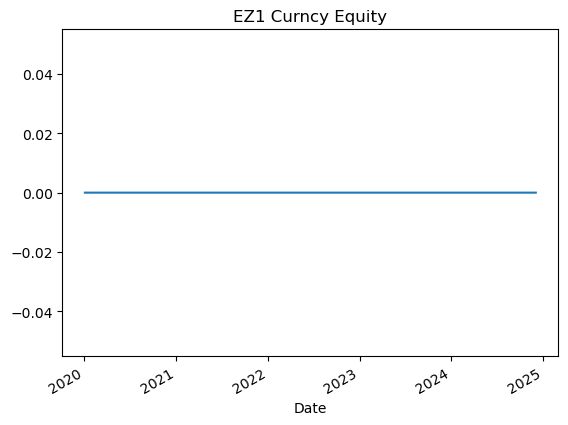

In [148]:
tick = 'EZ1 Curncy'
tmpdf = wklySeasn_b._get_btdf(tick)
tmpdf.set_index('Date', inplace=True)
tmpdf['Strategy_Equity_USD'].plot(title=f'{tick} Equity')